In [191]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [192]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, \
    Conv2DTranspose, BatchNormalization, UpSampling2D, LeakyReLU, Dropout, \
    Reshape, Input, Embedding, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from imutils import paths

In [193]:
# initialise the data paths

dbBase = r"/home/mhasan3/Desktop/WorkFolder/DataRepo/"
dbTrainPath = f"{dbBase}//train_gan_threshinv_10class_28px1px_pristine.hdf5"

# get the no. of classes
trainFile = h5py.File(name=dbTrainPath, mode="r")
class_num = len(list(np.unique(trainFile["labels"])))
print(f"Total no. of classes in dataset: {class_num}")

# get unique labels
labels = list(trainFile["label_names"])
labels = [label.decode() for label in labels]
print(f"Unique Labels: {labels}")

Total no. of classes in dataset: 10
Unique Labels: ['Bearings', 'Bolts', 'Brackets', 'Bushing', 'Collets', 'Pipes', 'PushRings', 'Springs', 'Sprockets', 'Washers']


In [194]:
# plot a list of loaded faces
def plot_images(faces, n):
    f, ax = plt.subplots(n, n, figsize=(16,16)) #type: Figure, axes
    faces_iter = iter(faces)
    for row in range(n):
        for col in range(n):
            axis = ax[row][col] #type: axes
            axis.set_yticklabels([])
            axis.set_xticklabels([])
            axis.grid(False)
            next_face = next(faces_iter)
            next_face = np.squeeze(next_face)
            axis.imshow(next_face, cmap='gray_r')
    plt.show()

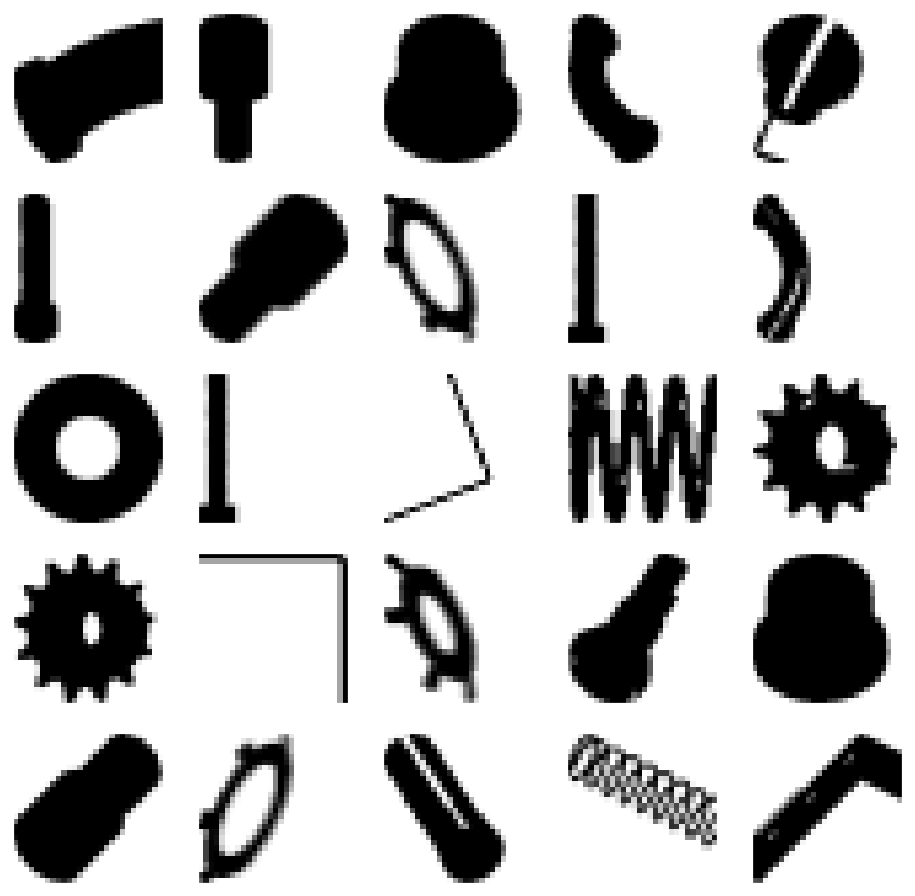

In [195]:
# load the data and plot
(trainx, trainy) = trainFile['images'], trainFile['labels']
plot_images(trainx, 5)

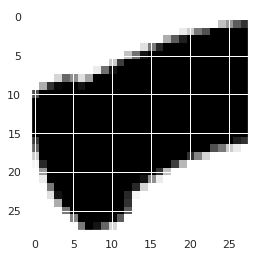

In [196]:
# look at a single image
index = 0
single_image = trainx[index]
single_image = np.squeeze(single_image)
plt.imshow(single_image, cmap='gray_r')

In [197]:
# sanity check of the single image label
single_label = trainy[index]
single_label

5

In [198]:
# define standalone discriminator
def define_discriminator(in_shape=(28,28,1), n_classes=class_num):

    #label input
    in_label = Input(shape=(1,))

    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)

    #scale upto image dimensions with linear activations
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)

    #reshape to additional channel -> 28x28x1
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    #image input
    in_image = Input(shape=in_shape)

    # concat the label and channel -> 28x28x2
    merge = Concatenate()([in_image, li])

    #downsample -> 14x14x128
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)

    # downsample -> 7x7x128
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    #flatten feature maps
    fe = Flatten()(fe)

    #Dropout
    fe = Dropout(0.4)(fe)

    #output
    out_layer = Dense(1, activation='sigmoid')(fe)

    # define the model
    model = Model([in_image, in_label], out_layer)

    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics = ['accuracy'])
    return model

In [199]:
# plot the model
test_d_model = define_discriminator()
#plot_model(test_d_model)

In [200]:
# double check dimensions
test_d_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 1, 50)        500         input_57[0][0]                   
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 1, 784)       39984       embedding_28[0][0]               
__________________________________________________________________________________________________
input_58 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_42

In [201]:
# define the generator
def define_generator(latent_dim, n_classes=class_num):

    # label input
    in_label = Input(shape=(1,))

    # embedding for the categorical input
    li = Embedding(n_classes, 50)(in_label)

    # linear multiplication
    n_nodes = 7*7
    li = Dense(n_nodes)(li)

    # reshape to additional channel
    li = Reshape((7,7,1))(li)

    # image gemnerator input - latent vector
    in_lat = Input(shape=(latent_dim,))

    # foundation for 7x7 image
    n_nodes = 128*7*7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7,7,128))(gen)

    # merge the generated image and label input
    merge = Concatenate()([gen, li])

    # upsample to 14x14
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(4,4),
                          strides=(2,2),
                          padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 28x28
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(4,4),
                          strides=(2,2),
                          padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    #output
    out_layer = Conv2D(filters=1,
                       kernel_size=(7,7),
                       activation='tanh',
                       padding='same')(gen)

    #define the model
    model = Model([in_lat, in_label], out_layer)
    return model

In [202]:
# sanity check
test_g_model = define_generator(100, 5)
#plot_model(test_g_model)

In [203]:
# sanity check dimensions
test_g_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_59 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_59 (Dense)                (None, 6272)         633472      input_60[0][0]                   
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 1, 50)        250         input_59[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

In [204]:
# define the combine geenrator and discriminator model
def define_gan(g_model:Model, d_model:Model):

    # make weights of the discrim not trainable
    d_model.trainable = False

    # get noise and label inputs from generator
    gen_noise, gen_label = g_model.input

    # get image output from generator model
    gen_output = g_model.output

    # connect image output and label input from generator as inputs to discrim
    gan_output = d_model([gen_output, gen_label])

    # define gan model
    model = Model([gen_noise, gen_label], gan_output)

    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [205]:
# sanity check
test_gan_model = define_gan(test_g_model, test_d_model)
#plot_model(test_gan_model)

In [206]:
test_gan_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_59 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_59 (Dense)                (None, 6272)         633472      input_60[0][0]                   
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 1, 50)        250         input_59[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

In [207]:
# load real samples
def load_real_samples():
    # load the dataset
    trainx, trainy = trainFile['images'][:], trainFile['labels'][:]

    x = trainx.astype('float32')

    # scale to -1 +1_
    x = (x - 127.5) / 127.5

    return [x, trainy]

def generate_real_samples(dataset, n_samples):

    # split into images and labels
    images, labels = dataset

    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)
    ix = sorted(ix)

    # sleect the random images and labels
    x, labels = images[ix], labels[ix]

    # generate class labels
    y = np.ones((n_samples, 1))

    return [x, labels], y

In [208]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=class_num):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)

    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)

    # generate labels
    labels = np.random.randint(0, n_classes, n_samples) # these are fake labels
    return [z_input, labels]


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):

    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)

    #predict outputs
    images = generator.predict([z_input, labels_input])

    # create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

In [209]:
# train the generator and discriminator
d_real_losses = []
d_fake_losses = []

d_real_accus = []
d_fake_accus = []

gan_losses = []

def train(g_model:Model,
          d_model:Model,
          gan_model:Model,
          dataset:np.ndarray,
          latent_dim,
          n_epochs = 500,
          n_batch=128):

    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    for i in range(n_epochs):
        #enumerate batches over the training set
        for j in range(bat_per_epo):

            #get randomly selected real samples
            [xreal, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discrim model weights
            dloss1, dacc1 = d_model.train_on_batch([xreal, labels_real], y_real)
            d_real_losses.append(dloss1)
            d_real_accus.append(dacc1)
            

            # generate fake samples
            [xfake, labels], y_fake = generate_fake_samples(g_model,
                                                            latent_dim, half_batch)
            # update discrim model weights
            dloss2, dacc2 = d_model.train_on_batch([xfake, labels], y_fake)
            d_fake_losses.append(dloss2)
            d_fake_accus.append(dacc2)
            

            # prepare points in latent space as generator input
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            #create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))

            # update the generator
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            gan_losses.append(g_loss)

            #summarise loss on this batch
            print(f"{i+1},  {j+1}/{bat_per_epo},  d1={dloss1:0.3f}  "
                  f"d2={dloss2:0.3f} g={g_loss:0.3f}")

    g_model.save(f"{dbBase}//model_gan_10class_28px1px_threshinv.hdf5")

In [210]:
# size of the latent space
latent_dim = 100

# create the discrim
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# load the image data
dataset = load_real_samples()

# train the model
train(g_model=g_model,
      d_model=d_model,
      gan_model=gan_model,
      dataset=dataset,
      latent_dim=latent_dim,
     n_epochs=500)

1,  1/79,  d1=0.700  d2=0.696 g=0.691
1,  2/79,  d1=0.623  d2=0.699 g=0.688
1,  3/79,  d1=0.565  d2=0.705 g=0.682
1,  4/79,  d1=0.492  d2=0.714 g=0.675
1,  5/79,  d1=0.444  d2=0.725 g=0.666
1,  6/79,  d1=0.394  d2=0.742 g=0.655
1,  7/79,  d1=0.339  d2=0.751 g=0.653
1,  8/79,  d1=0.309  d2=0.755 g=0.659
1,  9/79,  d1=0.247  d2=0.742 g=0.695
1,  10/79,  d1=0.229  d2=0.693 g=0.747
1,  11/79,  d1=0.244  d2=0.645 g=0.803
1,  12/79,  d1=0.223  d2=0.615 g=0.831
1,  13/79,  d1=0.184  d2=0.612 g=0.820
1,  14/79,  d1=0.193  d2=0.631 g=0.785
1,  15/79,  d1=0.124  d2=0.670 g=0.738
1,  16/79,  d1=0.145  d2=0.725 g=0.685
1,  17/79,  d1=0.171  d2=0.815 g=0.623
1,  18/79,  d1=0.141  d2=0.914 g=0.575
1,  19/79,  d1=0.131  d2=0.972 g=0.560
1,  20/79,  d1=0.083  d2=0.972 g=0.568
1,  21/79,  d1=0.126  d2=0.960 g=0.594
1,  22/79,  d1=0.119  d2=0.959 g=0.612
1,  23/79,  d1=0.152  d2=0.975 g=0.655
1,  24/79,  d1=0.146  d2=0.911 g=0.723
1,  25/79,  d1=0.209  d2=0.767 g=0.887
1,  26/79,  d1=0.267  d2=0.592 g=1

3,  47/79,  d1=0.326  d2=0.303 g=1.905
3,  48/79,  d1=0.264  d2=0.352 g=1.887
3,  49/79,  d1=0.459  d2=0.314 g=1.870
3,  50/79,  d1=0.525  d2=0.393 g=1.686
3,  51/79,  d1=0.308  d2=0.352 g=1.803
3,  52/79,  d1=0.374  d2=0.316 g=1.695
3,  53/79,  d1=0.295  d2=0.369 g=1.776
3,  54/79,  d1=0.332  d2=0.332 g=1.868
3,  55/79,  d1=0.413  d2=0.313 g=1.883
3,  56/79,  d1=0.441  d2=0.319 g=1.698
3,  57/79,  d1=0.446  d2=0.366 g=1.704
3,  58/79,  d1=0.394  d2=0.383 g=1.731
3,  59/79,  d1=0.387  d2=0.498 g=1.842
3,  60/79,  d1=0.364  d2=0.307 g=1.883
3,  61/79,  d1=0.437  d2=0.325 g=1.770
3,  62/79,  d1=0.376  d2=0.413 g=1.774
3,  63/79,  d1=0.426  d2=0.452 g=1.626
3,  64/79,  d1=0.451  d2=0.349 g=1.628
3,  65/79,  d1=0.352  d2=0.316 g=1.787
3,  66/79,  d1=0.479  d2=0.336 g=1.652
3,  67/79,  d1=0.405  d2=0.375 g=1.693
3,  68/79,  d1=0.411  d2=0.423 g=1.701
3,  69/79,  d1=0.382  d2=0.337 g=1.749
3,  70/79,  d1=0.323  d2=0.365 g=1.925
3,  71/79,  d1=0.422  d2=0.262 g=1.957
3,  72/79,  d1=0.504  d2=

6,  22/79,  d1=0.376  d2=0.436 g=1.377
6,  23/79,  d1=0.420  d2=0.594 g=1.354
6,  24/79,  d1=0.437  d2=0.768 g=1.440
6,  25/79,  d1=0.427  d2=0.504 g=1.535
6,  26/79,  d1=0.548  d2=0.525 g=1.627
6,  27/79,  d1=0.501  d2=0.600 g=1.747
6,  28/79,  d1=0.486  d2=0.449 g=1.772
6,  29/79,  d1=0.411  d2=0.470 g=1.919
6,  30/79,  d1=0.489  d2=0.418 g=1.935
6,  31/79,  d1=0.484  d2=0.339 g=1.776
6,  32/79,  d1=0.545  d2=0.497 g=1.680
6,  33/79,  d1=0.471  d2=0.456 g=1.653
6,  34/79,  d1=0.512  d2=0.424 g=2.030
6,  35/79,  d1=0.469  d2=0.447 g=1.988
6,  36/79,  d1=0.375  d2=0.461 g=1.942
6,  37/79,  d1=0.475  d2=0.450 g=1.615
6,  38/79,  d1=0.431  d2=0.537 g=1.552
6,  39/79,  d1=0.478  d2=0.686 g=1.468
6,  40/79,  d1=0.534  d2=0.615 g=1.193
6,  41/79,  d1=0.638  d2=0.704 g=1.121
6,  42/79,  d1=0.568  d2=0.780 g=1.383
6,  43/79,  d1=0.600  d2=0.671 g=1.886
6,  44/79,  d1=0.603  d2=0.514 g=1.790
6,  45/79,  d1=0.648  d2=0.453 g=1.894
6,  46/79,  d1=0.657  d2=0.428 g=1.794
6,  47/79,  d1=0.532  d2=

8,  76/79,  d1=0.567  d2=0.644 g=0.952
8,  77/79,  d1=0.613  d2=0.636 g=0.983
8,  78/79,  d1=0.635  d2=0.582 g=0.908
8,  79/79,  d1=0.606  d2=0.562 g=0.971
9,  1/79,  d1=0.627  d2=0.564 g=0.890
9,  2/79,  d1=0.593  d2=0.643 g=0.863
9,  3/79,  d1=0.642  d2=0.614 g=0.836
9,  4/79,  d1=0.617  d2=0.642 g=0.794
9,  5/79,  d1=0.572  d2=0.634 g=0.842
9,  6/79,  d1=0.628  d2=0.633 g=0.863
9,  7/79,  d1=0.592  d2=0.681 g=0.903
9,  8/79,  d1=0.603  d2=0.670 g=0.917
9,  9/79,  d1=0.624  d2=0.685 g=0.890
9,  10/79,  d1=0.601  d2=0.689 g=0.906
9,  11/79,  d1=0.627  d2=0.685 g=0.897
9,  12/79,  d1=0.591  d2=0.633 g=0.924
9,  13/79,  d1=0.627  d2=0.634 g=0.917
9,  14/79,  d1=0.681  d2=0.661 g=0.881
9,  15/79,  d1=0.652  d2=0.774 g=0.923
9,  16/79,  d1=0.659  d2=0.653 g=0.902
9,  17/79,  d1=0.696  d2=0.710 g=0.849
9,  18/79,  d1=0.676  d2=0.652 g=0.852
9,  19/79,  d1=0.705  d2=0.657 g=0.847
9,  20/79,  d1=0.648  d2=0.638 g=0.864
9,  21/79,  d1=0.661  d2=0.739 g=0.804
9,  22/79,  d1=0.668  d2=0.721 g=0

11,  47/79,  d1=0.659  d2=0.633 g=0.827
11,  48/79,  d1=0.653  d2=0.677 g=0.837
11,  49/79,  d1=0.634  d2=0.611 g=0.884
11,  50/79,  d1=0.631  d2=0.625 g=0.845
11,  51/79,  d1=0.613  d2=0.621 g=0.823
11,  52/79,  d1=0.578  d2=0.601 g=0.827
11,  53/79,  d1=0.648  d2=0.653 g=0.826
11,  54/79,  d1=0.640  d2=0.637 g=0.868
11,  55/79,  d1=0.631  d2=0.637 g=0.848
11,  56/79,  d1=0.617  d2=0.638 g=0.841
11,  57/79,  d1=0.669  d2=0.634 g=0.844
11,  58/79,  d1=0.668  d2=0.651 g=0.828
11,  59/79,  d1=0.594  d2=0.634 g=0.852
11,  60/79,  d1=0.583  d2=0.634 g=0.845
11,  61/79,  d1=0.618  d2=0.629 g=0.879
11,  62/79,  d1=0.565  d2=0.603 g=0.862
11,  63/79,  d1=0.628  d2=0.643 g=0.836
11,  64/79,  d1=0.660  d2=0.588 g=0.852
11,  65/79,  d1=0.560  d2=0.645 g=0.843
11,  66/79,  d1=0.647  d2=0.623 g=0.878
11,  67/79,  d1=0.639  d2=0.635 g=0.868
11,  68/79,  d1=0.617  d2=0.641 g=0.882
11,  69/79,  d1=0.580  d2=0.616 g=0.819
11,  70/79,  d1=0.663  d2=0.654 g=0.852
11,  71/79,  d1=0.642  d2=0.680 g=0.841


14,  16/79,  d1=0.602  d2=0.674 g=0.826
14,  17/79,  d1=0.639  d2=0.709 g=0.822
14,  18/79,  d1=0.617  d2=0.673 g=0.838
14,  19/79,  d1=0.617  d2=0.689 g=0.845
14,  20/79,  d1=0.625  d2=0.636 g=0.897
14,  21/79,  d1=0.629  d2=0.654 g=0.854
14,  22/79,  d1=0.619  d2=0.590 g=0.873
14,  23/79,  d1=0.658  d2=0.579 g=0.897
14,  24/79,  d1=0.708  d2=0.606 g=0.919
14,  25/79,  d1=0.696  d2=0.632 g=0.843
14,  26/79,  d1=0.671  d2=0.598 g=0.839
14,  27/79,  d1=0.649  d2=0.637 g=0.891
14,  28/79,  d1=0.614  d2=0.659 g=0.860
14,  29/79,  d1=0.697  d2=0.634 g=0.830
14,  30/79,  d1=0.599  d2=0.603 g=0.829
14,  31/79,  d1=0.609  d2=0.601 g=0.864
14,  32/79,  d1=0.606  d2=0.634 g=0.848
14,  33/79,  d1=0.638  d2=0.666 g=0.845
14,  34/79,  d1=0.593  d2=0.647 g=0.879
14,  35/79,  d1=0.654  d2=0.626 g=0.883
14,  36/79,  d1=0.582  d2=0.603 g=0.864
14,  37/79,  d1=0.609  d2=0.660 g=0.878
14,  38/79,  d1=0.583  d2=0.632 g=0.926
14,  39/79,  d1=0.613  d2=0.578 g=0.905
14,  40/79,  d1=0.673  d2=0.598 g=0.912


16,  64/79,  d1=0.643  d2=0.631 g=0.839
16,  65/79,  d1=0.646  d2=0.681 g=0.866
16,  66/79,  d1=0.611  d2=0.632 g=0.865
16,  67/79,  d1=0.612  d2=0.642 g=0.822
16,  68/79,  d1=0.620  d2=0.611 g=0.851
16,  69/79,  d1=0.601  d2=0.641 g=0.886
16,  70/79,  d1=0.643  d2=0.648 g=0.907
16,  71/79,  d1=0.631  d2=0.664 g=0.920
16,  72/79,  d1=0.671  d2=0.565 g=0.971
16,  73/79,  d1=0.655  d2=0.572 g=0.996
16,  74/79,  d1=0.598  d2=0.526 g=1.034
16,  75/79,  d1=0.615  d2=0.501 g=1.086
16,  76/79,  d1=0.664  d2=0.574 g=0.954
16,  77/79,  d1=0.650  d2=0.581 g=0.884
16,  78/79,  d1=0.579  d2=0.643 g=0.833
16,  79/79,  d1=0.659  d2=0.701 g=0.821
17,  1/79,  d1=0.608  d2=0.692 g=0.811
17,  2/79,  d1=0.681  d2=0.646 g=0.864
17,  3/79,  d1=0.612  d2=0.616 g=0.896
17,  4/79,  d1=0.592  d2=0.599 g=0.962
17,  5/79,  d1=0.544  d2=0.575 g=0.987
17,  6/79,  d1=0.548  d2=0.570 g=1.013
17,  7/79,  d1=0.569  d2=0.524 g=0.992
17,  8/79,  d1=0.562  d2=0.613 g=0.942
17,  9/79,  d1=0.665  d2=0.691 g=0.837
17,  10/7

19,  33/79,  d1=0.592  d2=0.628 g=0.795
19,  34/79,  d1=0.661  d2=0.649 g=0.810
19,  35/79,  d1=0.643  d2=0.651 g=0.774
19,  36/79,  d1=0.587  d2=0.652 g=0.815
19,  37/79,  d1=0.627  d2=0.667 g=0.790
19,  38/79,  d1=0.626  d2=0.679 g=0.774
19,  39/79,  d1=0.614  d2=0.653 g=0.793
19,  40/79,  d1=0.616  d2=0.650 g=0.778
19,  41/79,  d1=0.686  d2=0.738 g=0.786
19,  42/79,  d1=0.618  d2=0.665 g=0.805
19,  43/79,  d1=0.693  d2=0.601 g=0.810
19,  44/79,  d1=0.698  d2=0.603 g=0.904
19,  45/79,  d1=0.630  d2=0.619 g=0.856
19,  46/79,  d1=0.724  d2=0.574 g=0.857
19,  47/79,  d1=0.643  d2=0.646 g=0.801
19,  48/79,  d1=0.659  d2=0.719 g=0.778
19,  49/79,  d1=0.638  d2=0.667 g=0.720
19,  50/79,  d1=0.594  d2=0.717 g=0.786
19,  51/79,  d1=0.637  d2=0.635 g=0.804
19,  52/79,  d1=0.677  d2=0.649 g=0.826
19,  53/79,  d1=0.617  d2=0.590 g=0.883
19,  54/79,  d1=0.559  d2=0.589 g=0.947
19,  55/79,  d1=0.533  d2=0.590 g=0.941
19,  56/79,  d1=0.608  d2=0.682 g=0.906
19,  57/79,  d1=0.627  d2=0.784 g=0.723


22,  2/79,  d1=0.652  d2=0.580 g=0.868
22,  3/79,  d1=0.689  d2=0.618 g=0.912
22,  4/79,  d1=0.666  d2=0.623 g=0.832
22,  5/79,  d1=0.686  d2=0.629 g=0.796
22,  6/79,  d1=0.676  d2=0.668 g=0.768
22,  7/79,  d1=0.631  d2=0.662 g=0.791
22,  8/79,  d1=0.642  d2=0.675 g=0.834
22,  9/79,  d1=0.629  d2=0.663 g=0.775
22,  10/79,  d1=0.669  d2=0.623 g=0.799
22,  11/79,  d1=0.606  d2=0.642 g=0.835
22,  12/79,  d1=0.629  d2=0.631 g=0.850
22,  13/79,  d1=0.656  d2=0.626 g=0.853
22,  14/79,  d1=0.678  d2=0.614 g=0.831
22,  15/79,  d1=0.623  d2=0.691 g=0.806
22,  16/79,  d1=0.632  d2=0.684 g=0.768
22,  17/79,  d1=0.603  d2=0.747 g=0.750
22,  18/79,  d1=0.652  d2=0.751 g=0.785
22,  19/79,  d1=0.613  d2=0.724 g=0.826
22,  20/79,  d1=0.679  d2=0.644 g=0.913
22,  21/79,  d1=0.673  d2=0.613 g=0.926
22,  22/79,  d1=0.723  d2=0.541 g=0.947
22,  23/79,  d1=0.657  d2=0.527 g=0.978
22,  24/79,  d1=0.683  d2=0.530 g=0.959
22,  25/79,  d1=0.695  d2=0.616 g=0.880
22,  26/79,  d1=0.735  d2=0.652 g=0.836
22,  27/

24,  50/79,  d1=0.650  d2=0.679 g=0.815
24,  51/79,  d1=0.628  d2=0.670 g=0.778
24,  52/79,  d1=0.700  d2=0.655 g=0.798
24,  53/79,  d1=0.640  d2=0.653 g=0.822
24,  54/79,  d1=0.656  d2=0.656 g=0.763
24,  55/79,  d1=0.643  d2=0.693 g=0.810
24,  56/79,  d1=0.658  d2=0.649 g=0.797
24,  57/79,  d1=0.666  d2=0.659 g=0.781
24,  58/79,  d1=0.637  d2=0.700 g=0.801
24,  59/79,  d1=0.663  d2=0.679 g=0.817
24,  60/79,  d1=0.649  d2=0.661 g=0.793
24,  61/79,  d1=0.657  d2=0.653 g=0.773
24,  62/79,  d1=0.639  d2=0.662 g=0.815
24,  63/79,  d1=0.635  d2=0.669 g=0.778
24,  64/79,  d1=0.681  d2=0.682 g=0.789
24,  65/79,  d1=0.672  d2=0.652 g=0.813
24,  66/79,  d1=0.668  d2=0.675 g=0.826
24,  67/79,  d1=0.633  d2=0.602 g=0.772
24,  68/79,  d1=0.615  d2=0.664 g=0.795
24,  69/79,  d1=0.648  d2=0.639 g=0.824
24,  70/79,  d1=0.611  d2=0.664 g=0.814
24,  71/79,  d1=0.653  d2=0.653 g=0.776
24,  72/79,  d1=0.701  d2=0.668 g=0.796
24,  73/79,  d1=0.625  d2=0.685 g=0.796
24,  74/79,  d1=0.650  d2=0.636 g=0.785


27,  19/79,  d1=0.677  d2=0.670 g=0.829
27,  20/79,  d1=0.685  d2=0.643 g=0.821
27,  21/79,  d1=0.644  d2=0.646 g=0.826
27,  22/79,  d1=0.633  d2=0.659 g=0.813
27,  23/79,  d1=0.705  d2=0.678 g=0.842
27,  24/79,  d1=0.626  d2=0.641 g=0.818
27,  25/79,  d1=0.646  d2=0.601 g=0.798
27,  26/79,  d1=0.698  d2=0.646 g=0.825
27,  27/79,  d1=0.633  d2=0.683 g=0.798
27,  28/79,  d1=0.645  d2=0.686 g=0.826
27,  29/79,  d1=0.656  d2=0.661 g=0.832
27,  30/79,  d1=0.677  d2=0.649 g=0.857
27,  31/79,  d1=0.626  d2=0.599 g=0.863
27,  32/79,  d1=0.651  d2=0.628 g=0.859
27,  33/79,  d1=0.698  d2=0.633 g=0.824
27,  34/79,  d1=0.668  d2=0.634 g=0.781
27,  35/79,  d1=0.643  d2=0.680 g=0.809
27,  36/79,  d1=0.685  d2=0.648 g=0.779
27,  37/79,  d1=0.642  d2=0.643 g=0.813
27,  38/79,  d1=0.635  d2=0.654 g=0.798
27,  39/79,  d1=0.643  d2=0.661 g=0.843
27,  40/79,  d1=0.622  d2=0.647 g=0.825
27,  41/79,  d1=0.596  d2=0.705 g=0.815
27,  42/79,  d1=0.688  d2=0.636 g=0.788
27,  43/79,  d1=0.638  d2=0.643 g=0.777


29,  67/79,  d1=0.643  d2=0.613 g=0.854
29,  68/79,  d1=0.662  d2=0.604 g=0.811
29,  69/79,  d1=0.633  d2=0.644 g=0.870
29,  70/79,  d1=0.614  d2=0.628 g=0.853
29,  71/79,  d1=0.669  d2=0.677 g=0.821
29,  72/79,  d1=0.605  d2=0.632 g=0.811
29,  73/79,  d1=0.618  d2=0.639 g=0.819
29,  74/79,  d1=0.569  d2=0.659 g=0.859
29,  75/79,  d1=0.641  d2=0.614 g=0.846
29,  76/79,  d1=0.619  d2=0.583 g=0.882
29,  77/79,  d1=0.676  d2=0.618 g=0.837
29,  78/79,  d1=0.625  d2=0.660 g=0.843
29,  79/79,  d1=0.605  d2=0.648 g=0.864
30,  1/79,  d1=0.659  d2=0.660 g=0.815
30,  2/79,  d1=0.714  d2=0.635 g=0.849
30,  3/79,  d1=0.638  d2=0.619 g=0.808
30,  4/79,  d1=0.628  d2=0.657 g=0.814
30,  5/79,  d1=0.632  d2=0.655 g=0.822
30,  6/79,  d1=0.605  d2=0.621 g=0.834
30,  7/79,  d1=0.607  d2=0.627 g=0.854
30,  8/79,  d1=0.595  d2=0.607 g=0.843
30,  9/79,  d1=0.583  d2=0.623 g=0.804
30,  10/79,  d1=0.652  d2=0.588 g=0.788
30,  11/79,  d1=0.573  d2=0.681 g=0.797
30,  12/79,  d1=0.626  d2=0.674 g=0.841
30,  13/7

32,  36/79,  d1=0.637  d2=0.631 g=0.848
32,  37/79,  d1=0.656  d2=0.608 g=0.810
32,  38/79,  d1=0.628  d2=0.642 g=0.825
32,  39/79,  d1=0.648  d2=0.611 g=0.854
32,  40/79,  d1=0.609  d2=0.628 g=0.852
32,  41/79,  d1=0.671  d2=0.638 g=0.835
32,  42/79,  d1=0.624  d2=0.636 g=0.835
32,  43/79,  d1=0.599  d2=0.608 g=0.843
32,  44/79,  d1=0.655  d2=0.622 g=0.833
32,  45/79,  d1=0.689  d2=0.658 g=0.823
32,  46/79,  d1=0.630  d2=0.675 g=0.772
32,  47/79,  d1=0.567  d2=0.628 g=0.864
32,  48/79,  d1=0.666  d2=0.634 g=0.870
32,  49/79,  d1=0.620  d2=0.649 g=0.848
32,  50/79,  d1=0.646  d2=0.679 g=0.870
32,  51/79,  d1=0.660  d2=0.667 g=0.867
32,  52/79,  d1=0.665  d2=0.631 g=0.843
32,  53/79,  d1=0.627  d2=0.623 g=0.865
32,  54/79,  d1=0.653  d2=0.625 g=0.855
32,  55/79,  d1=0.658  d2=0.583 g=0.845
32,  56/79,  d1=0.636  d2=0.635 g=0.833
32,  57/79,  d1=0.584  d2=0.655 g=0.837
32,  58/79,  d1=0.596  d2=0.600 g=0.811
32,  59/79,  d1=0.619  d2=0.681 g=0.838
32,  60/79,  d1=0.666  d2=0.659 g=0.845


35,  5/79,  d1=0.650  d2=0.636 g=0.841
35,  6/79,  d1=0.632  d2=0.611 g=0.838
35,  7/79,  d1=0.578  d2=0.637 g=0.876
35,  8/79,  d1=0.642  d2=0.614 g=0.911
35,  9/79,  d1=0.593  d2=0.615 g=0.863
35,  10/79,  d1=0.678  d2=0.609 g=0.893
35,  11/79,  d1=0.603  d2=0.634 g=0.843
35,  12/79,  d1=0.643  d2=0.607 g=0.836
35,  13/79,  d1=0.641  d2=0.647 g=0.877
35,  14/79,  d1=0.619  d2=0.627 g=0.860
35,  15/79,  d1=0.656  d2=0.606 g=0.914
35,  16/79,  d1=0.594  d2=0.610 g=0.913
35,  17/79,  d1=0.657  d2=0.649 g=0.819
35,  18/79,  d1=0.583  d2=0.623 g=0.899
35,  19/79,  d1=0.556  d2=0.654 g=0.860
35,  20/79,  d1=0.652  d2=0.648 g=0.828
35,  21/79,  d1=0.622  d2=0.652 g=0.823
35,  22/79,  d1=0.603  d2=0.601 g=0.894
35,  23/79,  d1=0.613  d2=0.578 g=0.925
35,  24/79,  d1=0.669  d2=0.579 g=0.916
35,  25/79,  d1=0.622  d2=0.641 g=0.872
35,  26/79,  d1=0.612  d2=0.686 g=0.826
35,  27/79,  d1=0.606  d2=0.623 g=0.855
35,  28/79,  d1=0.654  d2=0.642 g=0.826
35,  29/79,  d1=0.666  d2=0.617 g=0.893
35,  

37,  53/79,  d1=0.616  d2=0.578 g=0.925
37,  54/79,  d1=0.647  d2=0.619 g=0.837
37,  55/79,  d1=0.637  d2=0.621 g=0.878
37,  56/79,  d1=0.592  d2=0.552 g=0.871
37,  57/79,  d1=0.650  d2=0.636 g=0.893
37,  58/79,  d1=0.629  d2=0.675 g=0.864
37,  59/79,  d1=0.597  d2=0.641 g=0.909
37,  60/79,  d1=0.601  d2=0.606 g=0.907
37,  61/79,  d1=0.606  d2=0.603 g=0.872
37,  62/79,  d1=0.617  d2=0.617 g=0.908
37,  63/79,  d1=0.605  d2=0.613 g=0.904
37,  64/79,  d1=0.596  d2=0.619 g=0.882
37,  65/79,  d1=0.610  d2=0.625 g=0.851
37,  66/79,  d1=0.647  d2=0.633 g=0.901
37,  67/79,  d1=0.573  d2=0.608 g=0.898
37,  68/79,  d1=0.625  d2=0.602 g=0.860
37,  69/79,  d1=0.588  d2=0.689 g=0.856
37,  70/79,  d1=0.591  d2=0.612 g=0.868
37,  71/79,  d1=0.611  d2=0.624 g=0.916
37,  72/79,  d1=0.638  d2=0.572 g=0.927
37,  73/79,  d1=0.649  d2=0.561 g=0.887
37,  74/79,  d1=0.607  d2=0.620 g=0.874
37,  75/79,  d1=0.580  d2=0.613 g=0.892
37,  76/79,  d1=0.612  d2=0.590 g=0.881
37,  77/79,  d1=0.634  d2=0.583 g=0.904


40,  22/79,  d1=0.623  d2=0.606 g=0.922
40,  23/79,  d1=0.660  d2=0.578 g=0.887
40,  24/79,  d1=0.542  d2=0.621 g=0.881
40,  25/79,  d1=0.590  d2=0.549 g=0.909
40,  26/79,  d1=0.570  d2=0.665 g=0.916
40,  27/79,  d1=0.634  d2=0.586 g=0.862
40,  28/79,  d1=0.639  d2=0.590 g=0.878
40,  29/79,  d1=0.613  d2=0.582 g=0.889
40,  30/79,  d1=0.607  d2=0.623 g=0.950
40,  31/79,  d1=0.600  d2=0.669 g=0.958
40,  32/79,  d1=0.605  d2=0.642 g=0.909
40,  33/79,  d1=0.577  d2=0.588 g=0.872
40,  34/79,  d1=0.582  d2=0.561 g=0.919
40,  35/79,  d1=0.607  d2=0.594 g=0.922
40,  36/79,  d1=0.643  d2=0.549 g=0.936
40,  37/79,  d1=0.672  d2=0.640 g=0.889
40,  38/79,  d1=0.616  d2=0.647 g=0.841
40,  39/79,  d1=0.575  d2=0.636 g=0.865
40,  40/79,  d1=0.665  d2=0.594 g=0.874
40,  41/79,  d1=0.658  d2=0.655 g=0.896
40,  42/79,  d1=0.590  d2=0.570 g=0.962
40,  43/79,  d1=0.572  d2=0.605 g=0.894
40,  44/79,  d1=0.613  d2=0.595 g=0.868
40,  45/79,  d1=0.659  d2=0.644 g=0.866
40,  46/79,  d1=0.542  d2=0.653 g=0.905


42,  70/79,  d1=0.533  d2=0.606 g=0.968
42,  71/79,  d1=0.563  d2=0.608 g=0.930
42,  72/79,  d1=0.602  d2=0.533 g=0.939
42,  73/79,  d1=0.591  d2=0.584 g=0.941
42,  74/79,  d1=0.664  d2=0.604 g=0.917
42,  75/79,  d1=0.607  d2=0.593 g=0.902
42,  76/79,  d1=0.515  d2=0.568 g=0.911
42,  77/79,  d1=0.603  d2=0.570 g=0.966
42,  78/79,  d1=0.617  d2=0.589 g=0.888
42,  79/79,  d1=0.606  d2=0.612 g=0.934
43,  1/79,  d1=0.608  d2=0.617 g=0.930
43,  2/79,  d1=0.600  d2=0.660 g=0.953
43,  3/79,  d1=0.582  d2=0.595 g=0.897
43,  4/79,  d1=0.677  d2=0.624 g=0.928
43,  5/79,  d1=0.592  d2=0.568 g=0.916
43,  6/79,  d1=0.591  d2=0.596 g=0.937
43,  7/79,  d1=0.565  d2=0.606 g=0.928
43,  8/79,  d1=0.673  d2=0.630 g=0.924
43,  9/79,  d1=0.579  d2=0.561 g=0.968
43,  10/79,  d1=0.617  d2=0.625 g=0.904
43,  11/79,  d1=0.554  d2=0.598 g=0.873
43,  12/79,  d1=0.586  d2=0.611 g=0.906
43,  13/79,  d1=0.687  d2=0.593 g=0.941
43,  14/79,  d1=0.587  d2=0.574 g=0.942
43,  15/79,  d1=0.575  d2=0.615 g=0.975
43,  16/7

45,  39/79,  d1=0.645  d2=0.550 g=0.972
45,  40/79,  d1=0.540  d2=0.564 g=0.989
45,  41/79,  d1=0.603  d2=0.577 g=0.962
45,  42/79,  d1=0.572  d2=0.628 g=1.046
45,  43/79,  d1=0.654  d2=0.539 g=0.905
45,  44/79,  d1=0.560  d2=0.558 g=0.930
45,  45/79,  d1=0.622  d2=0.575 g=0.950
45,  46/79,  d1=0.605  d2=0.560 g=0.954
45,  47/79,  d1=0.632  d2=0.575 g=0.892
45,  48/79,  d1=0.630  d2=0.638 g=0.916
45,  49/79,  d1=0.542  d2=0.584 g=0.927
45,  50/79,  d1=0.538  d2=0.576 g=0.938
45,  51/79,  d1=0.582  d2=0.539 g=0.969
45,  52/79,  d1=0.614  d2=0.590 g=0.946
45,  53/79,  d1=0.591  d2=0.604 g=0.930
45,  54/79,  d1=0.598  d2=0.568 g=0.966
45,  55/79,  d1=0.593  d2=0.610 g=0.920
45,  56/79,  d1=0.648  d2=0.596 g=0.927
45,  57/79,  d1=0.612  d2=0.616 g=0.952
45,  58/79,  d1=0.564  d2=0.595 g=0.966
45,  59/79,  d1=0.570  d2=0.588 g=0.943
45,  60/79,  d1=0.621  d2=0.544 g=1.002
45,  61/79,  d1=0.549  d2=0.593 g=0.988
45,  62/79,  d1=0.585  d2=0.594 g=0.983
45,  63/79,  d1=0.525  d2=0.583 g=0.993


48,  8/79,  d1=0.571  d2=0.578 g=0.934
48,  9/79,  d1=0.486  d2=0.550 g=0.997
48,  10/79,  d1=0.522  d2=0.545 g=1.016
48,  11/79,  d1=0.573  d2=0.546 g=0.992
48,  12/79,  d1=0.606  d2=0.555 g=0.984
48,  13/79,  d1=0.664  d2=0.580 g=0.964
48,  14/79,  d1=0.558  d2=0.544 g=0.987
48,  15/79,  d1=0.578  d2=0.546 g=1.036
48,  16/79,  d1=0.537  d2=0.612 g=1.003
48,  17/79,  d1=0.559  d2=0.555 g=1.009
48,  18/79,  d1=0.566  d2=0.557 g=1.006
48,  19/79,  d1=0.580  d2=0.573 g=0.966
48,  20/79,  d1=0.545  d2=0.551 g=1.032
48,  21/79,  d1=0.560  d2=0.506 g=0.934
48,  22/79,  d1=0.562  d2=0.575 g=0.983
48,  23/79,  d1=0.627  d2=0.626 g=0.964
48,  24/79,  d1=0.548  d2=0.559 g=1.033
48,  25/79,  d1=0.615  d2=0.554 g=0.997
48,  26/79,  d1=0.605  d2=0.540 g=0.995
48,  27/79,  d1=0.620  d2=0.517 g=1.022
48,  28/79,  d1=0.580  d2=0.569 g=0.960
48,  29/79,  d1=0.607  d2=0.637 g=1.010
48,  30/79,  d1=0.517  d2=0.577 g=0.980
48,  31/79,  d1=0.612  d2=0.609 g=0.963
48,  32/79,  d1=0.583  d2=0.585 g=1.000
48

50,  56/79,  d1=0.594  d2=0.559 g=0.983
50,  57/79,  d1=0.575  d2=0.630 g=1.039
50,  58/79,  d1=0.600  d2=0.585 g=1.032
50,  59/79,  d1=0.579  d2=0.611 g=0.989
50,  60/79,  d1=0.504  d2=0.583 g=1.071
50,  61/79,  d1=0.592  d2=0.530 g=1.005
50,  62/79,  d1=0.634  d2=0.547 g=1.018
50,  63/79,  d1=0.554  d2=0.577 g=1.007
50,  64/79,  d1=0.656  d2=0.578 g=1.024
50,  65/79,  d1=0.572  d2=0.537 g=0.968
50,  66/79,  d1=0.562  d2=0.561 g=0.984
50,  67/79,  d1=0.534  d2=0.632 g=1.024
50,  68/79,  d1=0.529  d2=0.590 g=1.035
50,  69/79,  d1=0.624  d2=0.577 g=0.995
50,  70/79,  d1=0.627  d2=0.567 g=0.999
50,  71/79,  d1=0.548  d2=0.610 g=1.114
50,  72/79,  d1=0.616  d2=0.551 g=1.078
50,  73/79,  d1=0.499  d2=0.599 g=1.085
50,  74/79,  d1=0.554  d2=0.552 g=1.046
50,  75/79,  d1=0.529  d2=0.547 g=1.128
50,  76/79,  d1=0.653  d2=0.542 g=1.028
50,  77/79,  d1=0.599  d2=0.599 g=1.023
50,  78/79,  d1=0.609  d2=0.602 g=1.063
50,  79/79,  d1=0.574  d2=0.614 g=1.076
51,  1/79,  d1=0.573  d2=0.595 g=1.038
5

53,  25/79,  d1=0.615  d2=0.610 g=1.033
53,  26/79,  d1=0.561  d2=0.542 g=1.060
53,  27/79,  d1=0.634  d2=0.523 g=1.061
53,  28/79,  d1=0.483  d2=0.579 g=0.988
53,  29/79,  d1=0.576  d2=0.503 g=1.131
53,  30/79,  d1=0.628  d2=0.593 g=1.064
53,  31/79,  d1=0.545  d2=0.508 g=1.026
53,  32/79,  d1=0.529  d2=0.601 g=1.060
53,  33/79,  d1=0.514  d2=0.510 g=1.041
53,  34/79,  d1=0.554  d2=0.579 g=1.146
53,  35/79,  d1=0.506  d2=0.560 g=1.033
53,  36/79,  d1=0.591  d2=0.570 g=1.088
53,  37/79,  d1=0.543  d2=0.530 g=1.066
53,  38/79,  d1=0.604  d2=0.478 g=1.067
53,  39/79,  d1=0.595  d2=0.515 g=1.070
53,  40/79,  d1=0.545  d2=0.609 g=1.010
53,  41/79,  d1=0.587  d2=0.580 g=1.021
53,  42/79,  d1=0.555  d2=0.586 g=1.057
53,  43/79,  d1=0.508  d2=0.525 g=1.058
53,  44/79,  d1=0.599  d2=0.567 g=1.018
53,  45/79,  d1=0.593  d2=0.535 g=1.044
53,  46/79,  d1=0.564  d2=0.581 g=1.058
53,  47/79,  d1=0.519  d2=0.519 g=1.096
53,  48/79,  d1=0.513  d2=0.556 g=1.040
53,  49/79,  d1=0.573  d2=0.558 g=1.035


55,  73/79,  d1=0.563  d2=0.554 g=1.133
55,  74/79,  d1=0.571  d2=0.524 g=1.076
55,  75/79,  d1=0.636  d2=0.532 g=1.051
55,  76/79,  d1=0.509  d2=0.558 g=0.988
55,  77/79,  d1=0.580  d2=0.548 g=1.019
55,  78/79,  d1=0.548  d2=0.560 g=0.994
55,  79/79,  d1=0.540  d2=0.575 g=1.034
56,  1/79,  d1=0.520  d2=0.563 g=1.023
56,  2/79,  d1=0.536  d2=0.566 g=1.019
56,  3/79,  d1=0.501  d2=0.544 g=1.085
56,  4/79,  d1=0.559  d2=0.577 g=1.000
56,  5/79,  d1=0.635  d2=0.554 g=1.023
56,  6/79,  d1=0.493  d2=0.497 g=1.013
56,  7/79,  d1=0.514  d2=0.579 g=1.045
56,  8/79,  d1=0.632  d2=0.511 g=1.094
56,  9/79,  d1=0.603  d2=0.583 g=1.008
56,  10/79,  d1=0.566  d2=0.616 g=1.056
56,  11/79,  d1=0.507  d2=0.533 g=1.145
56,  12/79,  d1=0.588  d2=0.526 g=1.064
56,  13/79,  d1=0.623  d2=0.592 g=1.109
56,  14/79,  d1=0.610  d2=0.536 g=1.033
56,  15/79,  d1=0.504  d2=0.521 g=1.041
56,  16/79,  d1=0.625  d2=0.587 g=1.121
56,  17/79,  d1=0.491  d2=0.538 g=1.093
56,  18/79,  d1=0.548  d2=0.536 g=1.076
56,  19/7

58,  42/79,  d1=0.521  d2=0.629 g=1.079
58,  43/79,  d1=0.485  d2=0.493 g=1.116
58,  44/79,  d1=0.593  d2=0.573 g=1.072
58,  45/79,  d1=0.597  d2=0.582 g=1.029
58,  46/79,  d1=0.581  d2=0.499 g=1.096
58,  47/79,  d1=0.666  d2=0.519 g=1.028
58,  48/79,  d1=0.514  d2=0.520 g=1.175
58,  49/79,  d1=0.543  d2=0.601 g=1.037
58,  50/79,  d1=0.585  d2=0.494 g=1.046
58,  51/79,  d1=0.574  d2=0.551 g=1.058
58,  52/79,  d1=0.508  d2=0.602 g=1.131
58,  53/79,  d1=0.605  d2=0.494 g=1.089
58,  54/79,  d1=0.566  d2=0.540 g=1.106
58,  55/79,  d1=0.571  d2=0.657 g=1.120
58,  56/79,  d1=0.602  d2=0.531 g=1.088
58,  57/79,  d1=0.559  d2=0.513 g=1.115
58,  58/79,  d1=0.543  d2=0.617 g=1.067
58,  59/79,  d1=0.644  d2=0.563 g=1.048
58,  60/79,  d1=0.686  d2=0.537 g=1.075
58,  61/79,  d1=0.445  d2=0.549 g=1.022
58,  62/79,  d1=0.577  d2=0.537 g=1.125
58,  63/79,  d1=0.574  d2=0.517 g=1.089
58,  64/79,  d1=0.503  d2=0.569 g=1.139
58,  65/79,  d1=0.656  d2=0.576 g=1.067
58,  66/79,  d1=0.587  d2=0.536 g=1.102


61,  11/79,  d1=0.595  d2=0.546 g=1.093
61,  12/79,  d1=0.578  d2=0.503 g=1.044
61,  13/79,  d1=0.504  d2=0.556 g=1.027
61,  14/79,  d1=0.499  d2=0.592 g=1.084
61,  15/79,  d1=0.538  d2=0.569 g=1.078
61,  16/79,  d1=0.478  d2=0.564 g=1.147
61,  17/79,  d1=0.566  d2=0.470 g=1.140
61,  18/79,  d1=0.597  d2=0.466 g=1.134
61,  19/79,  d1=0.544  d2=0.538 g=1.075
61,  20/79,  d1=0.482  d2=0.523 g=1.111
61,  21/79,  d1=0.529  d2=0.514 g=1.086
61,  22/79,  d1=0.495  d2=0.479 g=1.149
61,  23/79,  d1=0.627  d2=0.551 g=1.138
61,  24/79,  d1=0.559  d2=0.468 g=1.043
61,  25/79,  d1=0.501  d2=0.561 g=1.094
61,  26/79,  d1=0.596  d2=0.537 g=1.100
61,  27/79,  d1=0.666  d2=0.548 g=1.026
61,  28/79,  d1=0.689  d2=0.512 g=1.017
61,  29/79,  d1=0.463  d2=0.615 g=1.003
61,  30/79,  d1=0.526  d2=0.553 g=1.035
61,  31/79,  d1=0.495  d2=0.520 g=1.151
61,  32/79,  d1=0.575  d2=0.497 g=1.084
61,  33/79,  d1=0.664  d2=0.530 g=1.189
61,  34/79,  d1=0.511  d2=0.589 g=1.177
61,  35/79,  d1=0.553  d2=0.570 g=1.020


63,  59/79,  d1=0.593  d2=0.466 g=1.119
63,  60/79,  d1=0.575  d2=0.514 g=1.051
63,  61/79,  d1=0.526  d2=0.493 g=1.094
63,  62/79,  d1=0.604  d2=0.459 g=1.042
63,  63/79,  d1=0.461  d2=0.570 g=1.133
63,  64/79,  d1=0.576  d2=0.503 g=1.095
63,  65/79,  d1=0.611  d2=0.577 g=1.078
63,  66/79,  d1=0.519  d2=0.614 g=1.054
63,  67/79,  d1=0.576  d2=0.567 g=1.110
63,  68/79,  d1=0.562  d2=0.560 g=1.091
63,  69/79,  d1=0.581  d2=0.494 g=1.109
63,  70/79,  d1=0.399  d2=0.562 g=1.212
63,  71/79,  d1=0.635  d2=0.526 g=1.144
63,  72/79,  d1=0.578  d2=0.479 g=1.094
63,  73/79,  d1=0.613  d2=0.475 g=1.176
63,  74/79,  d1=0.417  d2=0.561 g=1.156
63,  75/79,  d1=0.567  d2=0.487 g=1.140
63,  76/79,  d1=0.628  d2=0.534 g=0.991
63,  77/79,  d1=0.499  d2=0.526 g=1.060
63,  78/79,  d1=0.512  d2=0.550 g=1.200
63,  79/79,  d1=0.564  d2=0.544 g=1.216
64,  1/79,  d1=0.541  d2=0.515 g=1.083
64,  2/79,  d1=0.559  d2=0.553 g=1.109
64,  3/79,  d1=0.640  d2=0.500 g=1.116
64,  4/79,  d1=0.597  d2=0.573 g=1.106
64, 

66,  28/79,  d1=0.540  d2=0.555 g=1.148
66,  29/79,  d1=0.586  d2=0.453 g=1.102
66,  30/79,  d1=0.532  d2=0.512 g=1.067
66,  31/79,  d1=0.443  d2=0.495 g=1.113
66,  32/79,  d1=0.546  d2=0.512 g=1.086
66,  33/79,  d1=0.565  d2=0.573 g=1.098
66,  34/79,  d1=0.541  d2=0.546 g=1.161
66,  35/79,  d1=0.515  d2=0.511 g=1.129
66,  36/79,  d1=0.594  d2=0.520 g=1.112
66,  37/79,  d1=0.506  d2=0.509 g=1.133
66,  38/79,  d1=0.576  d2=0.503 g=1.185
66,  39/79,  d1=0.530  d2=0.558 g=1.120
66,  40/79,  d1=0.534  d2=0.601 g=1.117
66,  41/79,  d1=0.573  d2=0.480 g=1.133
66,  42/79,  d1=0.569  d2=0.484 g=1.191
66,  43/79,  d1=0.484  d2=0.580 g=1.205
66,  44/79,  d1=0.566  d2=0.492 g=1.198
66,  45/79,  d1=0.617  d2=0.492 g=1.140
66,  46/79,  d1=0.581  d2=0.501 g=1.130
66,  47/79,  d1=0.613  d2=0.550 g=1.093
66,  48/79,  d1=0.505  d2=0.554 g=1.101
66,  49/79,  d1=0.508  d2=0.512 g=1.133
66,  50/79,  d1=0.606  d2=0.570 g=1.178
66,  51/79,  d1=0.654  d2=0.559 g=1.082
66,  52/79,  d1=0.486  d2=0.556 g=1.115


68,  76/79,  d1=0.429  d2=0.560 g=1.120
68,  77/79,  d1=0.605  d2=0.526 g=1.090
68,  78/79,  d1=0.587  d2=0.527 g=1.120
68,  79/79,  d1=0.501  d2=0.603 g=1.180
69,  1/79,  d1=0.528  d2=0.495 g=1.131
69,  2/79,  d1=0.588  d2=0.531 g=1.139
69,  3/79,  d1=0.592  d2=0.499 g=1.088
69,  4/79,  d1=0.631  d2=0.619 g=1.103
69,  5/79,  d1=0.534  d2=0.585 g=1.156
69,  6/79,  d1=0.624  d2=0.506 g=1.101
69,  7/79,  d1=0.551  d2=0.508 g=1.186
69,  8/79,  d1=0.569  d2=0.488 g=1.038
69,  9/79,  d1=0.538  d2=0.511 g=1.162
69,  10/79,  d1=0.620  d2=0.566 g=1.137
69,  11/79,  d1=0.514  d2=0.597 g=1.152
69,  12/79,  d1=0.471  d2=0.497 g=1.156
69,  13/79,  d1=0.555  d2=0.591 g=1.121
69,  14/79,  d1=0.538  d2=0.419 g=1.149
69,  15/79,  d1=0.699  d2=0.529 g=1.056
69,  16/79,  d1=0.569  d2=0.603 g=1.137
69,  17/79,  d1=0.536  d2=0.536 g=1.109
69,  18/79,  d1=0.545  d2=0.587 g=1.052
69,  19/79,  d1=0.525  d2=0.503 g=1.086
69,  20/79,  d1=0.574  d2=0.560 g=1.137
69,  21/79,  d1=0.489  d2=0.480 g=1.153
69,  22/7

71,  45/79,  d1=0.508  d2=0.564 g=1.031
71,  46/79,  d1=0.553  d2=0.582 g=1.056
71,  47/79,  d1=0.617  d2=0.522 g=1.056
71,  48/79,  d1=0.591  d2=0.603 g=1.053
71,  49/79,  d1=0.525  d2=0.528 g=1.077
71,  50/79,  d1=0.489  d2=0.559 g=1.134
71,  51/79,  d1=0.557  d2=0.537 g=1.094
71,  52/79,  d1=0.521  d2=0.533 g=1.076
71,  53/79,  d1=0.536  d2=0.515 g=1.075
71,  54/79,  d1=0.629  d2=0.560 g=1.115
71,  55/79,  d1=0.567  d2=0.540 g=1.146
71,  56/79,  d1=0.623  d2=0.535 g=1.107
71,  57/79,  d1=0.499  d2=0.573 g=1.101
71,  58/79,  d1=0.531  d2=0.562 g=1.090
71,  59/79,  d1=0.603  d2=0.603 g=1.108
71,  60/79,  d1=0.571  d2=0.548 g=1.066
71,  61/79,  d1=0.624  d2=0.570 g=1.122
71,  62/79,  d1=0.612  d2=0.483 g=1.036
71,  63/79,  d1=0.492  d2=0.582 g=1.043
71,  64/79,  d1=0.638  d2=0.495 g=1.067
71,  65/79,  d1=0.461  d2=0.565 g=1.096
71,  66/79,  d1=0.520  d2=0.564 g=1.118
71,  67/79,  d1=0.623  d2=0.597 g=1.091
71,  68/79,  d1=0.593  d2=0.520 g=1.238
71,  69/79,  d1=0.616  d2=0.646 g=1.103


74,  14/79,  d1=0.641  d2=0.592 g=1.062
74,  15/79,  d1=0.531  d2=0.586 g=1.085
74,  16/79,  d1=0.572  d2=0.591 g=1.033
74,  17/79,  d1=0.503  d2=0.523 g=1.090
74,  18/79,  d1=0.488  d2=0.498 g=1.110
74,  19/79,  d1=0.562  d2=0.593 g=1.150
74,  20/79,  d1=0.518  d2=0.548 g=1.099
74,  21/79,  d1=0.538  d2=0.597 g=1.151
74,  22/79,  d1=0.509  d2=0.501 g=1.090
74,  23/79,  d1=0.582  d2=0.514 g=1.061
74,  24/79,  d1=0.492  d2=0.484 g=1.132
74,  25/79,  d1=0.623  d2=0.578 g=1.103
74,  26/79,  d1=0.566  d2=0.579 g=1.168
74,  27/79,  d1=0.606  d2=0.516 g=1.103
74,  28/79,  d1=0.487  d2=0.587 g=1.089
74,  29/79,  d1=0.630  d2=0.594 g=1.038
74,  30/79,  d1=0.585  d2=0.539 g=1.120
74,  31/79,  d1=0.497  d2=0.523 g=1.176
74,  32/79,  d1=0.501  d2=0.494 g=1.166
74,  33/79,  d1=0.521  d2=0.578 g=1.157
74,  34/79,  d1=0.565  d2=0.568 g=1.133
74,  35/79,  d1=0.543  d2=0.439 g=1.133
74,  36/79,  d1=0.580  d2=0.527 g=1.134
74,  37/79,  d1=0.565  d2=0.602 g=1.079
74,  38/79,  d1=0.547  d2=0.498 g=1.234


76,  62/79,  d1=0.465  d2=0.528 g=1.159
76,  63/79,  d1=0.553  d2=0.497 g=1.185
76,  64/79,  d1=0.529  d2=0.504 g=1.165
76,  65/79,  d1=0.542  d2=0.495 g=1.130
76,  66/79,  d1=0.549  d2=0.536 g=1.113
76,  67/79,  d1=0.537  d2=0.520 g=1.127
76,  68/79,  d1=0.578  d2=0.533 g=1.219
76,  69/79,  d1=0.650  d2=0.506 g=1.115
76,  70/79,  d1=0.580  d2=0.642 g=1.198
76,  71/79,  d1=0.608  d2=0.555 g=1.124
76,  72/79,  d1=0.559  d2=0.547 g=1.124
76,  73/79,  d1=0.631  d2=0.579 g=1.081
76,  74/79,  d1=0.511  d2=0.517 g=1.143
76,  75/79,  d1=0.608  d2=0.531 g=1.148
76,  76/79,  d1=0.514  d2=0.451 g=1.139
76,  77/79,  d1=0.566  d2=0.577 g=1.117
76,  78/79,  d1=0.553  d2=0.559 g=1.202
76,  79/79,  d1=0.541  d2=0.503 g=1.103
77,  1/79,  d1=0.551  d2=0.567 g=1.156
77,  2/79,  d1=0.535  d2=0.582 g=1.151
77,  3/79,  d1=0.566  d2=0.558 g=1.234
77,  4/79,  d1=0.421  d2=0.487 g=1.299
77,  5/79,  d1=0.616  d2=0.507 g=1.200
77,  6/79,  d1=0.618  d2=0.502 g=1.137
77,  7/79,  d1=0.594  d2=0.563 g=1.159
77,  8/

79,  31/79,  d1=0.561  d2=0.530 g=1.151
79,  32/79,  d1=0.569  d2=0.530 g=1.133
79,  33/79,  d1=0.493  d2=0.551 g=1.178
79,  34/79,  d1=0.519  d2=0.498 g=1.169
79,  35/79,  d1=0.590  d2=0.549 g=1.201
79,  36/79,  d1=0.515  d2=0.571 g=1.193
79,  37/79,  d1=0.458  d2=0.484 g=1.240
79,  38/79,  d1=0.592  d2=0.492 g=1.181
79,  39/79,  d1=0.502  d2=0.540 g=1.165
79,  40/79,  d1=0.590  d2=0.467 g=1.191
79,  41/79,  d1=0.621  d2=0.481 g=1.101
79,  42/79,  d1=0.472  d2=0.533 g=1.098
79,  43/79,  d1=0.574  d2=0.542 g=1.136
79,  44/79,  d1=0.495  d2=0.534 g=1.182
79,  45/79,  d1=0.457  d2=0.540 g=1.197
79,  46/79,  d1=0.531  d2=0.458 g=1.163
79,  47/79,  d1=0.513  d2=0.463 g=1.168
79,  48/79,  d1=0.628  d2=0.493 g=1.175
79,  49/79,  d1=0.557  d2=0.584 g=1.126
79,  50/79,  d1=0.583  d2=0.495 g=1.098
79,  51/79,  d1=0.565  d2=0.574 g=1.061
79,  52/79,  d1=0.496  d2=0.606 g=1.116
79,  53/79,  d1=0.620  d2=0.573 g=1.202
79,  54/79,  d1=0.562  d2=0.537 g=1.200
79,  55/79,  d1=0.617  d2=0.558 g=1.224


81,  79/79,  d1=0.459  d2=0.572 g=1.109
82,  1/79,  d1=0.560  d2=0.630 g=1.178
82,  2/79,  d1=0.527  d2=0.493 g=1.158
82,  3/79,  d1=0.477  d2=0.490 g=1.165
82,  4/79,  d1=0.562  d2=0.563 g=1.183
82,  5/79,  d1=0.468  d2=0.517 g=1.111
82,  6/79,  d1=0.569  d2=0.467 g=1.190
82,  7/79,  d1=0.554  d2=0.505 g=1.106
82,  8/79,  d1=0.471  d2=0.534 g=1.173
82,  9/79,  d1=0.586  d2=0.485 g=1.163
82,  10/79,  d1=0.609  d2=0.615 g=1.088
82,  11/79,  d1=0.555  d2=0.592 g=1.096
82,  12/79,  d1=0.493  d2=0.511 g=1.211
82,  13/79,  d1=0.498  d2=0.474 g=1.178
82,  14/79,  d1=0.628  d2=0.484 g=1.087
82,  15/79,  d1=0.486  d2=0.484 g=1.188
82,  16/79,  d1=0.494  d2=0.520 g=1.166
82,  17/79,  d1=0.601  d2=0.487 g=1.184
82,  18/79,  d1=0.519  d2=0.552 g=1.263
82,  19/79,  d1=0.542  d2=0.498 g=1.199
82,  20/79,  d1=0.548  d2=0.610 g=1.194
82,  21/79,  d1=0.558  d2=0.469 g=1.306
82,  22/79,  d1=0.506  d2=0.547 g=1.197
82,  23/79,  d1=0.483  d2=0.452 g=1.167
82,  24/79,  d1=0.553  d2=0.596 g=1.141
82,  25/7

84,  48/79,  d1=0.552  d2=0.499 g=1.137
84,  49/79,  d1=0.556  d2=0.534 g=1.134
84,  50/79,  d1=0.571  d2=0.573 g=1.190
84,  51/79,  d1=0.477  d2=0.512 g=1.115
84,  52/79,  d1=0.613  d2=0.599 g=1.171
84,  53/79,  d1=0.538  d2=0.461 g=1.240
84,  54/79,  d1=0.513  d2=0.502 g=1.174
84,  55/79,  d1=0.522  d2=0.595 g=1.178
84,  56/79,  d1=0.510  d2=0.498 g=1.267
84,  57/79,  d1=0.602  d2=0.461 g=1.203
84,  58/79,  d1=0.509  d2=0.502 g=1.106
84,  59/79,  d1=0.555  d2=0.542 g=1.235
84,  60/79,  d1=0.469  d2=0.493 g=1.227
84,  61/79,  d1=0.567  d2=0.542 g=1.207
84,  62/79,  d1=0.593  d2=0.547 g=1.161
84,  63/79,  d1=0.498  d2=0.560 g=1.180
84,  64/79,  d1=0.489  d2=0.484 g=1.186
84,  65/79,  d1=0.506  d2=0.504 g=1.184
84,  66/79,  d1=0.553  d2=0.550 g=1.227
84,  67/79,  d1=0.465  d2=0.579 g=1.170
84,  68/79,  d1=0.572  d2=0.453 g=1.256
84,  69/79,  d1=0.587  d2=0.447 g=1.138
84,  70/79,  d1=0.620  d2=0.530 g=1.179
84,  71/79,  d1=0.505  d2=0.485 g=1.203
84,  72/79,  d1=0.550  d2=0.480 g=1.161


87,  17/79,  d1=0.593  d2=0.452 g=1.258
87,  18/79,  d1=0.488  d2=0.489 g=1.193
87,  19/79,  d1=0.506  d2=0.611 g=1.122
87,  20/79,  d1=0.494  d2=0.492 g=1.274
87,  21/79,  d1=0.512  d2=0.514 g=1.215
87,  22/79,  d1=0.566  d2=0.433 g=1.218
87,  23/79,  d1=0.555  d2=0.536 g=1.198
87,  24/79,  d1=0.490  d2=0.578 g=1.259
87,  25/79,  d1=0.454  d2=0.559 g=1.276
87,  26/79,  d1=0.597  d2=0.483 g=1.216
87,  27/79,  d1=0.540  d2=0.472 g=1.294
87,  28/79,  d1=0.575  d2=0.500 g=1.257
87,  29/79,  d1=0.646  d2=0.434 g=1.166
87,  30/79,  d1=0.638  d2=0.558 g=1.095
87,  31/79,  d1=0.438  d2=0.556 g=1.194
87,  32/79,  d1=0.575  d2=0.510 g=1.193
87,  33/79,  d1=0.530  d2=0.623 g=1.130
87,  34/79,  d1=0.575  d2=0.512 g=1.216
87,  35/79,  d1=0.559  d2=0.484 g=1.193
87,  36/79,  d1=0.490  d2=0.527 g=1.272
87,  37/79,  d1=0.559  d2=0.553 g=1.218
87,  38/79,  d1=0.490  d2=0.465 g=1.216
87,  39/79,  d1=0.537  d2=0.496 g=1.239
87,  40/79,  d1=0.528  d2=0.494 g=1.302
87,  41/79,  d1=0.488  d2=0.518 g=1.218


89,  65/79,  d1=0.500  d2=0.483 g=1.193
89,  66/79,  d1=0.573  d2=0.509 g=1.193
89,  67/79,  d1=0.574  d2=0.442 g=1.236
89,  68/79,  d1=0.433  d2=0.584 g=1.164
89,  69/79,  d1=0.553  d2=0.495 g=1.139
89,  70/79,  d1=0.548  d2=0.512 g=1.230
89,  71/79,  d1=0.501  d2=0.471 g=1.219
89,  72/79,  d1=0.587  d2=0.493 g=1.233
89,  73/79,  d1=0.524  d2=0.586 g=1.175
89,  74/79,  d1=0.550  d2=0.468 g=1.240
89,  75/79,  d1=0.499  d2=0.525 g=1.232
89,  76/79,  d1=0.447  d2=0.486 g=1.212
89,  77/79,  d1=0.527  d2=0.498 g=1.230
89,  78/79,  d1=0.496  d2=0.501 g=1.271
89,  79/79,  d1=0.577  d2=0.452 g=1.228
90,  1/79,  d1=0.606  d2=0.568 g=1.178
90,  2/79,  d1=0.520  d2=0.530 g=1.143
90,  3/79,  d1=0.535  d2=0.587 g=1.291
90,  4/79,  d1=0.497  d2=0.545 g=1.090
90,  5/79,  d1=0.650  d2=0.435 g=1.235
90,  6/79,  d1=0.495  d2=0.593 g=1.177
90,  7/79,  d1=0.454  d2=0.451 g=1.241
90,  8/79,  d1=0.490  d2=0.415 g=1.246
90,  9/79,  d1=0.509  d2=0.581 g=1.243
90,  10/79,  d1=0.579  d2=0.541 g=1.153
90,  11/7

92,  34/79,  d1=0.515  d2=0.523 g=1.148
92,  35/79,  d1=0.454  d2=0.447 g=1.350
92,  36/79,  d1=0.644  d2=0.518 g=1.191
92,  37/79,  d1=0.569  d2=0.617 g=1.263
92,  38/79,  d1=0.595  d2=0.468 g=1.157
92,  39/79,  d1=0.421  d2=0.468 g=1.147
92,  40/79,  d1=0.502  d2=0.477 g=1.185
92,  41/79,  d1=0.543  d2=0.580 g=1.122
92,  42/79,  d1=0.450  d2=0.468 g=1.278
92,  43/79,  d1=0.551  d2=0.503 g=1.277
92,  44/79,  d1=0.471  d2=0.498 g=1.256
92,  45/79,  d1=0.607  d2=0.516 g=1.237
92,  46/79,  d1=0.485  d2=0.545 g=1.174
92,  47/79,  d1=0.630  d2=0.538 g=1.190
92,  48/79,  d1=0.517  d2=0.543 g=1.152
92,  49/79,  d1=0.554  d2=0.466 g=1.224
92,  50/79,  d1=0.586  d2=0.471 g=1.195
92,  51/79,  d1=0.515  d2=0.498 g=1.228
92,  52/79,  d1=0.487  d2=0.543 g=1.114
92,  53/79,  d1=0.480  d2=0.496 g=1.216
92,  54/79,  d1=0.453  d2=0.415 g=1.248
92,  55/79,  d1=0.607  d2=0.474 g=1.212
92,  56/79,  d1=0.489  d2=0.543 g=1.182
92,  57/79,  d1=0.591  d2=0.569 g=1.177
92,  58/79,  d1=0.536  d2=0.501 g=1.193


95,  3/79,  d1=0.597  d2=0.597 g=1.261
95,  4/79,  d1=0.579  d2=0.515 g=1.227
95,  5/79,  d1=0.433  d2=0.453 g=1.253
95,  6/79,  d1=0.522  d2=0.470 g=1.280
95,  7/79,  d1=0.548  d2=0.553 g=1.113
95,  8/79,  d1=0.457  d2=0.437 g=1.226
95,  9/79,  d1=0.578  d2=0.522 g=1.247
95,  10/79,  d1=0.443  d2=0.470 g=1.230
95,  11/79,  d1=0.501  d2=0.495 g=1.183
95,  12/79,  d1=0.535  d2=0.465 g=1.342
95,  13/79,  d1=0.519  d2=0.513 g=1.203
95,  14/79,  d1=0.540  d2=0.544 g=1.326
95,  15/79,  d1=0.563  d2=0.414 g=1.255
95,  16/79,  d1=0.418  d2=0.551 g=1.330
95,  17/79,  d1=0.597  d2=0.513 g=1.134
95,  18/79,  d1=0.517  d2=0.534 g=1.243
95,  19/79,  d1=0.526  d2=0.503 g=1.124
95,  20/79,  d1=0.546  d2=0.470 g=1.271
95,  21/79,  d1=0.469  d2=0.495 g=1.252
95,  22/79,  d1=0.514  d2=0.469 g=1.204
95,  23/79,  d1=0.488  d2=0.543 g=1.277
95,  24/79,  d1=0.522  d2=0.546 g=1.286
95,  25/79,  d1=0.525  d2=0.453 g=1.281
95,  26/79,  d1=0.520  d2=0.532 g=1.293
95,  27/79,  d1=0.515  d2=0.508 g=1.198
95,  28

97,  51/79,  d1=0.556  d2=0.476 g=1.357
97,  52/79,  d1=0.489  d2=0.495 g=1.211
97,  53/79,  d1=0.445  d2=0.504 g=1.344
97,  54/79,  d1=0.547  d2=0.424 g=1.273
97,  55/79,  d1=0.607  d2=0.483 g=1.231
97,  56/79,  d1=0.501  d2=0.525 g=1.212
97,  57/79,  d1=0.528  d2=0.523 g=1.308
97,  58/79,  d1=0.397  d2=0.554 g=1.386
97,  59/79,  d1=0.555  d2=0.515 g=1.381
97,  60/79,  d1=0.496  d2=0.462 g=1.342
97,  61/79,  d1=0.458  d2=0.398 g=1.340
97,  62/79,  d1=0.635  d2=0.460 g=1.306
97,  63/79,  d1=0.588  d2=0.480 g=1.334
97,  64/79,  d1=0.438  d2=0.542 g=1.214
97,  65/79,  d1=0.463  d2=0.418 g=1.280
97,  66/79,  d1=0.463  d2=0.499 g=1.370
97,  67/79,  d1=0.560  d2=0.424 g=1.317
97,  68/79,  d1=0.492  d2=0.507 g=1.284
97,  69/79,  d1=0.432  d2=0.463 g=1.361
97,  70/79,  d1=0.561  d2=0.447 g=1.282
97,  71/79,  d1=0.468  d2=0.565 g=1.309
97,  72/79,  d1=0.560  d2=0.568 g=1.193
97,  73/79,  d1=0.549  d2=0.526 g=1.324
97,  74/79,  d1=0.583  d2=0.502 g=1.258
97,  75/79,  d1=0.464  d2=0.496 g=1.277


100,  20/79,  d1=0.538  d2=0.439 g=1.433
100,  21/79,  d1=0.529  d2=0.537 g=1.240
100,  22/79,  d1=0.416  d2=0.471 g=1.409
100,  23/79,  d1=0.508  d2=0.425 g=1.299
100,  24/79,  d1=0.535  d2=0.532 g=1.211
100,  25/79,  d1=0.478  d2=0.506 g=1.299
100,  26/79,  d1=0.573  d2=0.475 g=1.148
100,  27/79,  d1=0.501  d2=0.514 g=1.363
100,  28/79,  d1=0.475  d2=0.558 g=1.364
100,  29/79,  d1=0.462  d2=0.510 g=1.323
100,  30/79,  d1=0.587  d2=0.436 g=1.328
100,  31/79,  d1=0.526  d2=0.452 g=1.211
100,  32/79,  d1=0.530  d2=0.461 g=1.333
100,  33/79,  d1=0.542  d2=0.466 g=1.170
100,  34/79,  d1=0.555  d2=0.574 g=1.205
100,  35/79,  d1=0.457  d2=0.503 g=1.280
100,  36/79,  d1=0.440  d2=0.485 g=1.154
100,  37/79,  d1=0.572  d2=0.455 g=1.229
100,  38/79,  d1=0.472  d2=0.513 g=1.266
100,  39/79,  d1=0.434  d2=0.424 g=1.257
100,  40/79,  d1=0.524  d2=0.566 g=1.219
100,  41/79,  d1=0.431  d2=0.567 g=1.313
100,  42/79,  d1=0.482  d2=0.490 g=1.446
100,  43/79,  d1=0.529  d2=0.399 g=1.428
100,  44/79,  d1

102,  64/79,  d1=0.480  d2=0.463 g=1.254
102,  65/79,  d1=0.476  d2=0.557 g=1.288
102,  66/79,  d1=0.497  d2=0.478 g=1.289
102,  67/79,  d1=0.553  d2=0.643 g=1.185
102,  68/79,  d1=0.531  d2=0.462 g=1.327
102,  69/79,  d1=0.565  d2=0.547 g=1.345
102,  70/79,  d1=0.614  d2=0.509 g=1.326
102,  71/79,  d1=0.500  d2=0.510 g=1.338
102,  72/79,  d1=0.486  d2=0.516 g=1.374
102,  73/79,  d1=0.525  d2=0.529 g=1.414
102,  74/79,  d1=0.590  d2=0.483 g=1.319
102,  75/79,  d1=0.590  d2=0.471 g=1.345
102,  76/79,  d1=0.493  d2=0.472 g=1.325
102,  77/79,  d1=0.549  d2=0.561 g=1.284
102,  78/79,  d1=0.529  d2=0.513 g=1.322
102,  79/79,  d1=0.503  d2=0.539 g=1.335
103,  1/79,  d1=0.578  d2=0.555 g=1.376
103,  2/79,  d1=0.409  d2=0.452 g=1.325
103,  3/79,  d1=0.643  d2=0.514 g=1.298
103,  4/79,  d1=0.490  d2=0.504 g=1.254
103,  5/79,  d1=0.473  d2=0.503 g=1.278
103,  6/79,  d1=0.521  d2=0.524 g=1.334
103,  7/79,  d1=0.395  d2=0.459 g=1.358
103,  8/79,  d1=0.449  d2=0.401 g=1.407
103,  9/79,  d1=0.541  d

105,  29/79,  d1=0.416  d2=0.479 g=1.335
105,  30/79,  d1=0.440  d2=0.423 g=1.343
105,  31/79,  d1=0.472  d2=0.519 g=1.405
105,  32/79,  d1=0.446  d2=0.542 g=1.304
105,  33/79,  d1=0.546  d2=0.482 g=1.451
105,  34/79,  d1=0.445  d2=0.455 g=1.426
105,  35/79,  d1=0.643  d2=0.407 g=1.364
105,  36/79,  d1=0.514  d2=0.472 g=1.319
105,  37/79,  d1=0.499  d2=0.499 g=1.225
105,  38/79,  d1=0.468  d2=0.438 g=1.258
105,  39/79,  d1=0.429  d2=0.493 g=1.242
105,  40/79,  d1=0.424  d2=0.477 g=1.358
105,  41/79,  d1=0.586  d2=0.469 g=1.236
105,  42/79,  d1=0.503  d2=0.444 g=1.416
105,  43/79,  d1=0.417  d2=0.458 g=1.325
105,  44/79,  d1=0.445  d2=0.586 g=1.288
105,  45/79,  d1=0.455  d2=0.515 g=1.520
105,  46/79,  d1=0.567  d2=0.400 g=1.345
105,  47/79,  d1=0.549  d2=0.459 g=1.291
105,  48/79,  d1=0.629  d2=0.502 g=1.228
105,  49/79,  d1=0.546  d2=0.502 g=1.300
105,  50/79,  d1=0.461  d2=0.514 g=1.271
105,  51/79,  d1=0.509  d2=0.529 g=1.295
105,  52/79,  d1=0.386  d2=0.452 g=1.367
105,  53/79,  d1

107,  73/79,  d1=0.503  d2=0.444 g=1.389
107,  74/79,  d1=0.502  d2=0.440 g=1.273
107,  75/79,  d1=0.408  d2=0.456 g=1.318
107,  76/79,  d1=0.505  d2=0.521 g=1.308
107,  77/79,  d1=0.471  d2=0.446 g=1.318
107,  78/79,  d1=0.497  d2=0.534 g=1.327
107,  79/79,  d1=0.521  d2=0.379 g=1.353
108,  1/79,  d1=0.463  d2=0.390 g=1.413
108,  2/79,  d1=0.544  d2=0.494 g=1.348
108,  3/79,  d1=0.486  d2=0.428 g=1.334
108,  4/79,  d1=0.512  d2=0.512 g=1.269
108,  5/79,  d1=0.417  d2=0.484 g=1.404
108,  6/79,  d1=0.457  d2=0.521 g=1.428
108,  7/79,  d1=0.598  d2=0.497 g=1.409
108,  8/79,  d1=0.489  d2=0.574 g=1.415
108,  9/79,  d1=0.619  d2=0.525 g=1.427
108,  10/79,  d1=0.562  d2=0.431 g=1.345
108,  11/79,  d1=0.596  d2=0.501 g=1.243
108,  12/79,  d1=0.566  d2=0.508 g=1.232
108,  13/79,  d1=0.439  d2=0.546 g=1.263
108,  14/79,  d1=0.516  d2=0.499 g=1.289
108,  15/79,  d1=0.504  d2=0.472 g=1.343
108,  16/79,  d1=0.489  d2=0.480 g=1.456
108,  17/79,  d1=0.473  d2=0.390 g=1.309
108,  18/79,  d1=0.419  d

110,  38/79,  d1=0.481  d2=0.496 g=1.354
110,  39/79,  d1=0.516  d2=0.561 g=1.353
110,  40/79,  d1=0.443  d2=0.527 g=1.247
110,  41/79,  d1=0.570  d2=0.431 g=1.277
110,  42/79,  d1=0.430  d2=0.427 g=1.200
110,  43/79,  d1=0.556  d2=0.420 g=1.346
110,  44/79,  d1=0.403  d2=0.453 g=1.258
110,  45/79,  d1=0.532  d2=0.556 g=1.337
110,  46/79,  d1=0.448  d2=0.413 g=1.370
110,  47/79,  d1=0.550  d2=0.523 g=1.278
110,  48/79,  d1=0.570  d2=0.445 g=1.333
110,  49/79,  d1=0.448  d2=0.409 g=1.343
110,  50/79,  d1=0.479  d2=0.498 g=1.303
110,  51/79,  d1=0.452  d2=0.533 g=1.382
110,  52/79,  d1=0.462  d2=0.423 g=1.458
110,  53/79,  d1=0.452  d2=0.439 g=1.365
110,  54/79,  d1=0.512  d2=0.479 g=1.360
110,  55/79,  d1=0.487  d2=0.444 g=1.431
110,  56/79,  d1=0.475  d2=0.545 g=1.396
110,  57/79,  d1=0.595  d2=0.403 g=1.333
110,  58/79,  d1=0.419  d2=0.511 g=1.373
110,  59/79,  d1=0.483  d2=0.500 g=1.338
110,  60/79,  d1=0.476  d2=0.439 g=1.427
110,  61/79,  d1=0.612  d2=0.483 g=1.338
110,  62/79,  d1

113,  3/79,  d1=0.451  d2=0.439 g=1.346
113,  4/79,  d1=0.460  d2=0.438 g=1.413
113,  5/79,  d1=0.499  d2=0.496 g=1.497
113,  6/79,  d1=0.603  d2=0.490 g=1.347
113,  7/79,  d1=0.374  d2=0.472 g=1.436
113,  8/79,  d1=0.559  d2=0.422 g=1.386
113,  9/79,  d1=0.595  d2=0.486 g=1.429
113,  10/79,  d1=0.635  d2=0.529 g=1.289
113,  11/79,  d1=0.428  d2=0.500 g=1.354
113,  12/79,  d1=0.435  d2=0.440 g=1.330
113,  13/79,  d1=0.537  d2=0.487 g=1.481
113,  14/79,  d1=0.477  d2=0.407 g=1.447
113,  15/79,  d1=0.480  d2=0.481 g=1.372
113,  16/79,  d1=0.550  d2=0.461 g=1.360
113,  17/79,  d1=0.561  d2=0.530 g=1.293
113,  18/79,  d1=0.446  d2=0.462 g=1.368
113,  19/79,  d1=0.545  d2=0.499 g=1.234
113,  20/79,  d1=0.468  d2=0.405 g=1.340
113,  21/79,  d1=0.443  d2=0.473 g=1.370
113,  22/79,  d1=0.523  d2=0.536 g=1.333
113,  23/79,  d1=0.431  d2=0.429 g=1.436
113,  24/79,  d1=0.523  d2=0.430 g=1.348
113,  25/79,  d1=0.395  d2=0.488 g=1.239
113,  26/79,  d1=0.590  d2=0.457 g=1.257
113,  27/79,  d1=0.506 

115,  47/79,  d1=0.491  d2=0.485 g=1.347
115,  48/79,  d1=0.367  d2=0.461 g=1.313
115,  49/79,  d1=0.474  d2=0.450 g=1.418
115,  50/79,  d1=0.491  d2=0.475 g=1.456
115,  51/79,  d1=0.585  d2=0.425 g=1.371
115,  52/79,  d1=0.463  d2=0.493 g=1.333
115,  53/79,  d1=0.555  d2=0.465 g=1.290
115,  54/79,  d1=0.469  d2=0.504 g=1.356
115,  55/79,  d1=0.423  d2=0.532 g=1.409
115,  56/79,  d1=0.556  d2=0.467 g=1.438
115,  57/79,  d1=0.533  d2=0.419 g=1.379
115,  58/79,  d1=0.478  d2=0.421 g=1.341
115,  59/79,  d1=0.522  d2=0.439 g=1.418
115,  60/79,  d1=0.513  d2=0.540 g=1.462
115,  61/79,  d1=0.395  d2=0.436 g=1.431
115,  62/79,  d1=0.544  d2=0.450 g=1.424
115,  63/79,  d1=0.490  d2=0.502 g=1.347
115,  64/79,  d1=0.448  d2=0.454 g=1.312
115,  65/79,  d1=0.509  d2=0.497 g=1.385
115,  66/79,  d1=0.522  d2=0.437 g=1.331
115,  67/79,  d1=0.517  d2=0.467 g=1.435
115,  68/79,  d1=0.525  d2=0.471 g=1.317
115,  69/79,  d1=0.468  d2=0.487 g=1.324
115,  70/79,  d1=0.528  d2=0.474 g=1.509
115,  71/79,  d1

118,  12/79,  d1=0.621  d2=0.451 g=1.311
118,  13/79,  d1=0.456  d2=0.500 g=1.437
118,  14/79,  d1=0.455  d2=0.595 g=1.564
118,  15/79,  d1=0.531  d2=0.410 g=1.342
118,  16/79,  d1=0.551  d2=0.461 g=1.426
118,  17/79,  d1=0.532  d2=0.465 g=1.383
118,  18/79,  d1=0.477  d2=0.549 g=1.345
118,  19/79,  d1=0.517  d2=0.389 g=1.332
118,  20/79,  d1=0.412  d2=0.476 g=1.343
118,  21/79,  d1=0.558  d2=0.388 g=1.429
118,  22/79,  d1=0.438  d2=0.516 g=1.457
118,  23/79,  d1=0.571  d2=0.449 g=1.391
118,  24/79,  d1=0.486  d2=0.461 g=1.395
118,  25/79,  d1=0.487  d2=0.496 g=1.369
118,  26/79,  d1=0.494  d2=0.435 g=1.410
118,  27/79,  d1=0.463  d2=0.497 g=1.336
118,  28/79,  d1=0.428  d2=0.525 g=1.396
118,  29/79,  d1=0.442  d2=0.428 g=1.434
118,  30/79,  d1=0.632  d2=0.479 g=1.310
118,  31/79,  d1=0.358  d2=0.407 g=1.516
118,  32/79,  d1=0.525  d2=0.416 g=1.522
118,  33/79,  d1=0.588  d2=0.438 g=1.378
118,  34/79,  d1=0.429  d2=0.491 g=1.359
118,  35/79,  d1=0.387  d2=0.408 g=1.430
118,  36/79,  d1

120,  56/79,  d1=0.465  d2=0.494 g=1.443
120,  57/79,  d1=0.550  d2=0.375 g=1.425
120,  58/79,  d1=0.477  d2=0.402 g=1.231
120,  59/79,  d1=0.465  d2=0.504 g=1.285
120,  60/79,  d1=0.431  d2=0.461 g=1.343
120,  61/79,  d1=0.489  d2=0.459 g=1.473
120,  62/79,  d1=0.444  d2=0.518 g=1.408
120,  63/79,  d1=0.544  d2=0.376 g=1.390
120,  64/79,  d1=0.417  d2=0.518 g=1.564
120,  65/79,  d1=0.464  d2=0.408 g=1.334
120,  66/79,  d1=0.580  d2=0.507 g=1.455
120,  67/79,  d1=0.416  d2=0.382 g=1.365
120,  68/79,  d1=0.519  d2=0.528 g=1.269
120,  69/79,  d1=0.445  d2=0.556 g=1.460
120,  70/79,  d1=0.526  d2=0.463 g=1.450
120,  71/79,  d1=0.448  d2=0.415 g=1.447
120,  72/79,  d1=0.562  d2=0.489 g=1.424
120,  73/79,  d1=0.492  d2=0.403 g=1.335
120,  74/79,  d1=0.468  d2=0.534 g=1.243
120,  75/79,  d1=0.476  d2=0.400 g=1.335
120,  76/79,  d1=0.457  d2=0.583 g=1.346
120,  77/79,  d1=0.466  d2=0.357 g=1.404
120,  78/79,  d1=0.485  d2=0.465 g=1.359
120,  79/79,  d1=0.527  d2=0.527 g=1.515
121,  1/79,  d1=

123,  21/79,  d1=0.398  d2=0.436 g=1.473
123,  22/79,  d1=0.619  d2=0.453 g=1.249
123,  23/79,  d1=0.427  d2=0.448 g=1.385
123,  24/79,  d1=0.405  d2=0.471 g=1.468
123,  25/79,  d1=0.501  d2=0.496 g=1.409
123,  26/79,  d1=0.412  d2=0.445 g=1.425
123,  27/79,  d1=0.547  d2=0.425 g=1.443
123,  28/79,  d1=0.580  d2=0.480 g=1.334
123,  29/79,  d1=0.459  d2=0.484 g=1.386
123,  30/79,  d1=0.413  d2=0.398 g=1.539
123,  31/79,  d1=0.402  d2=0.367 g=1.492
123,  32/79,  d1=0.517  d2=0.380 g=1.485
123,  33/79,  d1=0.571  d2=0.430 g=1.393
123,  34/79,  d1=0.363  d2=0.471 g=1.300
123,  35/79,  d1=0.440  d2=0.483 g=1.291
123,  36/79,  d1=0.461  d2=0.494 g=1.382
123,  37/79,  d1=0.420  d2=0.420 g=1.373
123,  38/79,  d1=0.503  d2=0.470 g=1.608
123,  39/79,  d1=0.532  d2=0.445 g=1.480
123,  40/79,  d1=0.568  d2=0.417 g=1.384
123,  41/79,  d1=0.482  d2=0.450 g=1.269
123,  42/79,  d1=0.530  d2=0.470 g=1.357
123,  43/79,  d1=0.381  d2=0.486 g=1.318
123,  44/79,  d1=0.547  d2=0.552 g=1.420
123,  45/79,  d1

125,  65/79,  d1=0.521  d2=0.508 g=1.454
125,  66/79,  d1=0.450  d2=0.471 g=1.404
125,  67/79,  d1=0.489  d2=0.529 g=1.419
125,  68/79,  d1=0.473  d2=0.434 g=1.452
125,  69/79,  d1=0.445  d2=0.433 g=1.527
125,  70/79,  d1=0.480  d2=0.420 g=1.486
125,  71/79,  d1=0.497  d2=0.386 g=1.316
125,  72/79,  d1=0.430  d2=0.509 g=1.625
125,  73/79,  d1=0.517  d2=0.403 g=1.476
125,  74/79,  d1=0.604  d2=0.504 g=1.301
125,  75/79,  d1=0.459  d2=0.561 g=1.450
125,  76/79,  d1=0.446  d2=0.455 g=1.576
125,  77/79,  d1=0.508  d2=0.416 g=1.458
125,  78/79,  d1=0.443  d2=0.466 g=1.479
125,  79/79,  d1=0.633  d2=0.473 g=1.444
126,  1/79,  d1=0.509  d2=0.461 g=1.337
126,  2/79,  d1=0.365  d2=0.397 g=1.494
126,  3/79,  d1=0.473  d2=0.420 g=1.431
126,  4/79,  d1=0.456  d2=0.456 g=1.352
126,  5/79,  d1=0.368  d2=0.430 g=1.434
126,  6/79,  d1=0.520  d2=0.436 g=1.560
126,  7/79,  d1=0.542  d2=0.549 g=1.547
126,  8/79,  d1=0.446  d2=0.358 g=1.448
126,  9/79,  d1=0.610  d2=0.501 g=1.371
126,  10/79,  d1=0.451  d

128,  30/79,  d1=0.423  d2=0.455 g=1.305
128,  31/79,  d1=0.480  d2=0.351 g=1.268
128,  32/79,  d1=0.401  d2=0.502 g=1.608
128,  33/79,  d1=0.565  d2=0.459 g=1.450
128,  34/79,  d1=0.539  d2=0.520 g=1.399
128,  35/79,  d1=0.457  d2=0.505 g=1.557
128,  36/79,  d1=0.457  d2=0.419 g=1.406
128,  37/79,  d1=0.411  d2=0.416 g=1.529
128,  38/79,  d1=0.570  d2=0.525 g=1.487
128,  39/79,  d1=0.489  d2=0.441 g=1.424
128,  40/79,  d1=0.491  d2=0.378 g=1.413
128,  41/79,  d1=0.435  d2=0.399 g=1.444
128,  42/79,  d1=0.513  d2=0.502 g=1.444
128,  43/79,  d1=0.545  d2=0.543 g=1.313
128,  44/79,  d1=0.436  d2=0.472 g=1.360
128,  45/79,  d1=0.486  d2=0.458 g=1.477
128,  46/79,  d1=0.524  d2=0.520 g=1.399
128,  47/79,  d1=0.466  d2=0.473 g=1.339
128,  48/79,  d1=0.481  d2=0.508 g=1.335
128,  49/79,  d1=0.433  d2=0.464 g=1.521
128,  50/79,  d1=0.438  d2=0.390 g=1.535
128,  51/79,  d1=0.615  d2=0.436 g=1.423
128,  52/79,  d1=0.463  d2=0.562 g=1.363
128,  53/79,  d1=0.459  d2=0.391 g=1.557
128,  54/79,  d1

130,  74/79,  d1=0.467  d2=0.360 g=1.624
130,  75/79,  d1=0.462  d2=0.404 g=1.497
130,  76/79,  d1=0.431  d2=0.437 g=1.416
130,  77/79,  d1=0.389  d2=0.378 g=1.424
130,  78/79,  d1=0.433  d2=0.438 g=1.437
130,  79/79,  d1=0.612  d2=0.423 g=1.423
131,  1/79,  d1=0.383  d2=0.460 g=1.427
131,  2/79,  d1=0.468  d2=0.433 g=1.448
131,  3/79,  d1=0.444  d2=0.450 g=1.412
131,  4/79,  d1=0.504  d2=0.441 g=1.550
131,  5/79,  d1=0.427  d2=0.487 g=1.501
131,  6/79,  d1=0.606  d2=0.406 g=1.496
131,  7/79,  d1=0.488  d2=0.549 g=1.403
131,  8/79,  d1=0.583  d2=0.533 g=1.458
131,  9/79,  d1=0.523  d2=0.410 g=1.393
131,  10/79,  d1=0.477  d2=0.394 g=1.384
131,  11/79,  d1=0.518  d2=0.539 g=1.356
131,  12/79,  d1=0.457  d2=0.478 g=1.477
131,  13/79,  d1=0.463  d2=0.447 g=1.447
131,  14/79,  d1=0.529  d2=0.524 g=1.394
131,  15/79,  d1=0.445  d2=0.458 g=1.369
131,  16/79,  d1=0.406  d2=0.560 g=1.487
131,  17/79,  d1=0.598  d2=0.443 g=1.428
131,  18/79,  d1=0.515  d2=0.409 g=1.468
131,  19/79,  d1=0.438  d

133,  39/79,  d1=0.336  d2=0.502 g=1.725
133,  40/79,  d1=0.566  d2=0.350 g=1.562
133,  41/79,  d1=0.434  d2=0.367 g=1.663
133,  42/79,  d1=0.495  d2=0.431 g=1.528
133,  43/79,  d1=0.513  d2=0.403 g=1.619
133,  44/79,  d1=0.444  d2=0.493 g=1.509
133,  45/79,  d1=0.443  d2=0.437 g=1.506
133,  46/79,  d1=0.422  d2=0.347 g=1.522
133,  47/79,  d1=0.387  d2=0.466 g=1.532
133,  48/79,  d1=0.506  d2=0.424 g=1.496
133,  49/79,  d1=0.519  d2=0.418 g=1.466
133,  50/79,  d1=0.386  d2=0.472 g=1.523
133,  51/79,  d1=0.524  d2=0.469 g=1.485
133,  52/79,  d1=0.461  d2=0.421 g=1.537
133,  53/79,  d1=0.582  d2=0.587 g=1.533
133,  54/79,  d1=0.513  d2=0.431 g=1.501
133,  55/79,  d1=0.485  d2=0.432 g=1.454
133,  56/79,  d1=0.613  d2=0.483 g=1.292
133,  57/79,  d1=0.294  d2=0.446 g=1.546
133,  58/79,  d1=0.520  d2=0.436 g=1.348
133,  59/79,  d1=0.473  d2=0.397 g=1.365
133,  60/79,  d1=0.380  d2=0.540 g=1.583
133,  61/79,  d1=0.530  d2=0.453 g=1.448
133,  62/79,  d1=0.450  d2=0.419 g=1.513
133,  63/79,  d1

136,  4/79,  d1=0.500  d2=0.399 g=1.476
136,  5/79,  d1=0.307  d2=0.435 g=1.519
136,  6/79,  d1=0.447  d2=0.430 g=1.417
136,  7/79,  d1=0.421  d2=0.406 g=1.392
136,  8/79,  d1=0.540  d2=0.456 g=1.530
136,  9/79,  d1=0.489  d2=0.480 g=1.298
136,  10/79,  d1=0.439  d2=0.417 g=1.534
136,  11/79,  d1=0.473  d2=0.518 g=1.420
136,  12/79,  d1=0.354  d2=0.462 g=1.628
136,  13/79,  d1=0.506  d2=0.474 g=1.534
136,  14/79,  d1=0.502  d2=0.358 g=1.525
136,  15/79,  d1=0.552  d2=0.428 g=1.475
136,  16/79,  d1=0.431  d2=0.512 g=1.412
136,  17/79,  d1=0.552  d2=0.496 g=1.544
136,  18/79,  d1=0.549  d2=0.422 g=1.453
136,  19/79,  d1=0.549  d2=0.432 g=1.390
136,  20/79,  d1=0.430  d2=0.437 g=1.475
136,  21/79,  d1=0.476  d2=0.410 g=1.329
136,  22/79,  d1=0.478  d2=0.517 g=1.369
136,  23/79,  d1=0.425  d2=0.512 g=1.484
136,  24/79,  d1=0.461  d2=0.413 g=1.553
136,  25/79,  d1=0.487  d2=0.370 g=1.547
136,  26/79,  d1=0.468  d2=0.429 g=1.429
136,  27/79,  d1=0.450  d2=0.537 g=1.461
136,  28/79,  d1=0.462

138,  48/79,  d1=0.345  d2=0.521 g=1.594
138,  49/79,  d1=0.542  d2=0.442 g=1.584
138,  50/79,  d1=0.454  d2=0.450 g=1.516
138,  51/79,  d1=0.449  d2=0.519 g=1.580
138,  52/79,  d1=0.502  d2=0.396 g=1.622
138,  53/79,  d1=0.519  d2=0.336 g=1.501
138,  54/79,  d1=0.366  d2=0.394 g=1.503
138,  55/79,  d1=0.562  d2=0.455 g=1.568
138,  56/79,  d1=0.526  d2=0.423 g=1.263
138,  57/79,  d1=0.421  d2=0.508 g=1.431
138,  58/79,  d1=0.396  d2=0.522 g=1.572
138,  59/79,  d1=0.487  d2=0.396 g=1.677
138,  60/79,  d1=0.548  d2=0.389 g=1.511
138,  61/79,  d1=0.409  d2=0.439 g=1.487
138,  62/79,  d1=0.477  d2=0.450 g=1.456
138,  63/79,  d1=0.526  d2=0.382 g=1.475
138,  64/79,  d1=0.473  d2=0.408 g=1.426
138,  65/79,  d1=0.384  d2=0.444 g=1.384
138,  66/79,  d1=0.460  d2=0.504 g=1.445
138,  67/79,  d1=0.415  d2=0.432 g=1.492
138,  68/79,  d1=0.432  d2=0.349 g=1.567
138,  69/79,  d1=0.436  d2=0.413 g=1.505
138,  70/79,  d1=0.449  d2=0.447 g=1.424
138,  71/79,  d1=0.384  d2=0.528 g=1.543
138,  72/79,  d1

141,  13/79,  d1=0.422  d2=0.519 g=1.454
141,  14/79,  d1=0.469  d2=0.361 g=1.612
141,  15/79,  d1=0.458  d2=0.443 g=1.509
141,  16/79,  d1=0.411  d2=0.425 g=1.508
141,  17/79,  d1=0.470  d2=0.527 g=1.497
141,  18/79,  d1=0.415  d2=0.393 g=1.497
141,  19/79,  d1=0.556  d2=0.554 g=1.576
141,  20/79,  d1=0.499  d2=0.489 g=1.460
141,  21/79,  d1=0.576  d2=0.427 g=1.552
141,  22/79,  d1=0.499  d2=0.365 g=1.410
141,  23/79,  d1=0.382  d2=0.443 g=1.495
141,  24/79,  d1=0.414  d2=0.406 g=1.423
141,  25/79,  d1=0.479  d2=0.495 g=1.440
141,  26/79,  d1=0.548  d2=0.500 g=1.448
141,  27/79,  d1=0.420  d2=0.413 g=1.577
141,  28/79,  d1=0.463  d2=0.448 g=1.547
141,  29/79,  d1=0.423  d2=0.487 g=1.546
141,  30/79,  d1=0.500  d2=0.442 g=1.469
141,  31/79,  d1=0.517  d2=0.445 g=1.487
141,  32/79,  d1=0.495  d2=0.461 g=1.525
141,  33/79,  d1=0.422  d2=0.413 g=1.465
141,  34/79,  d1=0.499  d2=0.406 g=1.532
141,  35/79,  d1=0.563  d2=0.402 g=1.444
141,  36/79,  d1=0.382  d2=0.496 g=1.293
141,  37/79,  d1

143,  57/79,  d1=0.490  d2=0.394 g=1.430
143,  58/79,  d1=0.534  d2=0.488 g=1.509
143,  59/79,  d1=0.433  d2=0.480 g=1.496
143,  60/79,  d1=0.405  d2=0.431 g=1.629
143,  61/79,  d1=0.536  d2=0.477 g=1.606
143,  62/79,  d1=0.411  d2=0.423 g=1.481
143,  63/79,  d1=0.479  d2=0.444 g=1.577
143,  64/79,  d1=0.462  d2=0.407 g=1.589
143,  65/79,  d1=0.404  d2=0.434 g=1.554
143,  66/79,  d1=0.566  d2=0.446 g=1.540
143,  67/79,  d1=0.384  d2=0.492 g=1.622
143,  68/79,  d1=0.423  d2=0.475 g=1.519
143,  69/79,  d1=0.499  d2=0.391 g=1.494
143,  70/79,  d1=0.449  d2=0.442 g=1.613
143,  71/79,  d1=0.385  d2=0.449 g=1.458
143,  72/79,  d1=0.505  d2=0.424 g=1.492
143,  73/79,  d1=0.449  d2=0.415 g=1.507
143,  74/79,  d1=0.419  d2=0.390 g=1.621
143,  75/79,  d1=0.432  d2=0.400 g=1.575
143,  76/79,  d1=0.487  d2=0.384 g=1.448
143,  77/79,  d1=0.531  d2=0.472 g=1.412
143,  78/79,  d1=0.498  d2=0.433 g=1.451
143,  79/79,  d1=0.411  d2=0.511 g=1.416
144,  1/79,  d1=0.393  d2=0.508 g=1.545
144,  2/79,  d1=0

146,  22/79,  d1=0.453  d2=0.490 g=1.661
146,  23/79,  d1=0.475  d2=0.376 g=1.654
146,  24/79,  d1=0.548  d2=0.427 g=1.481
146,  25/79,  d1=0.419  d2=0.415 g=1.478
146,  26/79,  d1=0.479  d2=0.460 g=1.487
146,  27/79,  d1=0.542  d2=0.430 g=1.438
146,  28/79,  d1=0.456  d2=0.403 g=1.335
146,  29/79,  d1=0.490  d2=0.406 g=1.238
146,  30/79,  d1=0.361  d2=0.531 g=1.325
146,  31/79,  d1=0.513  d2=0.489 g=1.456
146,  32/79,  d1=0.502  d2=0.436 g=1.549
146,  33/79,  d1=0.475  d2=0.457 g=1.518
146,  34/79,  d1=0.664  d2=0.463 g=1.482
146,  35/79,  d1=0.518  d2=0.494 g=1.328
146,  36/79,  d1=0.315  d2=0.511 g=1.684
146,  37/79,  d1=0.413  d2=0.437 g=1.701
146,  38/79,  d1=0.529  d2=0.365 g=1.611
146,  39/79,  d1=0.601  d2=0.421 g=1.437
146,  40/79,  d1=0.443  d2=0.388 g=1.458
146,  41/79,  d1=0.451  d2=0.433 g=1.492
146,  42/79,  d1=0.487  d2=0.492 g=1.406
146,  43/79,  d1=0.472  d2=0.502 g=1.509
146,  44/79,  d1=0.533  d2=0.428 g=1.563
146,  45/79,  d1=0.412  d2=0.499 g=1.667
146,  46/79,  d1

148,  66/79,  d1=0.495  d2=0.470 g=1.754
148,  67/79,  d1=0.498  d2=0.370 g=1.528
148,  68/79,  d1=0.524  d2=0.439 g=1.545
148,  69/79,  d1=0.480  d2=0.469 g=1.387
148,  70/79,  d1=0.416  d2=0.471 g=1.659
148,  71/79,  d1=0.487  d2=0.399 g=1.530
148,  72/79,  d1=0.413  d2=0.415 g=1.533
148,  73/79,  d1=0.438  d2=0.457 g=1.490
148,  74/79,  d1=0.405  d2=0.494 g=1.727
148,  75/79,  d1=0.554  d2=0.405 g=1.620
148,  76/79,  d1=0.453  d2=0.413 g=1.573
148,  77/79,  d1=0.420  d2=0.432 g=1.582
148,  78/79,  d1=0.597  d2=0.461 g=1.445
148,  79/79,  d1=0.474  d2=0.512 g=1.503
149,  1/79,  d1=0.408  d2=0.470 g=1.539
149,  2/79,  d1=0.512  d2=0.418 g=1.519
149,  3/79,  d1=0.474  d2=0.549 g=1.562
149,  4/79,  d1=0.453  d2=0.479 g=1.627
149,  5/79,  d1=0.464  d2=0.398 g=1.684
149,  6/79,  d1=0.460  d2=0.426 g=1.694
149,  7/79,  d1=0.578  d2=0.496 g=1.632
149,  8/79,  d1=0.454  d2=0.387 g=1.577
149,  9/79,  d1=0.416  d2=0.401 g=1.410
149,  10/79,  d1=0.463  d2=0.420 g=1.619
149,  11/79,  d1=0.430  d

151,  31/79,  d1=0.532  d2=0.447 g=1.499
151,  32/79,  d1=0.424  d2=0.387 g=1.702
151,  33/79,  d1=0.441  d2=0.477 g=1.551
151,  34/79,  d1=0.435  d2=0.433 g=1.542
151,  35/79,  d1=0.573  d2=0.451 g=1.410
151,  36/79,  d1=0.314  d2=0.546 g=1.626
151,  37/79,  d1=0.413  d2=0.399 g=1.672
151,  38/79,  d1=0.514  d2=0.382 g=1.428
151,  39/79,  d1=0.615  d2=0.496 g=1.458
151,  40/79,  d1=0.443  d2=0.474 g=1.546
151,  41/79,  d1=0.589  d2=0.467 g=1.452
151,  42/79,  d1=0.422  d2=0.550 g=1.562
151,  43/79,  d1=0.518  d2=0.448 g=1.570
151,  44/79,  d1=0.429  d2=0.490 g=1.508
151,  45/79,  d1=0.411  d2=0.398 g=1.578
151,  46/79,  d1=0.510  d2=0.389 g=1.520
151,  47/79,  d1=0.453  d2=0.365 g=1.468
151,  48/79,  d1=0.419  d2=0.404 g=1.618
151,  49/79,  d1=0.539  d2=0.425 g=1.620
151,  50/79,  d1=0.390  d2=0.475 g=1.495
151,  51/79,  d1=0.417  d2=0.465 g=1.689
151,  52/79,  d1=0.475  d2=0.469 g=1.573
151,  53/79,  d1=0.513  d2=0.447 g=1.602
151,  54/79,  d1=0.475  d2=0.393 g=1.597
151,  55/79,  d1

153,  75/79,  d1=0.447  d2=0.398 g=1.580
153,  76/79,  d1=0.463  d2=0.485 g=1.532
153,  77/79,  d1=0.474  d2=0.487 g=1.580
153,  78/79,  d1=0.454  d2=0.499 g=1.617
153,  79/79,  d1=0.509  d2=0.426 g=1.599
154,  1/79,  d1=0.470  d2=0.411 g=1.692
154,  2/79,  d1=0.481  d2=0.449 g=1.597
154,  3/79,  d1=0.403  d2=0.438 g=1.614
154,  4/79,  d1=0.494  d2=0.451 g=1.525
154,  5/79,  d1=0.407  d2=0.343 g=1.595
154,  6/79,  d1=0.462  d2=0.413 g=1.590
154,  7/79,  d1=0.435  d2=0.394 g=1.560
154,  8/79,  d1=0.443  d2=0.423 g=1.541
154,  9/79,  d1=0.431  d2=0.408 g=1.515
154,  10/79,  d1=0.565  d2=0.428 g=1.539
154,  11/79,  d1=0.454  d2=0.371 g=1.464
154,  12/79,  d1=0.392  d2=0.421 g=1.560
154,  13/79,  d1=0.485  d2=0.447 g=1.587
154,  14/79,  d1=0.423  d2=0.472 g=1.546
154,  15/79,  d1=0.435  d2=0.470 g=1.427
154,  16/79,  d1=0.472  d2=0.393 g=1.558
154,  17/79,  d1=0.481  d2=0.316 g=1.483
154,  18/79,  d1=0.405  d2=0.421 g=1.418
154,  19/79,  d1=0.432  d2=0.485 g=1.384
154,  20/79,  d1=0.497  d

156,  40/79,  d1=0.451  d2=0.412 g=1.547
156,  41/79,  d1=0.564  d2=0.453 g=1.412
156,  42/79,  d1=0.403  d2=0.374 g=1.448
156,  43/79,  d1=0.385  d2=0.508 g=1.558
156,  44/79,  d1=0.408  d2=0.433 g=1.622
156,  45/79,  d1=0.395  d2=0.419 g=1.672
156,  46/79,  d1=0.491  d2=0.401 g=1.547
156,  47/79,  d1=0.493  d2=0.464 g=1.583
156,  48/79,  d1=0.412  d2=0.358 g=1.589
156,  49/79,  d1=0.420  d2=0.372 g=1.622
156,  50/79,  d1=0.505  d2=0.397 g=1.592
156,  51/79,  d1=0.425  d2=0.414 g=1.669
156,  52/79,  d1=0.421  d2=0.349 g=1.542
156,  53/79,  d1=0.564  d2=0.358 g=1.390
156,  54/79,  d1=0.333  d2=0.538 g=1.516
156,  55/79,  d1=0.467  d2=0.430 g=1.490
156,  56/79,  d1=0.400  d2=0.386 g=1.593
156,  57/79,  d1=0.372  d2=0.409 g=1.634
156,  58/79,  d1=0.518  d2=0.396 g=1.543
156,  59/79,  d1=0.482  d2=0.470 g=1.556
156,  60/79,  d1=0.363  d2=0.401 g=1.569
156,  61/79,  d1=0.464  d2=0.382 g=1.708
156,  62/79,  d1=0.536  d2=0.448 g=1.608
156,  63/79,  d1=0.480  d2=0.540 g=1.395
156,  64/79,  d1

159,  5/79,  d1=0.528  d2=0.471 g=1.472
159,  6/79,  d1=0.410  d2=0.424 g=1.604
159,  7/79,  d1=0.400  d2=0.495 g=1.693
159,  8/79,  d1=0.579  d2=0.392 g=1.746
159,  9/79,  d1=0.378  d2=0.350 g=1.679
159,  10/79,  d1=0.454  d2=0.294 g=1.447
159,  11/79,  d1=0.431  d2=0.555 g=1.645
159,  12/79,  d1=0.516  d2=0.528 g=1.511
159,  13/79,  d1=0.420  d2=0.389 g=1.795
159,  14/79,  d1=0.565  d2=0.501 g=1.633
159,  15/79,  d1=0.624  d2=0.477 g=1.551
159,  16/79,  d1=0.384  d2=0.432 g=1.413
159,  17/79,  d1=0.457  d2=0.504 g=1.495
159,  18/79,  d1=0.432  d2=0.407 g=1.555
159,  19/79,  d1=0.527  d2=0.434 g=1.467
159,  20/79,  d1=0.592  d2=0.513 g=1.449
159,  21/79,  d1=0.348  d2=0.415 g=1.663
159,  22/79,  d1=0.455  d2=0.385 g=1.579
159,  23/79,  d1=0.405  d2=0.442 g=1.456
159,  24/79,  d1=0.394  d2=0.440 g=1.570
159,  25/79,  d1=0.452  d2=0.418 g=1.622
159,  26/79,  d1=0.464  d2=0.446 g=1.708
159,  27/79,  d1=0.438  d2=0.433 g=1.801
159,  28/79,  d1=0.547  d2=0.466 g=1.723
159,  29/79,  d1=0.44

161,  49/79,  d1=0.483  d2=0.544 g=1.583
161,  50/79,  d1=0.478  d2=0.499 g=1.634
161,  51/79,  d1=0.407  d2=0.406 g=1.724
161,  52/79,  d1=0.485  d2=0.386 g=1.606
161,  53/79,  d1=0.462  d2=0.381 g=1.646
161,  54/79,  d1=0.388  d2=0.454 g=1.804
161,  55/79,  d1=0.524  d2=0.436 g=1.701
161,  56/79,  d1=0.487  d2=0.424 g=1.653
161,  57/79,  d1=0.463  d2=0.512 g=1.550
161,  58/79,  d1=0.486  d2=0.458 g=1.647
161,  59/79,  d1=0.449  d2=0.488 g=1.755
161,  60/79,  d1=0.370  d2=0.353 g=1.766
161,  61/79,  d1=0.650  d2=0.351 g=1.610
161,  62/79,  d1=0.441  d2=0.422 g=1.525
161,  63/79,  d1=0.411  d2=0.448 g=1.519
161,  64/79,  d1=0.391  d2=0.398 g=1.705
161,  65/79,  d1=0.479  d2=0.378 g=1.529
161,  66/79,  d1=0.368  d2=0.499 g=1.833
161,  67/79,  d1=0.502  d2=0.444 g=1.559
161,  68/79,  d1=0.489  d2=0.448 g=1.618
161,  69/79,  d1=0.384  d2=0.450 g=1.746
161,  70/79,  d1=0.440  d2=0.365 g=1.612
161,  71/79,  d1=0.472  d2=0.300 g=1.572
161,  72/79,  d1=0.470  d2=0.485 g=1.642
161,  73/79,  d1

164,  14/79,  d1=0.448  d2=0.379 g=1.699
164,  15/79,  d1=0.531  d2=0.574 g=1.427
164,  16/79,  d1=0.373  d2=0.367 g=1.588
164,  17/79,  d1=0.347  d2=0.374 g=1.738
164,  18/79,  d1=0.366  d2=0.450 g=1.692
164,  19/79,  d1=0.403  d2=0.424 g=1.665
164,  20/79,  d1=0.385  d2=0.386 g=1.820
164,  21/79,  d1=0.512  d2=0.435 g=1.767
164,  22/79,  d1=0.542  d2=0.430 g=1.655
164,  23/79,  d1=0.512  d2=0.389 g=1.475
164,  24/79,  d1=0.378  d2=0.413 g=1.605
164,  25/79,  d1=0.475  d2=0.452 g=1.672
164,  26/79,  d1=0.554  d2=0.380 g=1.647
164,  27/79,  d1=0.410  d2=0.435 g=1.475
164,  28/79,  d1=0.413  d2=0.363 g=1.504
164,  29/79,  d1=0.455  d2=0.437 g=1.398
164,  30/79,  d1=0.387  d2=0.419 g=1.498
164,  31/79,  d1=0.479  d2=0.436 g=1.653
164,  32/79,  d1=0.556  d2=0.383 g=1.641
164,  33/79,  d1=0.468  d2=0.529 g=1.583
164,  34/79,  d1=0.410  d2=0.462 g=1.557
164,  35/79,  d1=0.488  d2=0.424 g=1.752
164,  36/79,  d1=0.389  d2=0.369 g=1.881
164,  37/79,  d1=0.555  d2=0.438 g=1.759
164,  38/79,  d1

166,  58/79,  d1=0.406  d2=0.360 g=1.491
166,  59/79,  d1=0.362  d2=0.484 g=1.756
166,  60/79,  d1=0.501  d2=0.409 g=1.650
166,  61/79,  d1=0.490  d2=0.448 g=1.660
166,  62/79,  d1=0.360  d2=0.482 g=1.734
166,  63/79,  d1=0.537  d2=0.337 g=1.761
166,  64/79,  d1=0.488  d2=0.467 g=1.580
166,  65/79,  d1=0.429  d2=0.381 g=1.678
166,  66/79,  d1=0.372  d2=0.398 g=1.722
166,  67/79,  d1=0.421  d2=0.418 g=1.824
166,  68/79,  d1=0.405  d2=0.382 g=1.743
166,  69/79,  d1=0.477  d2=0.383 g=1.530
166,  70/79,  d1=0.435  d2=0.390 g=1.748
166,  71/79,  d1=0.412  d2=0.404 g=1.617
166,  72/79,  d1=0.408  d2=0.397 g=1.592
166,  73/79,  d1=0.439  d2=0.525 g=1.807
166,  74/79,  d1=0.365  d2=0.366 g=1.807
166,  75/79,  d1=0.513  d2=0.416 g=1.736
166,  76/79,  d1=0.438  d2=0.389 g=1.595
166,  77/79,  d1=0.435  d2=0.414 g=1.826
166,  78/79,  d1=0.514  d2=0.328 g=1.669
166,  79/79,  d1=0.424  d2=0.517 g=1.477
167,  1/79,  d1=0.491  d2=0.462 g=1.472
167,  2/79,  d1=0.333  d2=0.441 g=1.683
167,  3/79,  d1=0.

169,  23/79,  d1=0.414  d2=0.396 g=1.616
169,  24/79,  d1=0.414  d2=0.487 g=1.658
169,  25/79,  d1=0.405  d2=0.422 g=1.803
169,  26/79,  d1=0.402  d2=0.347 g=1.796
169,  27/79,  d1=0.413  d2=0.359 g=1.607
169,  28/79,  d1=0.393  d2=0.341 g=1.777
169,  29/79,  d1=0.416  d2=0.399 g=1.585
169,  30/79,  d1=0.429  d2=0.416 g=1.726
169,  31/79,  d1=0.440  d2=0.437 g=1.687
169,  32/79,  d1=0.416  d2=0.402 g=1.758
169,  33/79,  d1=0.504  d2=0.417 g=1.762
169,  34/79,  d1=0.401  d2=0.360 g=1.600
169,  35/79,  d1=0.594  d2=0.328 g=1.524
169,  36/79,  d1=0.369  d2=0.398 g=1.444
169,  37/79,  d1=0.437  d2=0.556 g=1.691
169,  38/79,  d1=0.440  d2=0.410 g=1.799
169,  39/79,  d1=0.390  d2=0.366 g=1.600
169,  40/79,  d1=0.401  d2=0.364 g=1.878
169,  41/79,  d1=0.457  d2=0.437 g=1.597
169,  42/79,  d1=0.486  d2=0.361 g=1.719
169,  43/79,  d1=0.408  d2=0.345 g=1.677
169,  44/79,  d1=0.486  d2=0.387 g=1.563
169,  45/79,  d1=0.340  d2=0.464 g=1.790
169,  46/79,  d1=0.502  d2=0.495 g=1.646
169,  47/79,  d1

171,  67/79,  d1=0.495  d2=0.485 g=1.787
171,  68/79,  d1=0.561  d2=0.481 g=1.580
171,  69/79,  d1=0.440  d2=0.340 g=1.559
171,  70/79,  d1=0.520  d2=0.462 g=1.504
171,  71/79,  d1=0.422  d2=0.434 g=1.621
171,  72/79,  d1=0.435  d2=0.430 g=1.661
171,  73/79,  d1=0.390  d2=0.394 g=1.583
171,  74/79,  d1=0.457  d2=0.482 g=1.692
171,  75/79,  d1=0.557  d2=0.488 g=1.595
171,  76/79,  d1=0.416  d2=0.378 g=1.667
171,  77/79,  d1=0.475  d2=0.367 g=1.584
171,  78/79,  d1=0.498  d2=0.467 g=1.703
171,  79/79,  d1=0.503  d2=0.385 g=1.610
172,  1/79,  d1=0.366  d2=0.510 g=1.649
172,  2/79,  d1=0.371  d2=0.280 g=1.759
172,  3/79,  d1=0.529  d2=0.482 g=1.565
172,  4/79,  d1=0.468  d2=0.440 g=1.656
172,  5/79,  d1=0.378  d2=0.352 g=1.735
172,  6/79,  d1=0.507  d2=0.343 g=1.451
172,  7/79,  d1=0.371  d2=0.395 g=1.413
172,  8/79,  d1=0.467  d2=0.502 g=1.511
172,  9/79,  d1=0.399  d2=0.516 g=1.554
172,  10/79,  d1=0.441  d2=0.424 g=1.718
172,  11/79,  d1=0.478  d2=0.402 g=1.597
172,  12/79,  d1=0.519  d

174,  32/79,  d1=0.416  d2=0.359 g=1.585
174,  33/79,  d1=0.422  d2=0.391 g=1.602
174,  34/79,  d1=0.322  d2=0.370 g=1.623
174,  35/79,  d1=0.437  d2=0.418 g=1.613
174,  36/79,  d1=0.399  d2=0.370 g=1.717
174,  37/79,  d1=0.401  d2=0.444 g=1.740
174,  38/79,  d1=0.423  d2=0.404 g=1.664
174,  39/79,  d1=0.466  d2=0.477 g=1.781
174,  40/79,  d1=0.458  d2=0.332 g=1.547
174,  41/79,  d1=0.473  d2=0.408 g=1.699
174,  42/79,  d1=0.419  d2=0.451 g=1.733
174,  43/79,  d1=0.374  d2=0.345 g=1.695
174,  44/79,  d1=0.465  d2=0.375 g=1.536
174,  45/79,  d1=0.425  d2=0.539 g=1.649
174,  46/79,  d1=0.441  d2=0.421 g=1.748
174,  47/79,  d1=0.355  d2=0.391 g=1.722
174,  48/79,  d1=0.455  d2=0.381 g=1.776
174,  49/79,  d1=0.424  d2=0.381 g=1.762
174,  50/79,  d1=0.586  d2=0.428 g=1.692
174,  51/79,  d1=0.354  d2=0.358 g=1.779
174,  52/79,  d1=0.419  d2=0.426 g=1.499
174,  53/79,  d1=0.437  d2=0.444 g=1.709
174,  54/79,  d1=0.443  d2=0.468 g=1.645
174,  55/79,  d1=0.443  d2=0.379 g=1.752
174,  56/79,  d1

176,  76/79,  d1=0.473  d2=0.408 g=1.510
176,  77/79,  d1=0.415  d2=0.436 g=1.695
176,  78/79,  d1=0.411  d2=0.387 g=1.661
176,  79/79,  d1=0.345  d2=0.345 g=1.678
177,  1/79,  d1=0.491  d2=0.542 g=1.626
177,  2/79,  d1=0.330  d2=0.380 g=1.637
177,  3/79,  d1=0.490  d2=0.276 g=1.785
177,  4/79,  d1=0.495  d2=0.356 g=1.471
177,  5/79,  d1=0.267  d2=0.417 g=1.598
177,  6/79,  d1=0.476  d2=0.462 g=1.622
177,  7/79,  d1=0.433  d2=0.371 g=1.585
177,  8/79,  d1=0.450  d2=0.482 g=1.670
177,  9/79,  d1=0.397  d2=0.365 g=1.694
177,  10/79,  d1=0.396  d2=0.402 g=1.389
177,  11/79,  d1=0.449  d2=0.406 g=1.672
177,  12/79,  d1=0.389  d2=0.406 g=1.575
177,  13/79,  d1=0.427  d2=0.368 g=1.736
177,  14/79,  d1=0.406  d2=0.393 g=1.691
177,  15/79,  d1=0.384  d2=0.357 g=1.612
177,  16/79,  d1=0.422  d2=0.437 g=1.719
177,  17/79,  d1=0.413  d2=0.356 g=1.715
177,  18/79,  d1=0.407  d2=0.459 g=1.664
177,  19/79,  d1=0.401  d2=0.365 g=1.788
177,  20/79,  d1=0.328  d2=0.352 g=1.762
177,  21/79,  d1=0.390  d

179,  41/79,  d1=0.396  d2=0.506 g=2.048
179,  42/79,  d1=0.605  d2=0.450 g=1.720
179,  43/79,  d1=0.605  d2=0.418 g=1.517
179,  44/79,  d1=0.433  d2=0.452 g=1.681
179,  45/79,  d1=0.458  d2=0.306 g=1.677
179,  46/79,  d1=0.467  d2=0.435 g=1.548
179,  47/79,  d1=0.392  d2=0.463 g=1.594
179,  48/79,  d1=0.417  d2=0.433 g=1.758
179,  49/79,  d1=0.342  d2=0.370 g=1.734
179,  50/79,  d1=0.371  d2=0.456 g=1.713
179,  51/79,  d1=0.423  d2=0.389 g=1.754
179,  52/79,  d1=0.653  d2=0.391 g=1.717
179,  53/79,  d1=0.427  d2=0.503 g=1.860
179,  54/79,  d1=0.393  d2=0.403 g=1.679
179,  55/79,  d1=0.567  d2=0.389 g=1.630
179,  56/79,  d1=0.441  d2=0.387 g=1.478
179,  57/79,  d1=0.456  d2=0.369 g=1.684
179,  58/79,  d1=0.418  d2=0.500 g=1.782
179,  59/79,  d1=0.428  d2=0.382 g=1.593
179,  60/79,  d1=0.429  d2=0.439 g=1.543
179,  61/79,  d1=0.476  d2=0.476 g=1.666
179,  62/79,  d1=0.423  d2=0.522 g=1.675
179,  63/79,  d1=0.366  d2=0.351 g=1.707
179,  64/79,  d1=0.410  d2=0.303 g=1.747
179,  65/79,  d1

182,  6/79,  d1=0.414  d2=0.300 g=1.702
182,  7/79,  d1=0.498  d2=0.362 g=1.533
182,  8/79,  d1=0.391  d2=0.504 g=1.610
182,  9/79,  d1=0.393  d2=0.513 g=1.745
182,  10/79,  d1=0.408  d2=0.349 g=1.813
182,  11/79,  d1=0.442  d2=0.409 g=1.656
182,  12/79,  d1=0.469  d2=0.314 g=1.550
182,  13/79,  d1=0.436  d2=0.431 g=1.629
182,  14/79,  d1=0.370  d2=0.475 g=1.544
182,  15/79,  d1=0.420  d2=0.389 g=1.647
182,  16/79,  d1=0.469  d2=0.384 g=1.648
182,  17/79,  d1=0.409  d2=0.427 g=1.624
182,  18/79,  d1=0.452  d2=0.417 g=1.661
182,  19/79,  d1=0.454  d2=0.366 g=1.566
182,  20/79,  d1=0.446  d2=0.462 g=1.485
182,  21/79,  d1=0.301  d2=0.480 g=1.605
182,  22/79,  d1=0.503  d2=0.393 g=1.565
182,  23/79,  d1=0.433  d2=0.391 g=1.679
182,  24/79,  d1=0.446  d2=0.369 g=1.522
182,  25/79,  d1=0.434  d2=0.408 g=1.682
182,  26/79,  d1=0.412  d2=0.386 g=1.684
182,  27/79,  d1=0.466  d2=0.422 g=1.603
182,  28/79,  d1=0.491  d2=0.502 g=1.503
182,  29/79,  d1=0.368  d2=0.462 g=1.673
182,  30/79,  d1=0.4

184,  50/79,  d1=0.370  d2=0.371 g=1.650
184,  51/79,  d1=0.334  d2=0.282 g=1.770
184,  52/79,  d1=0.397  d2=0.432 g=1.615
184,  53/79,  d1=0.507  d2=0.523 g=1.743
184,  54/79,  d1=0.521  d2=0.443 g=1.664
184,  55/79,  d1=0.296  d2=0.413 g=1.896
184,  56/79,  d1=0.417  d2=0.422 g=1.893
184,  57/79,  d1=0.476  d2=0.324 g=1.784
184,  58/79,  d1=0.472  d2=0.438 g=1.634
184,  59/79,  d1=0.481  d2=0.415 g=1.619
184,  60/79,  d1=0.361  d2=0.508 g=1.911
184,  61/79,  d1=0.421  d2=0.330 g=1.655
184,  62/79,  d1=0.583  d2=0.391 g=1.614
184,  63/79,  d1=0.369  d2=0.535 g=1.751
184,  64/79,  d1=0.493  d2=0.446 g=1.663
184,  65/79,  d1=0.377  d2=0.388 g=1.903
184,  66/79,  d1=0.420  d2=0.419 g=1.852
184,  67/79,  d1=0.488  d2=0.475 g=1.820
184,  68/79,  d1=0.529  d2=0.389 g=1.756
184,  69/79,  d1=0.440  d2=0.363 g=1.816
184,  70/79,  d1=0.473  d2=0.363 g=1.763
184,  71/79,  d1=0.368  d2=0.466 g=1.847
184,  72/79,  d1=0.440  d2=0.418 g=1.759
184,  73/79,  d1=0.538  d2=0.379 g=1.699
184,  74/79,  d1

187,  15/79,  d1=0.327  d2=0.442 g=1.840
187,  16/79,  d1=0.481  d2=0.413 g=1.684
187,  17/79,  d1=0.423  d2=0.307 g=1.792
187,  18/79,  d1=0.550  d2=0.432 g=1.654
187,  19/79,  d1=0.419  d2=0.492 g=1.700
187,  20/79,  d1=0.430  d2=0.417 g=1.657
187,  21/79,  d1=0.492  d2=0.427 g=1.837
187,  22/79,  d1=0.424  d2=0.334 g=1.709
187,  23/79,  d1=0.467  d2=0.423 g=1.702
187,  24/79,  d1=0.462  d2=0.433 g=1.667
187,  25/79,  d1=0.357  d2=0.433 g=1.797
187,  26/79,  d1=0.545  d2=0.490 g=1.665
187,  27/79,  d1=0.407  d2=0.409 g=1.817
187,  28/79,  d1=0.492  d2=0.460 g=1.814
187,  29/79,  d1=0.423  d2=0.315 g=1.775
187,  30/79,  d1=0.459  d2=0.435 g=1.810
187,  31/79,  d1=0.410  d2=0.403 g=1.898
187,  32/79,  d1=0.491  d2=0.389 g=1.678
187,  33/79,  d1=0.559  d2=0.424 g=1.664
187,  34/79,  d1=0.464  d2=0.438 g=1.697
187,  35/79,  d1=0.452  d2=0.401 g=1.664
187,  36/79,  d1=0.259  d2=0.372 g=1.840
187,  37/79,  d1=0.345  d2=0.415 g=1.820
187,  38/79,  d1=0.522  d2=0.330 g=2.092
187,  39/79,  d1

189,  59/79,  d1=0.540  d2=0.548 g=1.719
189,  60/79,  d1=0.416  d2=0.411 g=1.801
189,  61/79,  d1=0.367  d2=0.387 g=1.813
189,  62/79,  d1=0.430  d2=0.385 g=1.843
189,  63/79,  d1=0.410  d2=0.419 g=1.648
189,  64/79,  d1=0.491  d2=0.374 g=1.651
189,  65/79,  d1=0.482  d2=0.388 g=1.780
189,  66/79,  d1=0.348  d2=0.360 g=1.796
189,  67/79,  d1=0.423  d2=0.391 g=1.759
189,  68/79,  d1=0.435  d2=0.431 g=1.701
189,  69/79,  d1=0.394  d2=0.355 g=1.629
189,  70/79,  d1=0.398  d2=0.372 g=1.766
189,  71/79,  d1=0.352  d2=0.320 g=1.711
189,  72/79,  d1=0.522  d2=0.424 g=1.738
189,  73/79,  d1=0.503  d2=0.367 g=1.745
189,  74/79,  d1=0.446  d2=0.432 g=1.704
189,  75/79,  d1=0.423  d2=0.528 g=1.706
189,  76/79,  d1=0.439  d2=0.385 g=1.789
189,  77/79,  d1=0.400  d2=0.316 g=1.550
189,  78/79,  d1=0.367  d2=0.390 g=1.576
189,  79/79,  d1=0.397  d2=0.396 g=1.804
190,  1/79,  d1=0.388  d2=0.385 g=1.708
190,  2/79,  d1=0.548  d2=0.317 g=1.824
190,  3/79,  d1=0.462  d2=0.469 g=1.744
190,  4/79,  d1=0.4

192,  24/79,  d1=0.413  d2=0.270 g=1.788
192,  25/79,  d1=0.488  d2=0.374 g=1.684
192,  26/79,  d1=0.386  d2=0.438 g=1.859
192,  27/79,  d1=0.430  d2=0.373 g=1.848
192,  28/79,  d1=0.439  d2=0.403 g=1.789
192,  29/79,  d1=0.304  d2=0.338 g=1.826
192,  30/79,  d1=0.422  d2=0.386 g=1.755
192,  31/79,  d1=0.532  d2=0.441 g=1.770
192,  32/79,  d1=0.487  d2=0.330 g=1.796
192,  33/79,  d1=0.345  d2=0.364 g=1.654
192,  34/79,  d1=0.317  d2=0.413 g=1.670
192,  35/79,  d1=0.370  d2=0.364 g=1.730
192,  36/79,  d1=0.457  d2=0.438 g=1.792
192,  37/79,  d1=0.459  d2=0.386 g=1.928
192,  38/79,  d1=0.412  d2=0.340 g=1.646
192,  39/79,  d1=0.419  d2=0.407 g=1.809
192,  40/79,  d1=0.488  d2=0.329 g=1.589
192,  41/79,  d1=0.335  d2=0.404 g=1.646
192,  42/79,  d1=0.383  d2=0.436 g=1.756
192,  43/79,  d1=0.546  d2=0.403 g=1.690
192,  44/79,  d1=0.345  d2=0.435 g=1.757
192,  45/79,  d1=0.470  d2=0.396 g=1.817
192,  46/79,  d1=0.441  d2=0.368 g=1.795
192,  47/79,  d1=0.406  d2=0.375 g=1.598
192,  48/79,  d1

194,  68/79,  d1=0.415  d2=0.400 g=1.754
194,  69/79,  d1=0.501  d2=0.402 g=1.663
194,  70/79,  d1=0.441  d2=0.385 g=1.523
194,  71/79,  d1=0.386  d2=0.452 g=1.618
194,  72/79,  d1=0.498  d2=0.353 g=1.754
194,  73/79,  d1=0.422  d2=0.398 g=1.763
194,  74/79,  d1=0.381  d2=0.431 g=1.750
194,  75/79,  d1=0.377  d2=0.324 g=1.591
194,  76/79,  d1=0.427  d2=0.435 g=1.715
194,  77/79,  d1=0.510  d2=0.425 g=1.589
194,  78/79,  d1=0.355  d2=0.484 g=1.565
194,  79/79,  d1=0.396  d2=0.422 g=1.813
195,  1/79,  d1=0.363  d2=0.327 g=1.625
195,  2/79,  d1=0.460  d2=0.456 g=1.700
195,  3/79,  d1=0.454  d2=0.434 g=1.782
195,  4/79,  d1=0.500  d2=0.418 g=1.734
195,  5/79,  d1=0.474  d2=0.485 g=1.828
195,  6/79,  d1=0.454  d2=0.364 g=1.791
195,  7/79,  d1=0.623  d2=0.417 g=1.828
195,  8/79,  d1=0.382  d2=0.426 g=1.530
195,  9/79,  d1=0.451  d2=0.419 g=1.652
195,  10/79,  d1=0.392  d2=0.420 g=1.706
195,  11/79,  d1=0.426  d2=0.342 g=1.409
195,  12/79,  d1=0.506  d2=0.421 g=1.485
195,  13/79,  d1=0.332  d

197,  33/79,  d1=0.493  d2=0.388 g=1.788
197,  34/79,  d1=0.409  d2=0.401 g=1.765
197,  35/79,  d1=0.425  d2=0.475 g=1.549
197,  36/79,  d1=0.366  d2=0.360 g=1.693
197,  37/79,  d1=0.404  d2=0.338 g=1.783
197,  38/79,  d1=0.458  d2=0.362 g=1.665
197,  39/79,  d1=0.379  d2=0.393 g=1.547
197,  40/79,  d1=0.465  d2=0.469 g=1.657
197,  41/79,  d1=0.364  d2=0.489 g=1.722
197,  42/79,  d1=0.450  d2=0.385 g=1.775
197,  43/79,  d1=0.559  d2=0.345 g=1.880
197,  44/79,  d1=0.304  d2=0.407 g=1.818
197,  45/79,  d1=0.327  d2=0.379 g=1.884
197,  46/79,  d1=0.394  d2=0.340 g=1.815
197,  47/79,  d1=0.581  d2=0.387 g=1.674
197,  48/79,  d1=0.355  d2=0.357 g=1.632
197,  49/79,  d1=0.391  d2=0.403 g=1.720
197,  50/79,  d1=0.313  d2=0.430 g=1.906
197,  51/79,  d1=0.488  d2=0.368 g=1.846
197,  52/79,  d1=0.473  d2=0.376 g=1.648
197,  53/79,  d1=0.420  d2=0.403 g=1.588
197,  54/79,  d1=0.402  d2=0.396 g=1.739
197,  55/79,  d1=0.407  d2=0.396 g=1.798
197,  56/79,  d1=0.467  d2=0.360 g=1.711
197,  57/79,  d1

199,  77/79,  d1=0.440  d2=0.325 g=1.579
199,  78/79,  d1=0.460  d2=0.517 g=1.820
199,  79/79,  d1=0.379  d2=0.410 g=1.755
200,  1/79,  d1=0.426  d2=0.373 g=1.685
200,  2/79,  d1=0.416  d2=0.419 g=1.686
200,  3/79,  d1=0.394  d2=0.356 g=1.760
200,  4/79,  d1=0.504  d2=0.399 g=1.680
200,  5/79,  d1=0.435  d2=0.449 g=1.611
200,  6/79,  d1=0.393  d2=0.410 g=1.796
200,  7/79,  d1=0.450  d2=0.356 g=1.701
200,  8/79,  d1=0.437  d2=0.444 g=1.661
200,  9/79,  d1=0.369  d2=0.493 g=1.660
200,  10/79,  d1=0.438  d2=0.364 g=1.816
200,  11/79,  d1=0.432  d2=0.359 g=1.766
200,  12/79,  d1=0.416  d2=0.342 g=1.621
200,  13/79,  d1=0.324  d2=0.350 g=1.887
200,  14/79,  d1=0.467  d2=0.472 g=1.754
200,  15/79,  d1=0.401  d2=0.393 g=1.752
200,  16/79,  d1=0.421  d2=0.345 g=1.758
200,  17/79,  d1=0.325  d2=0.450 g=1.950
200,  18/79,  d1=0.446  d2=0.332 g=1.816
200,  19/79,  d1=0.404  d2=0.366 g=1.799
200,  20/79,  d1=0.456  d2=0.254 g=1.812
200,  21/79,  d1=0.339  d2=0.532 g=1.685
200,  22/79,  d1=0.387  d

202,  42/79,  d1=0.461  d2=0.414 g=1.864
202,  43/79,  d1=0.498  d2=0.378 g=1.709
202,  44/79,  d1=0.430  d2=0.398 g=1.571
202,  45/79,  d1=0.370  d2=0.431 g=1.841
202,  46/79,  d1=0.395  d2=0.378 g=1.759
202,  47/79,  d1=0.342  d2=0.386 g=1.927
202,  48/79,  d1=0.516  d2=0.370 g=1.721
202,  49/79,  d1=0.470  d2=0.416 g=1.696
202,  50/79,  d1=0.379  d2=0.539 g=1.855
202,  51/79,  d1=0.360  d2=0.298 g=1.802
202,  52/79,  d1=0.396  d2=0.358 g=1.946
202,  53/79,  d1=0.440  d2=0.323 g=1.824
202,  54/79,  d1=0.347  d2=0.389 g=1.734
202,  55/79,  d1=0.366  d2=0.492 g=1.647
202,  56/79,  d1=0.417  d2=0.382 g=2.015
202,  57/79,  d1=0.391  d2=0.322 g=1.916
202,  58/79,  d1=0.490  d2=0.385 g=1.724
202,  59/79,  d1=0.416  d2=0.380 g=1.801
202,  60/79,  d1=0.307  d2=0.372 g=1.809
202,  61/79,  d1=0.613  d2=0.371 g=2.017
202,  62/79,  d1=0.445  d2=0.336 g=1.833
202,  63/79,  d1=0.502  d2=0.430 g=1.646
202,  64/79,  d1=0.332  d2=0.352 g=1.781
202,  65/79,  d1=0.316  d2=0.443 g=1.839
202,  66/79,  d1

205,  7/79,  d1=0.433  d2=0.391 g=1.553
205,  8/79,  d1=0.351  d2=0.455 g=1.747
205,  9/79,  d1=0.414  d2=0.370 g=1.798
205,  10/79,  d1=0.475  d2=0.414 g=1.870
205,  11/79,  d1=0.375  d2=0.362 g=2.074
205,  12/79,  d1=0.461  d2=0.479 g=1.802
205,  13/79,  d1=0.326  d2=0.383 g=1.691
205,  14/79,  d1=0.526  d2=0.338 g=1.863
205,  15/79,  d1=0.492  d2=0.432 g=1.714
205,  16/79,  d1=0.382  d2=0.402 g=1.724
205,  17/79,  d1=0.373  d2=0.492 g=1.919
205,  18/79,  d1=0.484  d2=0.405 g=1.776
205,  19/79,  d1=0.399  d2=0.406 g=2.006
205,  20/79,  d1=0.467  d2=0.301 g=1.794
205,  21/79,  d1=0.537  d2=0.429 g=1.742
205,  22/79,  d1=0.425  d2=0.446 g=1.623
205,  23/79,  d1=0.420  d2=0.433 g=1.764
205,  24/79,  d1=0.459  d2=0.316 g=1.844
205,  25/79,  d1=0.429  d2=0.384 g=1.845
205,  26/79,  d1=0.346  d2=0.363 g=1.987
205,  27/79,  d1=0.523  d2=0.394 g=1.709
205,  28/79,  d1=0.288  d2=0.479 g=1.793
205,  29/79,  d1=0.467  d2=0.527 g=2.010
205,  30/79,  d1=0.473  d2=0.442 g=2.101
205,  31/79,  d1=0.

207,  51/79,  d1=0.393  d2=0.371 g=1.906
207,  52/79,  d1=0.326  d2=0.413 g=1.603
207,  53/79,  d1=0.328  d2=0.472 g=1.845
207,  54/79,  d1=0.487  d2=0.393 g=1.800
207,  55/79,  d1=0.457  d2=0.396 g=1.849
207,  56/79,  d1=0.522  d2=0.401 g=1.776
207,  57/79,  d1=0.483  d2=0.453 g=1.586
207,  58/79,  d1=0.355  d2=0.394 g=1.706
207,  59/79,  d1=0.354  d2=0.311 g=1.805
207,  60/79,  d1=0.477  d2=0.476 g=1.773
207,  61/79,  d1=0.492  d2=0.378 g=1.612
207,  62/79,  d1=0.508  d2=0.350 g=1.535
207,  63/79,  d1=0.319  d2=0.338 g=1.704
207,  64/79,  d1=0.370  d2=0.382 g=1.711
207,  65/79,  d1=0.376  d2=0.432 g=1.800
207,  66/79,  d1=0.473  d2=0.371 g=1.684
207,  67/79,  d1=0.468  d2=0.457 g=1.750
207,  68/79,  d1=0.418  d2=0.389 g=1.956
207,  69/79,  d1=0.514  d2=0.357 g=1.621
207,  70/79,  d1=0.333  d2=0.465 g=1.752
207,  71/79,  d1=0.270  d2=0.408 g=1.829
207,  72/79,  d1=0.534  d2=0.293 g=1.733
207,  73/79,  d1=0.448  d2=0.410 g=1.823
207,  74/79,  d1=0.348  d2=0.403 g=1.923
207,  75/79,  d1

210,  16/79,  d1=0.488  d2=0.381 g=1.631
210,  17/79,  d1=0.388  d2=0.373 g=1.839
210,  18/79,  d1=0.481  d2=0.455 g=1.658
210,  19/79,  d1=0.404  d2=0.400 g=1.890
210,  20/79,  d1=0.461  d2=0.316 g=1.771
210,  21/79,  d1=0.292  d2=0.411 g=1.845
210,  22/79,  d1=0.422  d2=0.348 g=1.887
210,  23/79,  d1=0.380  d2=0.444 g=1.799
210,  24/79,  d1=0.512  d2=0.420 g=1.748
210,  25/79,  d1=0.437  d2=0.438 g=1.648
210,  26/79,  d1=0.379  d2=0.480 g=1.855
210,  27/79,  d1=0.420  d2=0.285 g=1.829
210,  28/79,  d1=0.377  d2=0.309 g=1.950
210,  29/79,  d1=0.470  d2=0.434 g=1.584
210,  30/79,  d1=0.385  d2=0.366 g=1.734
210,  31/79,  d1=0.349  d2=0.305 g=1.675
210,  32/79,  d1=0.423  d2=0.462 g=1.848
210,  33/79,  d1=0.438  d2=0.526 g=1.770
210,  34/79,  d1=0.329  d2=0.360 g=1.950
210,  35/79,  d1=0.562  d2=0.419 g=1.946
210,  36/79,  d1=0.356  d2=0.469 g=2.015
210,  37/79,  d1=0.503  d2=0.338 g=1.817
210,  38/79,  d1=0.409  d2=0.390 g=1.904
210,  39/79,  d1=0.369  d2=0.441 g=1.786
210,  40/79,  d1

212,  60/79,  d1=0.339  d2=0.367 g=1.755
212,  61/79,  d1=0.400  d2=0.419 g=1.675
212,  62/79,  d1=0.388  d2=0.351 g=1.831
212,  63/79,  d1=0.440  d2=0.485 g=1.847
212,  64/79,  d1=0.434  d2=0.315 g=1.782
212,  65/79,  d1=0.360  d2=0.356 g=1.962
212,  66/79,  d1=0.540  d2=0.396 g=1.764
212,  67/79,  d1=0.326  d2=0.306 g=1.743
212,  68/79,  d1=0.310  d2=0.349 g=1.904
212,  69/79,  d1=0.450  d2=0.334 g=1.910
212,  70/79,  d1=0.441  d2=0.446 g=1.697
212,  71/79,  d1=0.383  d2=0.364 g=1.893
212,  72/79,  d1=0.442  d2=0.341 g=2.036
212,  73/79,  d1=0.591  d2=0.396 g=1.881
212,  74/79,  d1=0.442  d2=0.506 g=1.615
212,  75/79,  d1=0.421  d2=0.429 g=1.876
212,  76/79,  d1=0.614  d2=0.441 g=1.683
212,  77/79,  d1=0.421  d2=0.432 g=1.825
212,  78/79,  d1=0.428  d2=0.291 g=1.856
212,  79/79,  d1=0.406  d2=0.431 g=1.636
213,  1/79,  d1=0.361  d2=0.370 g=1.572
213,  2/79,  d1=0.405  d2=0.465 g=1.773
213,  3/79,  d1=0.425  d2=0.435 g=1.932
213,  4/79,  d1=0.449  d2=0.407 g=1.853
213,  5/79,  d1=0.56

215,  25/79,  d1=0.405  d2=0.370 g=1.706
215,  26/79,  d1=0.269  d2=0.367 g=1.674
215,  27/79,  d1=0.383  d2=0.492 g=1.797
215,  28/79,  d1=0.341  d2=0.456 g=1.989
215,  29/79,  d1=0.515  d2=0.203 g=1.813
215,  30/79,  d1=0.536  d2=0.462 g=1.702
215,  31/79,  d1=0.456  d2=0.542 g=1.657
215,  32/79,  d1=0.416  d2=0.391 g=2.026
215,  33/79,  d1=0.458  d2=0.534 g=1.868
215,  34/79,  d1=0.421  d2=0.292 g=1.891
215,  35/79,  d1=0.497  d2=0.417 g=1.735
215,  36/79,  d1=0.411  d2=0.321 g=1.671
215,  37/79,  d1=0.397  d2=0.314 g=1.658
215,  38/79,  d1=0.314  d2=0.394 g=1.640
215,  39/79,  d1=0.428  d2=0.367 g=1.661
215,  40/79,  d1=0.304  d2=0.337 g=1.770
215,  41/79,  d1=0.429  d2=0.355 g=1.507
215,  42/79,  d1=0.280  d2=0.364 g=1.691
215,  43/79,  d1=0.421  d2=0.380 g=1.844
215,  44/79,  d1=0.524  d2=0.476 g=1.864
215,  45/79,  d1=0.417  d2=0.491 g=1.886
215,  46/79,  d1=0.513  d2=0.356 g=1.978
215,  47/79,  d1=0.480  d2=0.385 g=1.917
215,  48/79,  d1=0.387  d2=0.385 g=1.830
215,  49/79,  d1

217,  69/79,  d1=0.429  d2=0.296 g=1.802
217,  70/79,  d1=0.448  d2=0.428 g=1.759
217,  71/79,  d1=0.301  d2=0.439 g=1.854
217,  72/79,  d1=0.329  d2=0.403 g=2.036
217,  73/79,  d1=0.343  d2=0.295 g=2.196
217,  74/79,  d1=0.311  d2=0.293 g=1.940
217,  75/79,  d1=0.442  d2=0.354 g=1.789
217,  76/79,  d1=0.416  d2=0.385 g=1.809
217,  77/79,  d1=0.419  d2=0.312 g=1.827
217,  78/79,  d1=0.321  d2=0.425 g=1.735
217,  79/79,  d1=0.407  d2=0.341 g=1.808
218,  1/79,  d1=0.385  d2=0.394 g=1.848
218,  2/79,  d1=0.414  d2=0.311 g=1.867
218,  3/79,  d1=0.486  d2=0.377 g=1.851
218,  4/79,  d1=0.338  d2=0.483 g=1.973
218,  5/79,  d1=0.521  d2=0.309 g=1.885
218,  6/79,  d1=0.437  d2=0.407 g=1.894
218,  7/79,  d1=0.375  d2=0.317 g=1.964
218,  8/79,  d1=0.529  d2=0.401 g=1.824
218,  9/79,  d1=0.462  d2=0.366 g=1.785
218,  10/79,  d1=0.391  d2=0.365 g=1.814
218,  11/79,  d1=0.442  d2=0.327 g=1.573
218,  12/79,  d1=0.356  d2=0.425 g=1.809
218,  13/79,  d1=0.273  d2=0.412 g=1.760
218,  14/79,  d1=0.492  d

220,  34/79,  d1=0.400  d2=0.477 g=1.764
220,  35/79,  d1=0.446  d2=0.313 g=1.810
220,  36/79,  d1=0.370  d2=0.370 g=1.700
220,  37/79,  d1=0.431  d2=0.427 g=2.021
220,  38/79,  d1=0.395  d2=0.356 g=1.995
220,  39/79,  d1=0.475  d2=0.467 g=1.763
220,  40/79,  d1=0.516  d2=0.406 g=1.716
220,  41/79,  d1=0.301  d2=0.527 g=1.927
220,  42/79,  d1=0.369  d2=0.335 g=2.031
220,  43/79,  d1=0.606  d2=0.352 g=1.843
220,  44/79,  d1=0.378  d2=0.454 g=1.929
220,  45/79,  d1=0.424  d2=0.500 g=2.092
220,  46/79,  d1=0.418  d2=0.380 g=2.028
220,  47/79,  d1=0.475  d2=0.437 g=1.859
220,  48/79,  d1=0.443  d2=0.449 g=1.925
220,  49/79,  d1=0.466  d2=0.369 g=1.813
220,  50/79,  d1=0.442  d2=0.389 g=1.797
220,  51/79,  d1=0.505  d2=0.371 g=1.651
220,  52/79,  d1=0.307  d2=0.350 g=1.734
220,  53/79,  d1=0.392  d2=0.301 g=1.703
220,  54/79,  d1=0.348  d2=0.384 g=1.702
220,  55/79,  d1=0.330  d2=0.452 g=1.952
220,  56/79,  d1=0.365  d2=0.353 g=1.856
220,  57/79,  d1=0.554  d2=0.486 g=1.840
220,  58/79,  d1

222,  78/79,  d1=0.414  d2=0.396 g=1.864
222,  79/79,  d1=0.419  d2=0.332 g=1.969
223,  1/79,  d1=0.475  d2=0.321 g=1.894
223,  2/79,  d1=0.404  d2=0.424 g=1.714
223,  3/79,  d1=0.435  d2=0.386 g=1.666
223,  4/79,  d1=0.343  d2=0.415 g=1.978
223,  5/79,  d1=0.412  d2=0.314 g=1.885
223,  6/79,  d1=0.372  d2=0.370 g=1.835
223,  7/79,  d1=0.483  d2=0.389 g=1.794
223,  8/79,  d1=0.444  d2=0.428 g=1.733
223,  9/79,  d1=0.371  d2=0.416 g=1.954
223,  10/79,  d1=0.414  d2=0.306 g=1.879
223,  11/79,  d1=0.325  d2=0.409 g=2.111
223,  12/79,  d1=0.380  d2=0.287 g=2.026
223,  13/79,  d1=0.472  d2=0.394 g=1.943
223,  14/79,  d1=0.375  d2=0.407 g=1.905
223,  15/79,  d1=0.572  d2=0.410 g=1.732
223,  16/79,  d1=0.352  d2=0.444 g=1.995
223,  17/79,  d1=0.444  d2=0.435 g=1.890
223,  18/79,  d1=0.468  d2=0.399 g=2.011
223,  19/79,  d1=0.552  d2=0.381 g=1.788
223,  20/79,  d1=0.445  d2=0.459 g=1.703
223,  21/79,  d1=0.322  d2=0.412 g=1.818
223,  22/79,  d1=0.445  d2=0.343 g=1.732
223,  23/79,  d1=0.414  d

225,  43/79,  d1=0.402  d2=0.365 g=1.768
225,  44/79,  d1=0.431  d2=0.367 g=1.951
225,  45/79,  d1=0.403  d2=0.386 g=1.753
225,  46/79,  d1=0.413  d2=0.414 g=1.899
225,  47/79,  d1=0.448  d2=0.336 g=1.836
225,  48/79,  d1=0.453  d2=0.405 g=1.729
225,  49/79,  d1=0.447  d2=0.336 g=1.728
225,  50/79,  d1=0.318  d2=0.350 g=1.624
225,  51/79,  d1=0.370  d2=0.395 g=1.827
225,  52/79,  d1=0.302  d2=0.415 g=1.989
225,  53/79,  d1=0.353  d2=0.361 g=1.966
225,  54/79,  d1=0.577  d2=0.414 g=1.832
225,  55/79,  d1=0.444  d2=0.390 g=1.535
225,  56/79,  d1=0.467  d2=0.510 g=1.837
225,  57/79,  d1=0.304  d2=0.355 g=2.063
225,  58/79,  d1=0.487  d2=0.374 g=1.890
225,  59/79,  d1=0.514  d2=0.444 g=1.661
225,  60/79,  d1=0.309  d2=0.510 g=1.955
225,  61/79,  d1=0.371  d2=0.405 g=2.115
225,  62/79,  d1=0.510  d2=0.352 g=1.947
225,  63/79,  d1=0.437  d2=0.367 g=1.894
225,  64/79,  d1=0.410  d2=0.451 g=1.821
225,  65/79,  d1=0.257  d2=0.448 g=2.056
225,  66/79,  d1=0.495  d2=0.282 g=2.025
225,  67/79,  d1

228,  8/79,  d1=0.438  d2=0.352 g=1.970
228,  9/79,  d1=0.458  d2=0.329 g=1.771
228,  10/79,  d1=0.344  d2=0.418 g=1.711
228,  11/79,  d1=0.307  d2=0.359 g=1.632
228,  12/79,  d1=0.365  d2=0.338 g=1.791
228,  13/79,  d1=0.408  d2=0.361 g=1.767
228,  14/79,  d1=0.401  d2=0.440 g=1.790
228,  15/79,  d1=0.469  d2=0.301 g=1.799
228,  16/79,  d1=0.429  d2=0.354 g=1.526
228,  17/79,  d1=0.391  d2=0.454 g=1.624
228,  18/79,  d1=0.389  d2=0.397 g=1.718
228,  19/79,  d1=0.376  d2=0.372 g=1.858
228,  20/79,  d1=0.468  d2=0.376 g=1.952
228,  21/79,  d1=0.501  d2=0.518 g=1.652
228,  22/79,  d1=0.378  d2=0.295 g=1.756
228,  23/79,  d1=0.440  d2=0.494 g=1.814
228,  24/79,  d1=0.371  d2=0.458 g=1.917
228,  25/79,  d1=0.531  d2=0.409 g=1.887
228,  26/79,  d1=0.376  d2=0.324 g=1.962
228,  27/79,  d1=0.487  d2=0.349 g=1.825
228,  28/79,  d1=0.444  d2=0.446 g=1.906
228,  29/79,  d1=0.381  d2=0.298 g=1.818
228,  30/79,  d1=0.410  d2=0.413 g=1.728
228,  31/79,  d1=0.419  d2=0.401 g=1.820
228,  32/79,  d1=0

230,  52/79,  d1=0.419  d2=0.407 g=1.765
230,  53/79,  d1=0.456  d2=0.377 g=1.831
230,  54/79,  d1=0.384  d2=0.464 g=1.800
230,  55/79,  d1=0.344  d2=0.395 g=1.878
230,  56/79,  d1=0.363  d2=0.342 g=1.952
230,  57/79,  d1=0.546  d2=0.350 g=1.972
230,  58/79,  d1=0.414  d2=0.374 g=1.665
230,  59/79,  d1=0.274  d2=0.398 g=1.842
230,  60/79,  d1=0.496  d2=0.412 g=1.928
230,  61/79,  d1=0.390  d2=0.376 g=2.006
230,  62/79,  d1=0.374  d2=0.304 g=1.928
230,  63/79,  d1=0.318  d2=0.323 g=1.943
230,  64/79,  d1=0.389  d2=0.395 g=2.026
230,  65/79,  d1=0.490  d2=0.399 g=1.950
230,  66/79,  d1=0.404  d2=0.457 g=2.018
230,  67/79,  d1=0.377  d2=0.382 g=1.864
230,  68/79,  d1=0.467  d2=0.348 g=1.824
230,  69/79,  d1=0.446  d2=0.399 g=1.839
230,  70/79,  d1=0.324  d2=0.357 g=2.003
230,  71/79,  d1=0.451  d2=0.451 g=2.011
230,  72/79,  d1=0.405  d2=0.403 g=2.003
230,  73/79,  d1=0.485  d2=0.328 g=1.831
230,  74/79,  d1=0.476  d2=0.436 g=1.814
230,  75/79,  d1=0.289  d2=0.404 g=2.051
230,  76/79,  d1

233,  17/79,  d1=0.521  d2=0.387 g=1.707
233,  18/79,  d1=0.356  d2=0.385 g=1.958
233,  19/79,  d1=0.337  d2=0.471 g=1.944
233,  20/79,  d1=0.638  d2=0.340 g=1.819
233,  21/79,  d1=0.332  d2=0.385 g=1.868
233,  22/79,  d1=0.344  d2=0.444 g=1.869
233,  23/79,  d1=0.485  d2=0.402 g=1.908
233,  24/79,  d1=0.491  d2=0.443 g=1.759
233,  25/79,  d1=0.537  d2=0.402 g=1.835
233,  26/79,  d1=0.321  d2=0.346 g=1.759
233,  27/79,  d1=0.406  d2=0.426 g=1.810
233,  28/79,  d1=0.464  d2=0.461 g=1.737
233,  29/79,  d1=0.283  d2=0.359 g=1.860
233,  30/79,  d1=0.438  d2=0.347 g=2.024
233,  31/79,  d1=0.415  d2=0.549 g=2.012
233,  32/79,  d1=0.386  d2=0.375 g=1.952
233,  33/79,  d1=0.357  d2=0.220 g=1.928
233,  34/79,  d1=0.462  d2=0.337 g=1.839
233,  35/79,  d1=0.362  d2=0.364 g=1.947
233,  36/79,  d1=0.437  d2=0.456 g=1.647
233,  37/79,  d1=0.402  d2=0.573 g=1.811
233,  38/79,  d1=0.377  d2=0.322 g=2.047
233,  39/79,  d1=0.371  d2=0.360 g=1.770
233,  40/79,  d1=0.407  d2=0.332 g=2.027
233,  41/79,  d1

235,  61/79,  d1=0.342  d2=0.311 g=1.872
235,  62/79,  d1=0.359  d2=0.434 g=2.033
235,  63/79,  d1=0.560  d2=0.382 g=2.035
235,  64/79,  d1=0.465  d2=0.420 g=1.811
235,  65/79,  d1=0.429  d2=0.447 g=1.779
235,  66/79,  d1=0.366  d2=0.359 g=1.743
235,  67/79,  d1=0.433  d2=0.247 g=1.875
235,  68/79,  d1=0.352  d2=0.419 g=1.716
235,  69/79,  d1=0.350  d2=0.420 g=1.814
235,  70/79,  d1=0.404  d2=0.328 g=1.796
235,  71/79,  d1=0.367  d2=0.389 g=1.995
235,  72/79,  d1=0.418  d2=0.344 g=1.641
235,  73/79,  d1=0.384  d2=0.442 g=1.865
235,  74/79,  d1=0.447  d2=0.293 g=1.812
235,  75/79,  d1=0.367  d2=0.342 g=1.914
235,  76/79,  d1=0.374  d2=0.366 g=1.914
235,  77/79,  d1=0.447  d2=0.328 g=1.820
235,  78/79,  d1=0.401  d2=0.531 g=1.952
235,  79/79,  d1=0.352  d2=0.321 g=1.891
236,  1/79,  d1=0.510  d2=0.339 g=1.720
236,  2/79,  d1=0.400  d2=0.392 g=1.906
236,  3/79,  d1=0.477  d2=0.412 g=1.804
236,  4/79,  d1=0.399  d2=0.359 g=1.710
236,  5/79,  d1=0.374  d2=0.445 g=1.908
236,  6/79,  d1=0.380

238,  26/79,  d1=0.452  d2=0.261 g=2.074
238,  27/79,  d1=0.390  d2=0.342 g=1.849
238,  28/79,  d1=0.369  d2=0.341 g=1.910
238,  29/79,  d1=0.371  d2=0.375 g=1.864
238,  30/79,  d1=0.476  d2=0.337 g=1.761
238,  31/79,  d1=0.402  d2=0.389 g=2.011
238,  32/79,  d1=0.363  d2=0.298 g=1.889
238,  33/79,  d1=0.537  d2=0.324 g=1.717
238,  34/79,  d1=0.321  d2=0.480 g=1.894
238,  35/79,  d1=0.528  d2=0.425 g=1.921
238,  36/79,  d1=0.441  d2=0.432 g=1.852
238,  37/79,  d1=0.451  d2=0.438 g=1.799
238,  38/79,  d1=0.359  d2=0.441 g=2.122
238,  39/79,  d1=0.593  d2=0.476 g=1.822
238,  40/79,  d1=0.438  d2=0.464 g=1.871
238,  41/79,  d1=0.452  d2=0.338 g=1.927
238,  42/79,  d1=0.324  d2=0.393 g=1.821
238,  43/79,  d1=0.397  d2=0.435 g=2.071
238,  44/79,  d1=0.371  d2=0.295 g=1.865
238,  45/79,  d1=0.432  d2=0.408 g=1.810
238,  46/79,  d1=0.402  d2=0.335 g=1.832
238,  47/79,  d1=0.336  d2=0.445 g=1.907
238,  48/79,  d1=0.462  d2=0.294 g=1.962
238,  49/79,  d1=0.342  d2=0.372 g=1.621
238,  50/79,  d1

240,  70/79,  d1=0.484  d2=0.233 g=2.006
240,  71/79,  d1=0.341  d2=0.454 g=1.983
240,  72/79,  d1=0.451  d2=0.353 g=2.126
240,  73/79,  d1=0.409  d2=0.290 g=2.107
240,  74/79,  d1=0.391  d2=0.372 g=1.891
240,  75/79,  d1=0.390  d2=0.383 g=1.993
240,  76/79,  d1=0.454  d2=0.406 g=1.870
240,  77/79,  d1=0.320  d2=0.363 g=1.831
240,  78/79,  d1=0.424  d2=0.292 g=2.051
240,  79/79,  d1=0.362  d2=0.376 g=1.811
241,  1/79,  d1=0.316  d2=0.361 g=2.085
241,  2/79,  d1=0.466  d2=0.362 g=1.900
241,  3/79,  d1=0.431  d2=0.307 g=1.701
241,  4/79,  d1=0.367  d2=0.490 g=1.798
241,  5/79,  d1=0.334  d2=0.308 g=2.021
241,  6/79,  d1=0.444  d2=0.368 g=1.672
241,  7/79,  d1=0.348  d2=0.344 g=1.932
241,  8/79,  d1=0.460  d2=0.423 g=2.104
241,  9/79,  d1=0.469  d2=0.374 g=1.846
241,  10/79,  d1=0.444  d2=0.442 g=1.884
241,  11/79,  d1=0.292  d2=0.387 g=2.010
241,  12/79,  d1=0.352  d2=0.487 g=2.219
241,  13/79,  d1=0.360  d2=0.324 g=2.137
241,  14/79,  d1=0.508  d2=0.352 g=1.931
241,  15/79,  d1=0.475  d

243,  35/79,  d1=0.332  d2=0.362 g=1.947
243,  36/79,  d1=0.450  d2=0.359 g=1.921
243,  37/79,  d1=0.371  d2=0.511 g=1.864
243,  38/79,  d1=0.308  d2=0.306 g=1.902
243,  39/79,  d1=0.425  d2=0.297 g=1.958
243,  40/79,  d1=0.294  d2=0.361 g=2.051
243,  41/79,  d1=0.389  d2=0.325 g=2.156
243,  42/79,  d1=0.549  d2=0.329 g=1.760
243,  43/79,  d1=0.368  d2=0.385 g=1.839
243,  44/79,  d1=0.338  d2=0.295 g=1.916
243,  45/79,  d1=0.438  d2=0.538 g=2.069
243,  46/79,  d1=0.375  d2=0.316 g=1.811
243,  47/79,  d1=0.351  d2=0.302 g=1.855
243,  48/79,  d1=0.437  d2=0.397 g=1.692
243,  49/79,  d1=0.348  d2=0.381 g=1.749
243,  50/79,  d1=0.478  d2=0.420 g=1.780
243,  51/79,  d1=0.363  d2=0.361 g=1.966
243,  52/79,  d1=0.468  d2=0.395 g=1.874
243,  53/79,  d1=0.386  d2=0.315 g=1.976
243,  54/79,  d1=0.504  d2=0.343 g=1.880
243,  55/79,  d1=0.417  d2=0.508 g=1.768
243,  56/79,  d1=0.346  d2=0.469 g=1.894
243,  57/79,  d1=0.380  d2=0.344 g=2.098
243,  58/79,  d1=0.473  d2=0.440 g=1.821
243,  59/79,  d1

245,  79/79,  d1=0.449  d2=0.324 g=2.103
246,  1/79,  d1=0.323  d2=0.370 g=1.766
246,  2/79,  d1=0.468  d2=0.354 g=1.953
246,  3/79,  d1=0.315  d2=0.271 g=2.004
246,  4/79,  d1=0.367  d2=0.295 g=2.002
246,  5/79,  d1=0.399  d2=0.446 g=1.769
246,  6/79,  d1=0.232  d2=0.378 g=1.947
246,  7/79,  d1=0.521  d2=0.280 g=1.796
246,  8/79,  d1=0.433  d2=0.361 g=1.719
246,  9/79,  d1=0.283  d2=0.415 g=1.839
246,  10/79,  d1=0.409  d2=0.369 g=1.851
246,  11/79,  d1=0.437  d2=0.408 g=1.783
246,  12/79,  d1=0.289  d2=0.407 g=2.055
246,  13/79,  d1=0.562  d2=0.294 g=2.035
246,  14/79,  d1=0.453  d2=0.378 g=1.785
246,  15/79,  d1=0.402  d2=0.394 g=1.810
246,  16/79,  d1=0.306  d2=0.417 g=2.021
246,  17/79,  d1=0.510  d2=0.370 g=1.874
246,  18/79,  d1=0.305  d2=0.375 g=1.823
246,  19/79,  d1=0.400  d2=0.335 g=1.867
246,  20/79,  d1=0.390  d2=0.439 g=1.865
246,  21/79,  d1=0.313  d2=0.335 g=2.008
246,  22/79,  d1=0.461  d2=0.373 g=1.889
246,  23/79,  d1=0.451  d2=0.383 g=1.817
246,  24/79,  d1=0.442  d

248,  44/79,  d1=0.404  d2=0.385 g=1.933
248,  45/79,  d1=0.377  d2=0.398 g=2.125
248,  46/79,  d1=0.570  d2=0.401 g=2.056
248,  47/79,  d1=0.340  d2=0.343 g=2.325
248,  48/79,  d1=0.579  d2=0.307 g=1.883
248,  49/79,  d1=0.425  d2=0.462 g=1.807
248,  50/79,  d1=0.383  d2=0.406 g=1.888
248,  51/79,  d1=0.494  d2=0.317 g=1.824
248,  52/79,  d1=0.391  d2=0.420 g=1.879
248,  53/79,  d1=0.268  d2=0.428 g=2.001
248,  54/79,  d1=0.423  d2=0.389 g=2.091
248,  55/79,  d1=0.432  d2=0.275 g=1.896
248,  56/79,  d1=0.400  d2=0.375 g=1.831
248,  57/79,  d1=0.373  d2=0.338 g=2.052
248,  58/79,  d1=0.366  d2=0.356 g=1.822
248,  59/79,  d1=0.467  d2=0.347 g=1.984
248,  60/79,  d1=0.264  d2=0.304 g=1.948
248,  61/79,  d1=0.414  d2=0.430 g=1.944
248,  62/79,  d1=0.488  d2=0.481 g=1.879
248,  63/79,  d1=0.427  d2=0.447 g=1.842
248,  64/79,  d1=0.348  d2=0.366 g=1.846
248,  65/79,  d1=0.417  d2=0.442 g=2.173
248,  66/79,  d1=0.481  d2=0.404 g=1.819
248,  67/79,  d1=0.370  d2=0.377 g=1.852
248,  68/79,  d1

251,  9/79,  d1=0.465  d2=0.470 g=1.805
251,  10/79,  d1=0.360  d2=0.318 g=2.057
251,  11/79,  d1=0.352  d2=0.314 g=2.058
251,  12/79,  d1=0.449  d2=0.291 g=1.900
251,  13/79,  d1=0.356  d2=0.404 g=1.916
251,  14/79,  d1=0.348  d2=0.313 g=2.095
251,  15/79,  d1=0.400  d2=0.416 g=1.856
251,  16/79,  d1=0.434  d2=0.271 g=1.948
251,  17/79,  d1=0.280  d2=0.409 g=1.957
251,  18/79,  d1=0.433  d2=0.297 g=2.108
251,  19/79,  d1=0.337  d2=0.451 g=1.981
251,  20/79,  d1=0.481  d2=0.382 g=2.056
251,  21/79,  d1=0.386  d2=0.312 g=1.763
251,  22/79,  d1=0.463  d2=0.402 g=1.747
251,  23/79,  d1=0.407  d2=0.396 g=2.050
251,  24/79,  d1=0.475  d2=0.399 g=1.783
251,  25/79,  d1=0.438  d2=0.430 g=1.938
251,  26/79,  d1=0.319  d2=0.365 g=1.867
251,  27/79,  d1=0.367  d2=0.268 g=1.835
251,  28/79,  d1=0.435  d2=0.431 g=1.894
251,  29/79,  d1=0.373  d2=0.306 g=1.736
251,  30/79,  d1=0.414  d2=0.405 g=1.841
251,  31/79,  d1=0.382  d2=0.359 g=1.972
251,  32/79,  d1=0.436  d2=0.393 g=1.955
251,  33/79,  d1=

253,  53/79,  d1=0.387  d2=0.310 g=1.922
253,  54/79,  d1=0.362  d2=0.385 g=1.900
253,  55/79,  d1=0.351  d2=0.380 g=1.982
253,  56/79,  d1=0.468  d2=0.286 g=1.833
253,  57/79,  d1=0.375  d2=0.387 g=1.856
253,  58/79,  d1=0.381  d2=0.341 g=1.808
253,  59/79,  d1=0.331  d2=0.420 g=2.192
253,  60/79,  d1=0.402  d2=0.381 g=2.294
253,  61/79,  d1=0.363  d2=0.352 g=2.170
253,  62/79,  d1=0.402  d2=0.378 g=2.095
253,  63/79,  d1=0.381  d2=0.344 g=1.917
253,  64/79,  d1=0.421  d2=0.304 g=1.882
253,  65/79,  d1=0.463  d2=0.403 g=1.982
253,  66/79,  d1=0.393  d2=0.297 g=1.742
253,  67/79,  d1=0.379  d2=0.348 g=1.837
253,  68/79,  d1=0.289  d2=0.354 g=1.970
253,  69/79,  d1=0.422  d2=0.303 g=1.949
253,  70/79,  d1=0.440  d2=0.444 g=1.931
253,  71/79,  d1=0.463  d2=0.419 g=1.773
253,  72/79,  d1=0.497  d2=0.339 g=1.887
253,  73/79,  d1=0.404  d2=0.386 g=1.542
253,  74/79,  d1=0.372  d2=0.455 g=1.819
253,  75/79,  d1=0.326  d2=0.348 g=2.026
253,  76/79,  d1=0.411  d2=0.338 g=2.146
253,  77/79,  d1

256,  18/79,  d1=0.372  d2=0.293 g=1.985
256,  19/79,  d1=0.373  d2=0.455 g=2.071
256,  20/79,  d1=0.385  d2=0.393 g=1.892
256,  21/79,  d1=0.436  d2=0.339 g=1.897
256,  22/79,  d1=0.458  d2=0.322 g=1.674
256,  23/79,  d1=0.318  d2=0.407 g=2.003
256,  24/79,  d1=0.296  d2=0.336 g=1.980
256,  25/79,  d1=0.328  d2=0.334 g=2.115
256,  26/79,  d1=0.645  d2=0.466 g=1.854
256,  27/79,  d1=0.384  d2=0.358 g=1.899
256,  28/79,  d1=0.274  d2=0.291 g=2.072
256,  29/79,  d1=0.410  d2=0.358 g=2.004
256,  30/79,  d1=0.374  d2=0.341 g=1.954
256,  31/79,  d1=0.379  d2=0.430 g=1.946
256,  32/79,  d1=0.405  d2=0.396 g=2.019
256,  33/79,  d1=0.474  d2=0.329 g=2.031
256,  34/79,  d1=0.406  d2=0.487 g=2.154
256,  35/79,  d1=0.426  d2=0.327 g=2.167
256,  36/79,  d1=0.569  d2=0.397 g=2.116
256,  37/79,  d1=0.410  d2=0.367 g=2.047
256,  38/79,  d1=0.423  d2=0.307 g=1.980
256,  39/79,  d1=0.379  d2=0.470 g=1.804
256,  40/79,  d1=0.351  d2=0.312 g=1.816
256,  41/79,  d1=0.482  d2=0.345 g=1.874
256,  42/79,  d1

258,  62/79,  d1=0.507  d2=0.343 g=1.815
258,  63/79,  d1=0.302  d2=0.518 g=1.947
258,  64/79,  d1=0.428  d2=0.285 g=1.750
258,  65/79,  d1=0.425  d2=0.362 g=2.018
258,  66/79,  d1=0.357  d2=0.400 g=2.011
258,  67/79,  d1=0.443  d2=0.349 g=1.939
258,  68/79,  d1=0.339  d2=0.396 g=1.819
258,  69/79,  d1=0.318  d2=0.458 g=2.152
258,  70/79,  d1=0.421  d2=0.346 g=2.223
258,  71/79,  d1=0.521  d2=0.284 g=1.992
258,  72/79,  d1=0.369  d2=0.363 g=1.926
258,  73/79,  d1=0.380  d2=0.374 g=1.982
258,  74/79,  d1=0.538  d2=0.415 g=1.848
258,  75/79,  d1=0.339  d2=0.403 g=1.929
258,  76/79,  d1=0.411  d2=0.350 g=1.794
258,  77/79,  d1=0.511  d2=0.299 g=1.748
258,  78/79,  d1=0.350  d2=0.480 g=1.836
258,  79/79,  d1=0.351  d2=0.368 g=1.977
259,  1/79,  d1=0.346  d2=0.424 g=1.922
259,  2/79,  d1=0.441  d2=0.336 g=1.965
259,  3/79,  d1=0.336  d2=0.378 g=2.053
259,  4/79,  d1=0.452  d2=0.348 g=1.965
259,  5/79,  d1=0.487  d2=0.343 g=2.039
259,  6/79,  d1=0.321  d2=0.417 g=1.867
259,  7/79,  d1=0.396 

261,  27/79,  d1=0.431  d2=0.315 g=1.936
261,  28/79,  d1=0.422  d2=0.346 g=1.952
261,  29/79,  d1=0.491  d2=0.408 g=2.169
261,  30/79,  d1=0.443  d2=0.415 g=2.123
261,  31/79,  d1=0.389  d2=0.351 g=2.036
261,  32/79,  d1=0.473  d2=0.393 g=1.780
261,  33/79,  d1=0.298  d2=0.415 g=1.856
261,  34/79,  d1=0.392  d2=0.395 g=1.789
261,  35/79,  d1=0.324  d2=0.432 g=1.963
261,  36/79,  d1=0.491  d2=0.420 g=1.841
261,  37/79,  d1=0.400  d2=0.437 g=1.959
261,  38/79,  d1=0.339  d2=0.269 g=2.013
261,  39/79,  d1=0.489  d2=0.306 g=1.884
261,  40/79,  d1=0.323  d2=0.512 g=2.136
261,  41/79,  d1=0.339  d2=0.328 g=1.882
261,  42/79,  d1=0.422  d2=0.396 g=2.160
261,  43/79,  d1=0.353  d2=0.282 g=1.840
261,  44/79,  d1=0.416  d2=0.302 g=1.941
261,  45/79,  d1=0.424  d2=0.334 g=1.932
261,  46/79,  d1=0.389  d2=0.486 g=1.932
261,  47/79,  d1=0.378  d2=0.459 g=1.994
261,  48/79,  d1=0.317  d2=0.350 g=1.997
261,  49/79,  d1=0.430  d2=0.281 g=1.972
261,  50/79,  d1=0.386  d2=0.374 g=1.721
261,  51/79,  d1

263,  71/79,  d1=0.343  d2=0.323 g=1.887
263,  72/79,  d1=0.358  d2=0.405 g=2.015
263,  73/79,  d1=0.335  d2=0.363 g=1.828
263,  74/79,  d1=0.485  d2=0.368 g=1.939
263,  75/79,  d1=0.361  d2=0.399 g=1.988
263,  76/79,  d1=0.415  d2=0.393 g=1.995
263,  77/79,  d1=0.427  d2=0.377 g=1.898
263,  78/79,  d1=0.530  d2=0.456 g=1.896
263,  79/79,  d1=0.395  d2=0.374 g=1.887
264,  1/79,  d1=0.356  d2=0.273 g=1.921
264,  2/79,  d1=0.450  d2=0.489 g=1.820
264,  3/79,  d1=0.339  d2=0.302 g=1.830
264,  4/79,  d1=0.427  d2=0.472 g=1.875
264,  5/79,  d1=0.448  d2=0.394 g=2.104
264,  6/79,  d1=0.418  d2=0.322 g=2.076
264,  7/79,  d1=0.441  d2=0.328 g=1.723
264,  8/79,  d1=0.276  d2=0.457 g=1.839
264,  9/79,  d1=0.341  d2=0.364 g=2.047
264,  10/79,  d1=0.428  d2=0.341 g=2.132
264,  11/79,  d1=0.361  d2=0.330 g=2.007
264,  12/79,  d1=0.386  d2=0.315 g=1.902
264,  13/79,  d1=0.436  d2=0.347 g=1.933
264,  14/79,  d1=0.234  d2=0.288 g=2.175
264,  15/79,  d1=0.407  d2=0.370 g=2.127
264,  16/79,  d1=0.558  d

266,  36/79,  d1=0.364  d2=0.290 g=2.078
266,  37/79,  d1=0.334  d2=0.330 g=2.147
266,  38/79,  d1=0.416  d2=0.367 g=1.986
266,  39/79,  d1=0.338  d2=0.361 g=1.985
266,  40/79,  d1=0.371  d2=0.347 g=1.819
266,  41/79,  d1=0.309  d2=0.344 g=2.080
266,  42/79,  d1=0.435  d2=0.339 g=2.086
266,  43/79,  d1=0.477  d2=0.358 g=1.809
266,  44/79,  d1=0.415  d2=0.386 g=1.746
266,  45/79,  d1=0.317  d2=0.358 g=1.846
266,  46/79,  d1=0.395  d2=0.301 g=1.748
266,  47/79,  d1=0.378  d2=0.361 g=1.818
266,  48/79,  d1=0.296  d2=0.433 g=1.967
266,  49/79,  d1=0.351  d2=0.354 g=2.169
266,  50/79,  d1=0.542  d2=0.310 g=1.959
266,  51/79,  d1=0.316  d2=0.446 g=2.054
266,  52/79,  d1=0.382  d2=0.406 g=2.078
266,  53/79,  d1=0.382  d2=0.376 g=2.049
266,  54/79,  d1=0.336  d2=0.284 g=2.236
266,  55/79,  d1=0.371  d2=0.244 g=2.184
266,  56/79,  d1=0.404  d2=0.402 g=2.001
266,  57/79,  d1=0.387  d2=0.336 g=2.108
266,  58/79,  d1=0.412  d2=0.476 g=1.880
266,  59/79,  d1=0.297  d2=0.454 g=2.039
266,  60/79,  d1

269,  1/79,  d1=0.346  d2=0.341 g=2.043
269,  2/79,  d1=0.454  d2=0.380 g=2.066
269,  3/79,  d1=0.418  d2=0.361 g=1.967
269,  4/79,  d1=0.376  d2=0.404 g=1.944
269,  5/79,  d1=0.399  d2=0.364 g=2.025
269,  6/79,  d1=0.432  d2=0.363 g=2.107
269,  7/79,  d1=0.463  d2=0.373 g=1.798
269,  8/79,  d1=0.351  d2=0.351 g=2.012
269,  9/79,  d1=0.385  d2=0.371 g=1.903
269,  10/79,  d1=0.434  d2=0.396 g=1.808
269,  11/79,  d1=0.392  d2=0.338 g=1.819
269,  12/79,  d1=0.490  d2=0.482 g=2.168
269,  13/79,  d1=0.514  d2=0.371 g=1.880
269,  14/79,  d1=0.377  d2=0.406 g=2.181
269,  15/79,  d1=0.358  d2=0.358 g=2.202
269,  16/79,  d1=0.485  d2=0.317 g=1.784
269,  17/79,  d1=0.436  d2=0.454 g=1.952
269,  18/79,  d1=0.409  d2=0.334 g=2.147
269,  19/79,  d1=0.429  d2=0.239 g=1.864
269,  20/79,  d1=0.320  d2=0.382 g=2.081
269,  21/79,  d1=0.318  d2=0.376 g=1.991
269,  22/79,  d1=0.498  d2=0.361 g=1.947
269,  23/79,  d1=0.289  d2=0.365 g=2.030
269,  24/79,  d1=0.493  d2=0.373 g=1.887
269,  25/79,  d1=0.326  d

271,  45/79,  d1=0.394  d2=0.382 g=1.958
271,  46/79,  d1=0.452  d2=0.319 g=1.921
271,  47/79,  d1=0.301  d2=0.461 g=2.017
271,  48/79,  d1=0.403  d2=0.404 g=2.102
271,  49/79,  d1=0.531  d2=0.341 g=2.145
271,  50/79,  d1=0.511  d2=0.377 g=1.865
271,  51/79,  d1=0.364  d2=0.301 g=1.943
271,  52/79,  d1=0.432  d2=0.308 g=1.929
271,  53/79,  d1=0.364  d2=0.346 g=1.803
271,  54/79,  d1=0.321  d2=0.418 g=1.961
271,  55/79,  d1=0.359  d2=0.368 g=1.875
271,  56/79,  d1=0.350  d2=0.372 g=1.921
271,  57/79,  d1=0.467  d2=0.414 g=1.866
271,  58/79,  d1=0.510  d2=0.423 g=1.855
271,  59/79,  d1=0.422  d2=0.423 g=1.999
271,  60/79,  d1=0.428  d2=0.358 g=2.118
271,  61/79,  d1=0.459  d2=0.329 g=1.954
271,  62/79,  d1=0.371  d2=0.369 g=1.994
271,  63/79,  d1=0.336  d2=0.386 g=1.860
271,  64/79,  d1=0.374  d2=0.341 g=1.888
271,  65/79,  d1=0.343  d2=0.419 g=2.120
271,  66/79,  d1=0.563  d2=0.321 g=2.027
271,  67/79,  d1=0.456  d2=0.419 g=1.812
271,  68/79,  d1=0.384  d2=0.406 g=1.846
271,  69/79,  d1

274,  10/79,  d1=0.465  d2=0.315 g=2.234
274,  11/79,  d1=0.384  d2=0.311 g=1.817
274,  12/79,  d1=0.426  d2=0.443 g=1.857
274,  13/79,  d1=0.387  d2=0.359 g=2.152
274,  14/79,  d1=0.414  d2=0.333 g=1.963
274,  15/79,  d1=0.376  d2=0.332 g=1.987
274,  16/79,  d1=0.306  d2=0.399 g=2.031
274,  17/79,  d1=0.490  d2=0.312 g=1.981
274,  18/79,  d1=0.414  d2=0.410 g=2.071
274,  19/79,  d1=0.569  d2=0.476 g=2.036
274,  20/79,  d1=0.370  d2=0.506 g=2.040
274,  21/79,  d1=0.415  d2=0.416 g=2.086
274,  22/79,  d1=0.344  d2=0.386 g=2.212
274,  23/79,  d1=0.453  d2=0.353 g=2.246
274,  24/79,  d1=0.452  d2=0.371 g=2.099
274,  25/79,  d1=0.386  d2=0.348 g=1.672
274,  26/79,  d1=0.408  d2=0.347 g=2.180
274,  27/79,  d1=0.290  d2=0.375 g=2.028
274,  28/79,  d1=0.382  d2=0.369 g=2.114
274,  29/79,  d1=0.343  d2=0.326 g=1.970
274,  30/79,  d1=0.637  d2=0.401 g=2.001
274,  31/79,  d1=0.334  d2=0.347 g=1.756
274,  32/79,  d1=0.280  d2=0.444 g=2.075
274,  33/79,  d1=0.361  d2=0.381 g=2.103
274,  34/79,  d1

276,  54/79,  d1=0.260  d2=0.330 g=2.133
276,  55/79,  d1=0.409  d2=0.299 g=2.326
276,  56/79,  d1=0.344  d2=0.307 g=1.967
276,  57/79,  d1=0.422  d2=0.315 g=1.905
276,  58/79,  d1=0.451  d2=0.394 g=2.134
276,  59/79,  d1=0.293  d2=0.316 g=2.048
276,  60/79,  d1=0.438  d2=0.437 g=1.970
276,  61/79,  d1=0.399  d2=0.390 g=2.021
276,  62/79,  d1=0.420  d2=0.317 g=1.906
276,  63/79,  d1=0.412  d2=0.385 g=2.014
276,  64/79,  d1=0.380  d2=0.395 g=2.122
276,  65/79,  d1=0.283  d2=0.468 g=2.156
276,  66/79,  d1=0.487  d2=0.221 g=1.919
276,  67/79,  d1=0.417  d2=0.306 g=2.030
276,  68/79,  d1=0.344  d2=0.296 g=1.745
276,  69/79,  d1=0.400  d2=0.336 g=1.572
276,  70/79,  d1=0.304  d2=0.410 g=2.000
276,  71/79,  d1=0.359  d2=0.475 g=2.100
276,  72/79,  d1=0.465  d2=0.304 g=2.002
276,  73/79,  d1=0.441  d2=0.457 g=1.898
276,  74/79,  d1=0.318  d2=0.382 g=2.144
276,  75/79,  d1=0.355  d2=0.433 g=2.124
276,  76/79,  d1=0.352  d2=0.338 g=2.211
276,  77/79,  d1=0.400  d2=0.324 g=2.265
276,  78/79,  d1

279,  19/79,  d1=0.417  d2=0.287 g=1.916
279,  20/79,  d1=0.345  d2=0.322 g=1.880
279,  21/79,  d1=0.291  d2=0.353 g=1.994
279,  22/79,  d1=0.426  d2=0.403 g=2.038
279,  23/79,  d1=0.373  d2=0.287 g=2.119
279,  24/79,  d1=0.415  d2=0.311 g=2.031
279,  25/79,  d1=0.437  d2=0.409 g=2.045
279,  26/79,  d1=0.263  d2=0.335 g=2.056
279,  27/79,  d1=0.452  d2=0.363 g=2.046
279,  28/79,  d1=0.483  d2=0.232 g=1.913
279,  29/79,  d1=0.402  d2=0.442 g=1.904
279,  30/79,  d1=0.395  d2=0.402 g=1.853
279,  31/79,  d1=0.240  d2=0.307 g=2.087
279,  32/79,  d1=0.425  d2=0.451 g=2.195
279,  33/79,  d1=0.354  d2=0.311 g=2.197
279,  34/79,  d1=0.376  d2=0.383 g=2.100
279,  35/79,  d1=0.359  d2=0.359 g=2.155
279,  36/79,  d1=0.416  d2=0.321 g=1.854
279,  37/79,  d1=0.350  d2=0.398 g=2.110
279,  38/79,  d1=0.384  d2=0.437 g=2.052
279,  39/79,  d1=0.395  d2=0.328 g=2.126
279,  40/79,  d1=0.391  d2=0.370 g=2.182
279,  41/79,  d1=0.441  d2=0.384 g=2.048
279,  42/79,  d1=0.372  d2=0.337 g=2.020
279,  43/79,  d1

281,  63/79,  d1=0.279  d2=0.349 g=1.993
281,  64/79,  d1=0.388  d2=0.302 g=2.050
281,  65/79,  d1=0.450  d2=0.389 g=2.204
281,  66/79,  d1=0.413  d2=0.318 g=1.963
281,  67/79,  d1=0.291  d2=0.437 g=2.044
281,  68/79,  d1=0.381  d2=0.285 g=1.985
281,  69/79,  d1=0.450  d2=0.378 g=2.030
281,  70/79,  d1=0.347  d2=0.385 g=2.220
281,  71/79,  d1=0.412  d2=0.373 g=2.277
281,  72/79,  d1=0.392  d2=0.330 g=1.999
281,  73/79,  d1=0.438  d2=0.294 g=1.842
281,  74/79,  d1=0.329  d2=0.392 g=1.930
281,  75/79,  d1=0.402  d2=0.366 g=2.226
281,  76/79,  d1=0.432  d2=0.388 g=2.060
281,  77/79,  d1=0.403  d2=0.380 g=2.091
281,  78/79,  d1=0.365  d2=0.426 g=2.055
281,  79/79,  d1=0.403  d2=0.363 g=2.036
282,  1/79,  d1=0.379  d2=0.347 g=2.134
282,  2/79,  d1=0.519  d2=0.290 g=1.894
282,  3/79,  d1=0.481  d2=0.398 g=1.776
282,  4/79,  d1=0.287  d2=0.447 g=1.764
282,  5/79,  d1=0.209  d2=0.319 g=2.188
282,  6/79,  d1=0.351  d2=0.364 g=2.371
282,  7/79,  d1=0.425  d2=0.378 g=2.213
282,  8/79,  d1=0.315  

284,  28/79,  d1=0.438  d2=0.428 g=2.027
284,  29/79,  d1=0.373  d2=0.411 g=1.880
284,  30/79,  d1=0.491  d2=0.334 g=2.061
284,  31/79,  d1=0.376  d2=0.309 g=1.802
284,  32/79,  d1=0.292  d2=0.415 g=2.061
284,  33/79,  d1=0.358  d2=0.393 g=2.140
284,  34/79,  d1=0.293  d2=0.284 g=2.231
284,  35/79,  d1=0.366  d2=0.442 g=2.091
284,  36/79,  d1=0.387  d2=0.298 g=2.116
284,  37/79,  d1=0.581  d2=0.397 g=2.008
284,  38/79,  d1=0.273  d2=0.355 g=1.833
284,  39/79,  d1=0.438  d2=0.414 g=2.082
284,  40/79,  d1=0.492  d2=0.520 g=2.112
284,  41/79,  d1=0.314  d2=0.332 g=2.184
284,  42/79,  d1=0.416  d2=0.292 g=2.231
284,  43/79,  d1=0.482  d2=0.337 g=1.935
284,  44/79,  d1=0.389  d2=0.357 g=1.957
284,  45/79,  d1=0.434  d2=0.374 g=1.846
284,  46/79,  d1=0.388  d2=0.347 g=2.194
284,  47/79,  d1=0.334  d2=0.395 g=1.877
284,  48/79,  d1=0.297  d2=0.417 g=2.252
284,  49/79,  d1=0.369  d2=0.302 g=2.186
284,  50/79,  d1=0.389  d2=0.362 g=2.257
284,  51/79,  d1=0.521  d2=0.370 g=1.900
284,  52/79,  d1

286,  72/79,  d1=0.349  d2=0.355 g=1.883
286,  73/79,  d1=0.336  d2=0.363 g=2.131
286,  74/79,  d1=0.366  d2=0.285 g=2.238
286,  75/79,  d1=0.426  d2=0.290 g=1.949
286,  76/79,  d1=0.374  d2=0.371 g=1.953
286,  77/79,  d1=0.396  d2=0.451 g=1.939
286,  78/79,  d1=0.305  d2=0.334 g=1.956
286,  79/79,  d1=0.346  d2=0.268 g=1.785
287,  1/79,  d1=0.355  d2=0.402 g=2.125
287,  2/79,  d1=0.408  d2=0.423 g=2.115
287,  3/79,  d1=0.409  d2=0.384 g=1.987
287,  4/79,  d1=0.328  d2=0.327 g=2.127
287,  5/79,  d1=0.512  d2=0.390 g=1.909
287,  6/79,  d1=0.466  d2=0.317 g=1.917
287,  7/79,  d1=0.411  d2=0.411 g=1.914
287,  8/79,  d1=0.374  d2=0.353 g=1.974
287,  9/79,  d1=0.495  d2=0.321 g=1.850
287,  10/79,  d1=0.350  d2=0.347 g=1.751
287,  11/79,  d1=0.339  d2=0.482 g=1.941
287,  12/79,  d1=0.266  d2=0.402 g=2.003
287,  13/79,  d1=0.361  d2=0.352 g=2.176
287,  14/79,  d1=0.464  d2=0.373 g=2.284
287,  15/79,  d1=0.288  d2=0.339 g=2.304
287,  16/79,  d1=0.484  d2=0.321 g=2.024
287,  17/79,  d1=0.468  d

289,  37/79,  d1=0.400  d2=0.341 g=2.257
289,  38/79,  d1=0.411  d2=0.350 g=1.907
289,  39/79,  d1=0.403  d2=0.391 g=1.909
289,  40/79,  d1=0.401  d2=0.315 g=2.019
289,  41/79,  d1=0.396  d2=0.392 g=2.118
289,  42/79,  d1=0.245  d2=0.332 g=1.999
289,  43/79,  d1=0.393  d2=0.296 g=1.856
289,  44/79,  d1=0.244  d2=0.310 g=2.030
289,  45/79,  d1=0.386  d2=0.436 g=2.156
289,  46/79,  d1=0.434  d2=0.376 g=2.223
289,  47/79,  d1=0.526  d2=0.294 g=2.127
289,  48/79,  d1=0.323  d2=0.477 g=1.872
289,  49/79,  d1=0.382  d2=0.383 g=2.023
289,  50/79,  d1=0.452  d2=0.468 g=1.988
289,  51/79,  d1=0.336  d2=0.332 g=2.112
289,  52/79,  d1=0.511  d2=0.326 g=1.959
289,  53/79,  d1=0.319  d2=0.446 g=2.059
289,  54/79,  d1=0.451  d2=0.315 g=2.169
289,  55/79,  d1=0.377  d2=0.379 g=2.128
289,  56/79,  d1=0.377  d2=0.404 g=2.101
289,  57/79,  d1=0.288  d2=0.347 g=2.188
289,  58/79,  d1=0.420  d2=0.251 g=1.904
289,  59/79,  d1=0.433  d2=0.404 g=1.951
289,  60/79,  d1=0.312  d2=0.349 g=1.949
289,  61/79,  d1

292,  2/79,  d1=0.349  d2=0.348 g=2.046
292,  3/79,  d1=0.443  d2=0.434 g=2.225
292,  4/79,  d1=0.357  d2=0.258 g=2.040
292,  5/79,  d1=0.443  d2=0.483 g=2.196
292,  6/79,  d1=0.364  d2=0.363 g=2.086
292,  7/79,  d1=0.438  d2=0.294 g=2.150
292,  8/79,  d1=0.420  d2=0.332 g=1.832
292,  9/79,  d1=0.349  d2=0.389 g=1.896
292,  10/79,  d1=0.286  d2=0.378 g=2.074
292,  11/79,  d1=0.530  d2=0.239 g=1.801
292,  12/79,  d1=0.339  d2=0.442 g=1.857
292,  13/79,  d1=0.331  d2=0.319 g=1.789
292,  14/79,  d1=0.372  d2=0.461 g=2.069
292,  15/79,  d1=0.309  d2=0.390 g=1.998
292,  16/79,  d1=0.423  d2=0.415 g=2.297
292,  17/79,  d1=0.385  d2=0.322 g=2.265
292,  18/79,  d1=0.387  d2=0.361 g=2.229
292,  19/79,  d1=0.526  d2=0.409 g=1.951
292,  20/79,  d1=0.317  d2=0.388 g=2.156
292,  21/79,  d1=0.329  d2=0.323 g=2.034
292,  22/79,  d1=0.357  d2=0.328 g=2.081
292,  23/79,  d1=0.344  d2=0.269 g=2.172
292,  24/79,  d1=0.456  d2=0.375 g=2.105
292,  25/79,  d1=0.366  d2=0.387 g=2.160
292,  26/79,  d1=0.411  

294,  46/79,  d1=0.303  d2=0.274 g=2.236
294,  47/79,  d1=0.527  d2=0.401 g=1.950
294,  48/79,  d1=0.347  d2=0.412 g=2.070
294,  49/79,  d1=0.336  d2=0.358 g=2.170
294,  50/79,  d1=0.268  d2=0.386 g=2.360
294,  51/79,  d1=0.553  d2=0.315 g=2.147
294,  52/79,  d1=0.308  d2=0.319 g=2.233
294,  53/79,  d1=0.345  d2=0.390 g=2.004
294,  54/79,  d1=0.435  d2=0.387 g=2.130
294,  55/79,  d1=0.308  d2=0.297 g=1.970
294,  56/79,  d1=0.422  d2=0.352 g=2.136
294,  57/79,  d1=0.395  d2=0.321 g=2.225
294,  58/79,  d1=0.426  d2=0.513 g=2.159
294,  59/79,  d1=0.328  d2=0.360 g=2.255
294,  60/79,  d1=0.415  d2=0.310 g=2.142
294,  61/79,  d1=0.336  d2=0.355 g=2.035
294,  62/79,  d1=0.284  d2=0.351 g=2.179
294,  63/79,  d1=0.491  d2=0.394 g=2.084
294,  64/79,  d1=0.434  d2=0.354 g=1.944
294,  65/79,  d1=0.368  d2=0.361 g=2.271
294,  66/79,  d1=0.480  d2=0.430 g=1.864
294,  67/79,  d1=0.328  d2=0.289 g=2.119
294,  68/79,  d1=0.463  d2=0.495 g=2.079
294,  69/79,  d1=0.479  d2=0.399 g=2.082
294,  70/79,  d1

297,  11/79,  d1=0.283  d2=0.309 g=2.088
297,  12/79,  d1=0.408  d2=0.422 g=2.170
297,  13/79,  d1=0.414  d2=0.342 g=2.161
297,  14/79,  d1=0.338  d2=0.390 g=1.998
297,  15/79,  d1=0.407  d2=0.264 g=2.036
297,  16/79,  d1=0.437  d2=0.324 g=1.897
297,  17/79,  d1=0.426  d2=0.296 g=1.937
297,  18/79,  d1=0.327  d2=0.293 g=1.991
297,  19/79,  d1=0.319  d2=0.320 g=1.797
297,  20/79,  d1=0.241  d2=0.315 g=2.075
297,  21/79,  d1=0.442  d2=0.368 g=2.259
297,  22/79,  d1=0.458  d2=0.326 g=2.045
297,  23/79,  d1=0.422  d2=0.380 g=2.101
297,  24/79,  d1=0.313  d2=0.291 g=2.146
297,  25/79,  d1=0.442  d2=0.314 g=1.914
297,  26/79,  d1=0.322  d2=0.356 g=2.048
297,  27/79,  d1=0.290  d2=0.304 g=2.161
297,  28/79,  d1=0.356  d2=0.302 g=2.306
297,  29/79,  d1=0.457  d2=0.376 g=2.018
297,  30/79,  d1=0.416  d2=0.397 g=2.115
297,  31/79,  d1=0.361  d2=0.316 g=2.190
297,  32/79,  d1=0.576  d2=0.441 g=1.888
297,  33/79,  d1=0.401  d2=0.378 g=1.865
297,  34/79,  d1=0.354  d2=0.463 g=2.037
297,  35/79,  d1

299,  55/79,  d1=0.397  d2=0.272 g=1.838
299,  56/79,  d1=0.347  d2=0.334 g=1.936
299,  57/79,  d1=0.397  d2=0.353 g=2.165
299,  58/79,  d1=0.444  d2=0.369 g=1.935
299,  59/79,  d1=0.349  d2=0.525 g=2.054
299,  60/79,  d1=0.435  d2=0.321 g=2.233
299,  61/79,  d1=0.440  d2=0.404 g=2.166
299,  62/79,  d1=0.467  d2=0.392 g=1.977
299,  63/79,  d1=0.473  d2=0.513 g=2.043
299,  64/79,  d1=0.306  d2=0.286 g=2.076
299,  65/79,  d1=0.360  d2=0.404 g=2.171
299,  66/79,  d1=0.466  d2=0.389 g=1.912
299,  67/79,  d1=0.366  d2=0.453 g=2.001
299,  68/79,  d1=0.378  d2=0.352 g=2.109
299,  69/79,  d1=0.574  d2=0.398 g=1.930
299,  70/79,  d1=0.310  d2=0.282 g=2.206
299,  71/79,  d1=0.391  d2=0.422 g=2.029
299,  72/79,  d1=0.397  d2=0.418 g=1.985
299,  73/79,  d1=0.342  d2=0.433 g=2.199
299,  74/79,  d1=0.278  d2=0.319 g=2.292
299,  75/79,  d1=0.464  d2=0.324 g=2.056
299,  76/79,  d1=0.392  d2=0.401 g=2.132
299,  77/79,  d1=0.407  d2=0.302 g=1.957
299,  78/79,  d1=0.447  d2=0.377 g=1.911
299,  79/79,  d1

302,  20/79,  d1=0.458  d2=0.385 g=2.005
302,  21/79,  d1=0.317  d2=0.351 g=1.960
302,  22/79,  d1=0.325  d2=0.265 g=2.018
302,  23/79,  d1=0.409  d2=0.288 g=2.015
302,  24/79,  d1=0.265  d2=0.395 g=2.118
302,  25/79,  d1=0.461  d2=0.281 g=1.810
302,  26/79,  d1=0.308  d2=0.347 g=2.136
302,  27/79,  d1=0.453  d2=0.420 g=2.098
302,  28/79,  d1=0.304  d2=0.258 g=2.046
302,  29/79,  d1=0.405  d2=0.389 g=2.153
302,  30/79,  d1=0.371  d2=0.301 g=1.881
302,  31/79,  d1=0.352  d2=0.463 g=2.167
302,  32/79,  d1=0.376  d2=0.336 g=2.001
302,  33/79,  d1=0.268  d2=0.333 g=2.190
302,  34/79,  d1=0.481  d2=0.332 g=1.917
302,  35/79,  d1=0.381  d2=0.405 g=1.970
302,  36/79,  d1=0.431  d2=0.315 g=2.170
302,  37/79,  d1=0.322  d2=0.295 g=2.332
302,  38/79,  d1=0.409  d2=0.437 g=1.936
302,  39/79,  d1=0.360  d2=0.323 g=2.073
302,  40/79,  d1=0.328  d2=0.312 g=2.169
302,  41/79,  d1=0.442  d2=0.412 g=1.961
302,  42/79,  d1=0.387  d2=0.467 g=2.166
302,  43/79,  d1=0.384  d2=0.346 g=2.060
302,  44/79,  d1

304,  64/79,  d1=0.331  d2=0.396 g=2.032
304,  65/79,  d1=0.327  d2=0.351 g=2.078
304,  66/79,  d1=0.360  d2=0.439 g=2.305
304,  67/79,  d1=0.445  d2=0.299 g=2.219
304,  68/79,  d1=0.439  d2=0.389 g=2.146
304,  69/79,  d1=0.392  d2=0.420 g=2.241
304,  70/79,  d1=0.518  d2=0.310 g=1.867
304,  71/79,  d1=0.386  d2=0.350 g=1.834
304,  72/79,  d1=0.330  d2=0.530 g=1.999
304,  73/79,  d1=0.312  d2=0.472 g=2.279
304,  74/79,  d1=0.431  d2=0.249 g=2.438
304,  75/79,  d1=0.311  d2=0.281 g=2.104
304,  76/79,  d1=0.478  d2=0.359 g=2.176
304,  77/79,  d1=0.557  d2=0.361 g=2.218
304,  78/79,  d1=0.292  d2=0.305 g=2.069
304,  79/79,  d1=0.199  d2=0.376 g=2.104
305,  1/79,  d1=0.358  d2=0.353 g=2.132
305,  2/79,  d1=0.320  d2=0.291 g=2.192
305,  3/79,  d1=0.367  d2=0.339 g=2.056
305,  4/79,  d1=0.413  d2=0.348 g=2.056
305,  5/79,  d1=0.389  d2=0.418 g=2.114
305,  6/79,  d1=0.453  d2=0.324 g=2.102
305,  7/79,  d1=0.290  d2=0.401 g=2.101
305,  8/79,  d1=0.513  d2=0.440 g=1.999
305,  9/79,  d1=0.447  d

307,  29/79,  d1=0.391  d2=0.294 g=1.965
307,  30/79,  d1=0.364  d2=0.275 g=1.911
307,  31/79,  d1=0.390  d2=0.334 g=2.052
307,  32/79,  d1=0.369  d2=0.420 g=2.048
307,  33/79,  d1=0.285  d2=0.343 g=2.209
307,  34/79,  d1=0.401  d2=0.361 g=2.250
307,  35/79,  d1=0.292  d2=0.332 g=2.138
307,  36/79,  d1=0.488  d2=0.393 g=1.971
307,  37/79,  d1=0.450  d2=0.343 g=2.027
307,  38/79,  d1=0.365  d2=0.330 g=1.969
307,  39/79,  d1=0.399  d2=0.310 g=1.857
307,  40/79,  d1=0.374  d2=0.415 g=1.783
307,  41/79,  d1=0.311  d2=0.346 g=2.236
307,  42/79,  d1=0.249  d2=0.342 g=2.171
307,  43/79,  d1=0.329  d2=0.263 g=2.399
307,  44/79,  d1=0.387  d2=0.318 g=2.221
307,  45/79,  d1=0.426  d2=0.293 g=2.144
307,  46/79,  d1=0.315  d2=0.307 g=2.137
307,  47/79,  d1=0.419  d2=0.403 g=2.110
307,  48/79,  d1=0.337  d2=0.414 g=2.036
307,  49/79,  d1=0.320  d2=0.309 g=2.098
307,  50/79,  d1=0.388  d2=0.442 g=2.096
307,  51/79,  d1=0.351  d2=0.275 g=2.200
307,  52/79,  d1=0.267  d2=0.331 g=2.349
307,  53/79,  d1

309,  73/79,  d1=0.443  d2=0.253 g=2.003
309,  74/79,  d1=0.384  d2=0.332 g=2.087
309,  75/79,  d1=0.344  d2=0.254 g=1.897
309,  76/79,  d1=0.353  d2=0.487 g=1.806
309,  77/79,  d1=0.435  d2=0.535 g=2.094
309,  78/79,  d1=0.464  d2=0.386 g=2.091
309,  79/79,  d1=0.314  d2=0.388 g=2.222
310,  1/79,  d1=0.422  d2=0.335 g=2.386
310,  2/79,  d1=0.332  d2=0.373 g=2.436
310,  3/79,  d1=0.629  d2=0.362 g=1.957
310,  4/79,  d1=0.387  d2=0.393 g=1.801
310,  5/79,  d1=0.332  d2=0.344 g=1.860
310,  6/79,  d1=0.302  d2=0.294 g=1.984
310,  7/79,  d1=0.317  d2=0.368 g=2.159
310,  8/79,  d1=0.405  d2=0.382 g=2.276
310,  9/79,  d1=0.452  d2=0.347 g=2.119
310,  10/79,  d1=0.445  d2=0.390 g=2.045
310,  11/79,  d1=0.336  d2=0.406 g=2.022
310,  12/79,  d1=0.502  d2=0.322 g=2.200
310,  13/79,  d1=0.406  d2=0.387 g=2.064
310,  14/79,  d1=0.377  d2=0.347 g=1.989
310,  15/79,  d1=0.268  d2=0.349 g=1.978
310,  16/79,  d1=0.474  d2=0.334 g=1.907
310,  17/79,  d1=0.292  d2=0.347 g=2.108
310,  18/79,  d1=0.479  d

312,  38/79,  d1=0.552  d2=0.326 g=1.963
312,  39/79,  d1=0.340  d2=0.402 g=1.941
312,  40/79,  d1=0.324  d2=0.408 g=2.236
312,  41/79,  d1=0.408  d2=0.217 g=1.931
312,  42/79,  d1=0.369  d2=0.362 g=2.097
312,  43/79,  d1=0.355  d2=0.329 g=2.039
312,  44/79,  d1=0.423  d2=0.400 g=2.020
312,  45/79,  d1=0.405  d2=0.366 g=1.967
312,  46/79,  d1=0.348  d2=0.356 g=1.942
312,  47/79,  d1=0.276  d2=0.339 g=2.098
312,  48/79,  d1=0.369  d2=0.351 g=2.054
312,  49/79,  d1=0.409  d2=0.339 g=2.208
312,  50/79,  d1=0.395  d2=0.284 g=1.983
312,  51/79,  d1=0.366  d2=0.316 g=2.142
312,  52/79,  d1=0.401  d2=0.282 g=1.855
312,  53/79,  d1=0.340  d2=0.470 g=2.028
312,  54/79,  d1=0.363  d2=0.337 g=2.135
312,  55/79,  d1=0.521  d2=0.403 g=2.215
312,  56/79,  d1=0.450  d2=0.306 g=2.310
312,  57/79,  d1=0.301  d2=0.268 g=1.996
312,  58/79,  d1=0.379  d2=0.433 g=2.182
312,  59/79,  d1=0.345  d2=0.337 g=2.087
312,  60/79,  d1=0.460  d2=0.423 g=1.728
312,  61/79,  d1=0.314  d2=0.336 g=2.332
312,  62/79,  d1

315,  3/79,  d1=0.366  d2=0.328 g=2.095
315,  4/79,  d1=0.357  d2=0.255 g=2.085
315,  5/79,  d1=0.316  d2=0.375 g=2.165
315,  6/79,  d1=0.386  d2=0.326 g=1.980
315,  7/79,  d1=0.352  d2=0.304 g=2.061
315,  8/79,  d1=0.268  d2=0.311 g=2.179
315,  9/79,  d1=0.315  d2=0.205 g=2.024
315,  10/79,  d1=0.255  d2=0.383 g=2.000
315,  11/79,  d1=0.409  d2=0.384 g=2.011
315,  12/79,  d1=0.382  d2=0.309 g=2.040
315,  13/79,  d1=0.332  d2=0.386 g=2.127
315,  14/79,  d1=0.413  d2=0.335 g=2.067
315,  15/79,  d1=0.470  d2=0.382 g=2.101
315,  16/79,  d1=0.405  d2=0.374 g=2.144
315,  17/79,  d1=0.377  d2=0.306 g=1.893
315,  18/79,  d1=0.289  d2=0.338 g=1.923
315,  19/79,  d1=0.306  d2=0.318 g=2.203
315,  20/79,  d1=0.312  d2=0.277 g=2.082
315,  21/79,  d1=0.419  d2=0.279 g=2.048
315,  22/79,  d1=0.371  d2=0.330 g=1.854
315,  23/79,  d1=0.415  d2=0.385 g=1.879
315,  24/79,  d1=0.298  d2=0.405 g=2.332
315,  25/79,  d1=0.327  d2=0.276 g=2.214
315,  26/79,  d1=0.443  d2=0.283 g=2.034
315,  27/79,  d1=0.340 

317,  47/79,  d1=0.329  d2=0.333 g=1.919
317,  48/79,  d1=0.400  d2=0.362 g=1.928
317,  49/79,  d1=0.397  d2=0.364 g=2.103
317,  50/79,  d1=0.479  d2=0.360 g=1.994
317,  51/79,  d1=0.278  d2=0.358 g=1.970
317,  52/79,  d1=0.419  d2=0.267 g=2.060
317,  53/79,  d1=0.288  d2=0.374 g=1.924
317,  54/79,  d1=0.470  d2=0.423 g=1.825
317,  55/79,  d1=0.371  d2=0.319 g=1.961
317,  56/79,  d1=0.401  d2=0.420 g=2.130
317,  57/79,  d1=0.402  d2=0.340 g=2.080
317,  58/79,  d1=0.458  d2=0.450 g=1.962
317,  59/79,  d1=0.362  d2=0.304 g=2.034
317,  60/79,  d1=0.395  d2=0.359 g=1.912
317,  61/79,  d1=0.345  d2=0.466 g=1.946
317,  62/79,  d1=0.339  d2=0.285 g=2.171
317,  63/79,  d1=0.478  d2=0.344 g=2.045
317,  64/79,  d1=0.402  d2=0.313 g=1.924
317,  65/79,  d1=0.359  d2=0.399 g=1.786
317,  66/79,  d1=0.258  d2=0.336 g=2.000
317,  67/79,  d1=0.330  d2=0.236 g=2.267
317,  68/79,  d1=0.475  d2=0.312 g=1.920
317,  69/79,  d1=0.313  d2=0.391 g=1.956
317,  70/79,  d1=0.316  d2=0.389 g=2.066
317,  71/79,  d1

320,  12/79,  d1=0.374  d2=0.321 g=1.863
320,  13/79,  d1=0.252  d2=0.430 g=2.107
320,  14/79,  d1=0.402  d2=0.268 g=2.277
320,  15/79,  d1=0.391  d2=0.285 g=2.398
320,  16/79,  d1=0.460  d2=0.372 g=2.165
320,  17/79,  d1=0.402  d2=0.521 g=2.162
320,  18/79,  d1=0.375  d2=0.287 g=2.071
320,  19/79,  d1=0.389  d2=0.279 g=2.023
320,  20/79,  d1=0.420  d2=0.331 g=1.930
320,  21/79,  d1=0.344  d2=0.461 g=2.128
320,  22/79,  d1=0.360  d2=0.399 g=2.098
320,  23/79,  d1=0.342  d2=0.404 g=2.375
320,  24/79,  d1=0.366  d2=0.439 g=2.436
320,  25/79,  d1=0.538  d2=0.210 g=2.170
320,  26/79,  d1=0.429  d2=0.267 g=1.860
320,  27/79,  d1=0.346  d2=0.518 g=1.942
320,  28/79,  d1=0.508  d2=0.403 g=2.100
320,  29/79,  d1=0.387  d2=0.410 g=2.036
320,  30/79,  d1=0.359  d2=0.411 g=2.152
320,  31/79,  d1=0.526  d2=0.305 g=2.155
320,  32/79,  d1=0.389  d2=0.354 g=1.933
320,  33/79,  d1=0.319  d2=0.415 g=1.981
320,  34/79,  d1=0.341  d2=0.424 g=2.330
320,  35/79,  d1=0.551  d2=0.379 g=2.084
320,  36/79,  d1

322,  56/79,  d1=0.416  d2=0.364 g=2.086
322,  57/79,  d1=0.421  d2=0.406 g=1.929
322,  58/79,  d1=0.427  d2=0.405 g=2.146
322,  59/79,  d1=0.321  d2=0.326 g=2.331
322,  60/79,  d1=0.418  d2=0.315 g=2.085
322,  61/79,  d1=0.346  d2=0.297 g=1.988
322,  62/79,  d1=0.301  d2=0.388 g=2.130
322,  63/79,  d1=0.330  d2=0.379 g=2.231
322,  64/79,  d1=0.389  d2=0.360 g=2.112
322,  65/79,  d1=0.399  d2=0.333 g=2.200
322,  66/79,  d1=0.405  d2=0.319 g=1.986
322,  67/79,  d1=0.307  d2=0.322 g=2.283
322,  68/79,  d1=0.477  d2=0.339 g=2.167
322,  69/79,  d1=0.371  d2=0.332 g=2.055
322,  70/79,  d1=0.319  d2=0.251 g=1.764
322,  71/79,  d1=0.367  d2=0.375 g=1.987
322,  72/79,  d1=0.235  d2=0.354 g=2.269
322,  73/79,  d1=0.519  d2=0.340 g=2.196
322,  74/79,  d1=0.408  d2=0.451 g=2.022
322,  75/79,  d1=0.282  d2=0.354 g=2.032
322,  76/79,  d1=0.248  d2=0.360 g=2.216
322,  77/79,  d1=0.398  d2=0.381 g=2.303
322,  78/79,  d1=0.542  d2=0.273 g=2.290
322,  79/79,  d1=0.205  d2=0.289 g=2.352
323,  1/79,  d1=

325,  21/79,  d1=0.323  d2=0.447 g=2.308
325,  22/79,  d1=0.477  d2=0.324 g=2.122
325,  23/79,  d1=0.430  d2=0.473 g=2.128
325,  24/79,  d1=0.337  d2=0.414 g=2.333
325,  25/79,  d1=0.367  d2=0.329 g=2.126
325,  26/79,  d1=0.332  d2=0.360 g=2.229
325,  27/79,  d1=0.278  d2=0.335 g=2.378
325,  28/79,  d1=0.408  d2=0.357 g=2.070
325,  29/79,  d1=0.477  d2=0.388 g=2.138
325,  30/79,  d1=0.361  d2=0.310 g=2.032
325,  31/79,  d1=0.560  d2=0.377 g=2.031
325,  32/79,  d1=0.365  d2=0.291 g=1.922
325,  33/79,  d1=0.296  d2=0.456 g=2.070
325,  34/79,  d1=0.326  d2=0.428 g=2.477
325,  35/79,  d1=0.467  d2=0.303 g=2.289
325,  36/79,  d1=0.433  d2=0.280 g=2.206
325,  37/79,  d1=0.429  d2=0.432 g=1.952
325,  38/79,  d1=0.330  d2=0.278 g=2.057
325,  39/79,  d1=0.358  d2=0.298 g=2.270
325,  40/79,  d1=0.331  d2=0.452 g=1.925
325,  41/79,  d1=0.385  d2=0.410 g=2.043
325,  42/79,  d1=0.464  d2=0.367 g=2.125
325,  43/79,  d1=0.286  d2=0.292 g=1.997
325,  44/79,  d1=0.372  d2=0.316 g=2.031
325,  45/79,  d1

327,  65/79,  d1=0.285  d2=0.345 g=1.781
327,  66/79,  d1=0.349  d2=0.322 g=2.034
327,  67/79,  d1=0.376  d2=0.410 g=2.062
327,  68/79,  d1=0.337  d2=0.381 g=2.017
327,  69/79,  d1=0.384  d2=0.277 g=2.183
327,  70/79,  d1=0.378  d2=0.320 g=2.150
327,  71/79,  d1=0.353  d2=0.355 g=1.840
327,  72/79,  d1=0.343  d2=0.419 g=2.075
327,  73/79,  d1=0.357  d2=0.311 g=2.256
327,  74/79,  d1=0.416  d2=0.304 g=2.060
327,  75/79,  d1=0.397  d2=0.366 g=1.881
327,  76/79,  d1=0.444  d2=0.352 g=2.013
327,  77/79,  d1=0.200  d2=0.404 g=2.155
327,  78/79,  d1=0.502  d2=0.268 g=2.151
327,  79/79,  d1=0.277  d2=0.366 g=2.183
328,  1/79,  d1=0.421  d2=0.462 g=2.354
328,  2/79,  d1=0.435  d2=0.283 g=2.018
328,  3/79,  d1=0.311  d2=0.357 g=2.184
328,  4/79,  d1=0.330  d2=0.310 g=2.324
328,  5/79,  d1=0.366  d2=0.334 g=2.051
328,  6/79,  d1=0.425  d2=0.327 g=2.301
328,  7/79,  d1=0.309  d2=0.309 g=2.056
328,  8/79,  d1=0.389  d2=0.316 g=2.005
328,  9/79,  d1=0.355  d2=0.431 g=1.949
328,  10/79,  d1=0.381  d

330,  30/79,  d1=0.302  d2=0.330 g=2.133
330,  31/79,  d1=0.384  d2=0.260 g=2.189
330,  32/79,  d1=0.314  d2=0.412 g=1.988
330,  33/79,  d1=0.420  d2=0.364 g=1.967
330,  34/79,  d1=0.421  d2=0.329 g=2.135
330,  35/79,  d1=0.319  d2=0.353 g=2.130
330,  36/79,  d1=0.319  d2=0.351 g=2.205
330,  37/79,  d1=0.560  d2=0.384 g=2.206
330,  38/79,  d1=0.407  d2=0.327 g=2.029
330,  39/79,  d1=0.359  d2=0.422 g=2.099
330,  40/79,  d1=0.440  d2=0.335 g=1.982
330,  41/79,  d1=0.369  d2=0.350 g=2.014
330,  42/79,  d1=0.242  d2=0.422 g=2.112
330,  43/79,  d1=0.455  d2=0.235 g=2.158
330,  44/79,  d1=0.237  d2=0.410 g=2.376
330,  45/79,  d1=0.319  d2=0.344 g=2.429
330,  46/79,  d1=0.509  d2=0.300 g=2.277
330,  47/79,  d1=0.315  d2=0.371 g=2.407
330,  48/79,  d1=0.484  d2=0.422 g=2.136
330,  49/79,  d1=0.434  d2=0.454 g=2.207
330,  50/79,  d1=0.439  d2=0.407 g=2.166
330,  51/79,  d1=0.311  d2=0.319 g=2.291
330,  52/79,  d1=0.250  d2=0.299 g=2.128
330,  53/79,  d1=0.688  d2=0.304 g=1.935
330,  54/79,  d1

332,  74/79,  d1=0.461  d2=0.427 g=2.025
332,  75/79,  d1=0.282  d2=0.454 g=2.300
332,  76/79,  d1=0.414  d2=0.285 g=2.441
332,  77/79,  d1=0.441  d2=0.403 g=2.136
332,  78/79,  d1=0.328  d2=0.386 g=2.230
332,  79/79,  d1=0.320  d2=0.217 g=2.303
333,  1/79,  d1=0.356  d2=0.364 g=2.297
333,  2/79,  d1=0.431  d2=0.453 g=2.067
333,  3/79,  d1=0.433  d2=0.322 g=2.137
333,  4/79,  d1=0.341  d2=0.324 g=2.464
333,  5/79,  d1=0.407  d2=0.315 g=2.254
333,  6/79,  d1=0.373  d2=0.254 g=2.160
333,  7/79,  d1=0.325  d2=0.427 g=2.039
333,  8/79,  d1=0.267  d2=0.419 g=2.289
333,  9/79,  d1=0.347  d2=0.379 g=2.357
333,  10/79,  d1=0.361  d2=0.291 g=2.254
333,  11/79,  d1=0.399  d2=0.269 g=2.157
333,  12/79,  d1=0.639  d2=0.443 g=1.913
333,  13/79,  d1=0.265  d2=0.368 g=2.052
333,  14/79,  d1=0.279  d2=0.368 g=2.115
333,  15/79,  d1=0.448  d2=0.331 g=2.291
333,  16/79,  d1=0.455  d2=0.330 g=2.096
333,  17/79,  d1=0.357  d2=0.306 g=1.967
333,  18/79,  d1=0.291  d2=0.479 g=2.313
333,  19/79,  d1=0.516  d

335,  39/79,  d1=0.322  d2=0.237 g=2.340
335,  40/79,  d1=0.394  d2=0.335 g=1.953
335,  41/79,  d1=0.246  d2=0.373 g=2.348
335,  42/79,  d1=0.443  d2=0.357 g=2.197
335,  43/79,  d1=0.354  d2=0.321 g=2.137
335,  44/79,  d1=0.342  d2=0.379 g=2.406
335,  45/79,  d1=0.329  d2=0.308 g=2.104
335,  46/79,  d1=0.339  d2=0.379 g=2.343
335,  47/79,  d1=0.330  d2=0.382 g=2.580
335,  48/79,  d1=0.479  d2=0.421 g=2.324
335,  49/79,  d1=0.462  d2=0.353 g=2.183
335,  50/79,  d1=0.332  d2=0.363 g=2.251
335,  51/79,  d1=0.398  d2=0.246 g=2.042
335,  52/79,  d1=0.406  d2=0.410 g=2.090
335,  53/79,  d1=0.327  d2=0.318 g=2.188
335,  54/79,  d1=0.365  d2=0.445 g=2.117
335,  55/79,  d1=0.462  d2=0.326 g=2.156
335,  56/79,  d1=0.409  d2=0.438 g=2.072
335,  57/79,  d1=0.367  d2=0.359 g=2.126
335,  58/79,  d1=0.494  d2=0.359 g=1.894
335,  59/79,  d1=0.482  d2=0.316 g=2.148
335,  60/79,  d1=0.336  d2=0.476 g=2.012
335,  61/79,  d1=0.345  d2=0.279 g=1.972
335,  62/79,  d1=0.438  d2=0.296 g=2.113
335,  63/79,  d1

338,  4/79,  d1=0.352  d2=0.418 g=2.410
338,  5/79,  d1=0.284  d2=0.267 g=2.260
338,  6/79,  d1=0.450  d2=0.478 g=2.240
338,  7/79,  d1=0.437  d2=0.204 g=2.035
338,  8/79,  d1=0.351  d2=0.298 g=2.432
338,  9/79,  d1=0.386  d2=0.440 g=2.256
338,  10/79,  d1=0.389  d2=0.225 g=2.191
338,  11/79,  d1=0.314  d2=0.374 g=1.970
338,  12/79,  d1=0.345  d2=0.478 g=2.116
338,  13/79,  d1=0.314  d2=0.337 g=2.170
338,  14/79,  d1=0.515  d2=0.342 g=2.123
338,  15/79,  d1=0.505  d2=0.321 g=1.982
338,  16/79,  d1=0.331  d2=0.331 g=2.036
338,  17/79,  d1=0.414  d2=0.363 g=2.138
338,  18/79,  d1=0.304  d2=0.312 g=2.105
338,  19/79,  d1=0.446  d2=0.334 g=2.286
338,  20/79,  d1=0.216  d2=0.300 g=2.106
338,  21/79,  d1=0.327  d2=0.401 g=2.356
338,  22/79,  d1=0.367  d2=0.341 g=2.386
338,  23/79,  d1=0.393  d2=0.395 g=2.437
338,  24/79,  d1=0.563  d2=0.276 g=2.376
338,  25/79,  d1=0.418  d2=0.370 g=2.046
338,  26/79,  d1=0.463  d2=0.332 g=1.939
338,  27/79,  d1=0.230  d2=0.464 g=2.210
338,  28/79,  d1=0.512

340,  48/79,  d1=0.445  d2=0.413 g=1.837
340,  49/79,  d1=0.387  d2=0.331 g=1.837
340,  50/79,  d1=0.280  d2=0.394 g=2.134
340,  51/79,  d1=0.361  d2=0.434 g=2.063
340,  52/79,  d1=0.372  d2=0.401 g=2.105
340,  53/79,  d1=0.255  d2=0.303 g=2.360
340,  54/79,  d1=0.376  d2=0.255 g=2.219
340,  55/79,  d1=0.412  d2=0.248 g=2.070
340,  56/79,  d1=0.320  d2=0.346 g=2.014
340,  57/79,  d1=0.344  d2=0.273 g=2.014
340,  58/79,  d1=0.474  d2=0.413 g=2.116
340,  59/79,  d1=0.288  d2=0.421 g=2.074
340,  60/79,  d1=0.291  d2=0.346 g=2.238
340,  61/79,  d1=0.379  d2=0.345 g=2.393
340,  62/79,  d1=0.512  d2=0.279 g=1.940
340,  63/79,  d1=0.362  d2=0.516 g=2.096
340,  64/79,  d1=0.452  d2=0.321 g=2.129
340,  65/79,  d1=0.274  d2=0.410 g=2.259
340,  66/79,  d1=0.406  d2=0.326 g=2.170
340,  67/79,  d1=0.360  d2=0.322 g=2.340
340,  68/79,  d1=0.373  d2=0.407 g=2.328
340,  69/79,  d1=0.391  d2=0.392 g=2.239
340,  70/79,  d1=0.644  d2=0.372 g=2.051
340,  71/79,  d1=0.510  d2=0.296 g=2.043
340,  72/79,  d1

343,  13/79,  d1=0.404  d2=0.277 g=2.198
343,  14/79,  d1=0.307  d2=0.355 g=2.049
343,  15/79,  d1=0.404  d2=0.362 g=2.248
343,  16/79,  d1=0.264  d2=0.293 g=1.999
343,  17/79,  d1=0.427  d2=0.335 g=2.144
343,  18/79,  d1=0.414  d2=0.240 g=2.094
343,  19/79,  d1=0.341  d2=0.341 g=2.234
343,  20/79,  d1=0.351  d2=0.367 g=2.274
343,  21/79,  d1=0.302  d2=0.243 g=2.182
343,  22/79,  d1=0.432  d2=0.271 g=1.926
343,  23/79,  d1=0.267  d2=0.474 g=2.200
343,  24/79,  d1=0.385  d2=0.325 g=2.161
343,  25/79,  d1=0.444  d2=0.328 g=2.231
343,  26/79,  d1=0.289  d2=0.469 g=2.416
343,  27/79,  d1=0.468  d2=0.314 g=2.225
343,  28/79,  d1=0.419  d2=0.510 g=2.176
343,  29/79,  d1=0.459  d2=0.358 g=2.322
343,  30/79,  d1=0.364  d2=0.440 g=2.118
343,  31/79,  d1=0.357  d2=0.326 g=2.488
343,  32/79,  d1=0.386  d2=0.229 g=2.432
343,  33/79,  d1=0.379  d2=0.383 g=2.220
343,  34/79,  d1=0.425  d2=0.378 g=2.205
343,  35/79,  d1=0.335  d2=0.412 g=2.143
343,  36/79,  d1=0.347  d2=0.335 g=1.903
343,  37/79,  d1

345,  57/79,  d1=0.286  d2=0.274 g=2.308
345,  58/79,  d1=0.385  d2=0.403 g=2.089
345,  59/79,  d1=0.419  d2=0.349 g=2.064
345,  60/79,  d1=0.479  d2=0.400 g=2.134
345,  61/79,  d1=0.324  d2=0.297 g=2.212
345,  62/79,  d1=0.210  d2=0.370 g=2.242
345,  63/79,  d1=0.455  d2=0.398 g=2.177
345,  64/79,  d1=0.498  d2=0.359 g=2.304
345,  65/79,  d1=0.354  d2=0.286 g=1.950
345,  66/79,  d1=0.398  d2=0.396 g=2.132
345,  67/79,  d1=0.304  d2=0.437 g=2.362
345,  68/79,  d1=0.415  d2=0.284 g=2.365
345,  69/79,  d1=0.388  d2=0.316 g=1.798
345,  70/79,  d1=0.407  d2=0.402 g=1.933
345,  71/79,  d1=0.317  d2=0.368 g=2.056
345,  72/79,  d1=0.313  d2=0.375 g=2.322
345,  73/79,  d1=0.443  d2=0.330 g=2.151
345,  74/79,  d1=0.384  d2=0.335 g=2.326
345,  75/79,  d1=0.372  d2=0.329 g=2.130
345,  76/79,  d1=0.309  d2=0.335 g=2.142
345,  77/79,  d1=0.319  d2=0.329 g=2.191
345,  78/79,  d1=0.369  d2=0.318 g=2.193
345,  79/79,  d1=0.348  d2=0.453 g=2.234
346,  1/79,  d1=0.325  d2=0.289 g=2.241
346,  2/79,  d1=0

348,  22/79,  d1=0.405  d2=0.341 g=1.881
348,  23/79,  d1=0.329  d2=0.399 g=2.138
348,  24/79,  d1=0.344  d2=0.322 g=2.320
348,  25/79,  d1=0.423  d2=0.352 g=2.366
348,  26/79,  d1=0.413  d2=0.362 g=2.469
348,  27/79,  d1=0.438  d2=0.437 g=2.205
348,  28/79,  d1=0.290  d2=0.315 g=2.362
348,  29/79,  d1=0.360  d2=0.338 g=1.898
348,  30/79,  d1=0.361  d2=0.443 g=2.037
348,  31/79,  d1=0.329  d2=0.247 g=2.195
348,  32/79,  d1=0.387  d2=0.316 g=2.058
348,  33/79,  d1=0.427  d2=0.401 g=2.240
348,  34/79,  d1=0.511  d2=0.422 g=2.192
348,  35/79,  d1=0.346  d2=0.374 g=2.393
348,  36/79,  d1=0.292  d2=0.320 g=2.250
348,  37/79,  d1=0.347  d2=0.369 g=2.436
348,  38/79,  d1=0.394  d2=0.326 g=2.691
348,  39/79,  d1=0.415  d2=0.298 g=2.177
348,  40/79,  d1=0.372  d2=0.495 g=2.237
348,  41/79,  d1=0.444  d2=0.302 g=2.052
348,  42/79,  d1=0.357  d2=0.330 g=2.003
348,  43/79,  d1=0.368  d2=0.439 g=2.371
348,  44/79,  d1=0.385  d2=0.400 g=2.168
348,  45/79,  d1=0.365  d2=0.293 g=2.397
348,  46/79,  d1

350,  66/79,  d1=0.295  d2=0.396 g=2.124
350,  67/79,  d1=0.373  d2=0.331 g=2.346
350,  68/79,  d1=0.493  d2=0.379 g=2.128
350,  69/79,  d1=0.297  d2=0.346 g=2.387
350,  70/79,  d1=0.354  d2=0.359 g=2.418
350,  71/79,  d1=0.446  d2=0.337 g=2.160
350,  72/79,  d1=0.269  d2=0.365 g=2.542
350,  73/79,  d1=0.548  d2=0.366 g=2.056
350,  74/79,  d1=0.365  d2=0.417 g=2.030
350,  75/79,  d1=0.323  d2=0.324 g=2.035
350,  76/79,  d1=0.462  d2=0.426 g=2.089
350,  77/79,  d1=0.317  d2=0.351 g=2.133
350,  78/79,  d1=0.414  d2=0.259 g=2.376
350,  79/79,  d1=0.341  d2=0.367 g=2.341
351,  1/79,  d1=0.455  d2=0.395 g=2.168
351,  2/79,  d1=0.270  d2=0.270 g=1.992
351,  3/79,  d1=0.466  d2=0.313 g=2.217
351,  4/79,  d1=0.354  d2=0.311 g=2.007
351,  5/79,  d1=0.315  d2=0.321 g=2.076
351,  6/79,  d1=0.275  d2=0.282 g=2.003
351,  7/79,  d1=0.355  d2=0.354 g=1.942
351,  8/79,  d1=0.362  d2=0.336 g=2.029
351,  9/79,  d1=0.453  d2=0.347 g=2.092
351,  10/79,  d1=0.376  d2=0.370 g=2.183
351,  11/79,  d1=0.300  d

353,  31/79,  d1=0.419  d2=0.315 g=2.211
353,  32/79,  d1=0.443  d2=0.330 g=2.050
353,  33/79,  d1=0.341  d2=0.268 g=2.431
353,  34/79,  d1=0.460  d2=0.321 g=2.190
353,  35/79,  d1=0.319  d2=0.352 g=2.093
353,  36/79,  d1=0.250  d2=0.277 g=2.291
353,  37/79,  d1=0.472  d2=0.383 g=2.019
353,  38/79,  d1=0.331  d2=0.332 g=2.179
353,  39/79,  d1=0.347  d2=0.350 g=2.278
353,  40/79,  d1=0.386  d2=0.265 g=2.382
353,  41/79,  d1=0.344  d2=0.405 g=2.212
353,  42/79,  d1=0.378  d2=0.382 g=2.238
353,  43/79,  d1=0.507  d2=0.307 g=2.114
353,  44/79,  d1=0.369  d2=0.363 g=2.015
353,  45/79,  d1=0.423  d2=0.435 g=1.913
353,  46/79,  d1=0.284  d2=0.430 g=2.098
353,  47/79,  d1=0.356  d2=0.323 g=2.194
353,  48/79,  d1=0.302  d2=0.335 g=2.515
353,  49/79,  d1=0.405  d2=0.345 g=2.261
353,  50/79,  d1=0.364  d2=0.357 g=2.495
353,  51/79,  d1=0.317  d2=0.298 g=2.743
353,  52/79,  d1=0.369  d2=0.334 g=2.414
353,  53/79,  d1=0.374  d2=0.319 g=2.450
353,  54/79,  d1=0.456  d2=0.295 g=2.054
353,  55/79,  d1

355,  75/79,  d1=0.371  d2=0.287 g=2.563
355,  76/79,  d1=0.379  d2=0.317 g=2.209
355,  77/79,  d1=0.397  d2=0.290 g=2.040
355,  78/79,  d1=0.352  d2=0.463 g=2.192
355,  79/79,  d1=0.381  d2=0.371 g=2.293
356,  1/79,  d1=0.361  d2=0.289 g=2.230
356,  2/79,  d1=0.274  d2=0.255 g=2.304
356,  3/79,  d1=0.355  d2=0.337 g=2.171
356,  4/79,  d1=0.362  d2=0.359 g=2.087
356,  5/79,  d1=0.390  d2=0.315 g=2.290
356,  6/79,  d1=0.301  d2=0.333 g=1.878
356,  7/79,  d1=0.260  d2=0.423 g=2.288
356,  8/79,  d1=0.518  d2=0.292 g=2.073
356,  9/79,  d1=0.439  d2=0.287 g=2.218
356,  10/79,  d1=0.305  d2=0.345 g=2.320
356,  11/79,  d1=0.321  d2=0.449 g=2.245
356,  12/79,  d1=0.255  d2=0.268 g=2.437
356,  13/79,  d1=0.380  d2=0.287 g=2.368
356,  14/79,  d1=0.460  d2=0.286 g=2.275
356,  15/79,  d1=0.430  d2=0.346 g=1.997
356,  16/79,  d1=0.255  d2=0.441 g=2.285
356,  17/79,  d1=0.312  d2=0.271 g=2.346
356,  18/79,  d1=0.459  d2=0.416 g=2.113
356,  19/79,  d1=0.312  d2=0.369 g=2.185
356,  20/79,  d1=0.265  d

358,  40/79,  d1=0.343  d2=0.298 g=2.145
358,  41/79,  d1=0.472  d2=0.332 g=1.988
358,  42/79,  d1=0.371  d2=0.454 g=2.131
358,  43/79,  d1=0.324  d2=0.260 g=2.214
358,  44/79,  d1=0.306  d2=0.315 g=2.210
358,  45/79,  d1=0.308  d2=0.299 g=2.342
358,  46/79,  d1=0.447  d2=0.282 g=2.128
358,  47/79,  d1=0.308  d2=0.317 g=1.971
358,  48/79,  d1=0.313  d2=0.536 g=2.340
358,  49/79,  d1=0.536  d2=0.326 g=2.180
358,  50/79,  d1=0.256  d2=0.308 g=2.427
358,  51/79,  d1=0.322  d2=0.332 g=2.233
358,  52/79,  d1=0.389  d2=0.278 g=2.256
358,  53/79,  d1=0.405  d2=0.434 g=2.152
358,  54/79,  d1=0.440  d2=0.282 g=2.235
358,  55/79,  d1=0.388  d2=0.294 g=2.087
358,  56/79,  d1=0.338  d2=0.262 g=2.010
358,  57/79,  d1=0.362  d2=0.460 g=2.127
358,  58/79,  d1=0.360  d2=0.413 g=2.210
358,  59/79,  d1=0.427  d2=0.212 g=2.249
358,  60/79,  d1=0.351  d2=0.395 g=2.308
358,  61/79,  d1=0.368  d2=0.317 g=2.304
358,  62/79,  d1=0.319  d2=0.342 g=2.322
358,  63/79,  d1=0.406  d2=0.276 g=2.136
358,  64/79,  d1

361,  5/79,  d1=0.276  d2=0.306 g=2.122
361,  6/79,  d1=0.328  d2=0.309 g=2.405
361,  7/79,  d1=0.431  d2=0.317 g=2.350
361,  8/79,  d1=0.303  d2=0.424 g=2.272
361,  9/79,  d1=0.368  d2=0.417 g=2.167
361,  10/79,  d1=0.472  d2=0.274 g=2.065
361,  11/79,  d1=0.456  d2=0.324 g=1.945
361,  12/79,  d1=0.305  d2=0.359 g=2.139
361,  13/79,  d1=0.188  d2=0.361 g=2.147
361,  14/79,  d1=0.397  d2=0.232 g=2.550
361,  15/79,  d1=0.390  d2=0.260 g=2.095
361,  16/79,  d1=0.305  d2=0.357 g=2.035
361,  17/79,  d1=0.225  d2=0.322 g=2.154
361,  18/79,  d1=0.354  d2=0.302 g=2.125
361,  19/79,  d1=0.310  d2=0.355 g=2.331
361,  20/79,  d1=0.337  d2=0.285 g=2.331
361,  21/79,  d1=0.440  d2=0.303 g=2.354
361,  22/79,  d1=0.406  d2=0.329 g=2.321
361,  23/79,  d1=0.337  d2=0.440 g=2.147
361,  24/79,  d1=0.302  d2=0.387 g=2.331
361,  25/79,  d1=0.307  d2=0.266 g=2.362
361,  26/79,  d1=0.468  d2=0.294 g=2.212
361,  27/79,  d1=0.308  d2=0.394 g=2.184
361,  28/79,  d1=0.399  d2=0.370 g=2.141
361,  29/79,  d1=0.43

363,  49/79,  d1=0.358  d2=0.333 g=2.144
363,  50/79,  d1=0.315  d2=0.349 g=2.265
363,  51/79,  d1=0.294  d2=0.309 g=2.326
363,  52/79,  d1=0.355  d2=0.252 g=2.307
363,  53/79,  d1=0.385  d2=0.424 g=2.090
363,  54/79,  d1=0.356  d2=0.286 g=2.132
363,  55/79,  d1=0.451  d2=0.335 g=2.245
363,  56/79,  d1=0.340  d2=0.336 g=2.301
363,  57/79,  d1=0.404  d2=0.384 g=2.287
363,  58/79,  d1=0.298  d2=0.368 g=2.267
363,  59/79,  d1=0.319  d2=0.285 g=2.183
363,  60/79,  d1=0.364  d2=0.362 g=2.281
363,  61/79,  d1=0.363  d2=0.343 g=2.217
363,  62/79,  d1=0.359  d2=0.256 g=2.311
363,  63/79,  d1=0.312  d2=0.350 g=2.354
363,  64/79,  d1=0.311  d2=0.307 g=2.351
363,  65/79,  d1=0.448  d2=0.372 g=2.053
363,  66/79,  d1=0.395  d2=0.356 g=2.365
363,  67/79,  d1=0.410  d2=0.326 g=2.248
363,  68/79,  d1=0.297  d2=0.372 g=2.176
363,  69/79,  d1=0.506  d2=0.353 g=1.916
363,  70/79,  d1=0.393  d2=0.465 g=2.245
363,  71/79,  d1=0.312  d2=0.369 g=2.389
363,  72/79,  d1=0.360  d2=0.289 g=2.285
363,  73/79,  d1

366,  14/79,  d1=0.481  d2=0.308 g=2.275
366,  15/79,  d1=0.393  d2=0.445 g=2.413
366,  16/79,  d1=0.394  d2=0.351 g=2.462
366,  17/79,  d1=0.552  d2=0.388 g=1.905
366,  18/79,  d1=0.412  d2=0.421 g=2.156
366,  19/79,  d1=0.376  d2=0.284 g=2.198
366,  20/79,  d1=0.349  d2=0.395 g=1.881
366,  21/79,  d1=0.321  d2=0.318 g=2.000
366,  22/79,  d1=0.398  d2=0.393 g=2.180
366,  23/79,  d1=0.433  d2=0.313 g=2.049
366,  24/79,  d1=0.455  d2=0.332 g=1.988
366,  25/79,  d1=0.297  d2=0.462 g=2.201
366,  26/79,  d1=0.375  d2=0.459 g=2.231
366,  27/79,  d1=0.254  d2=0.256 g=2.416
366,  28/79,  d1=0.378  d2=0.293 g=2.317
366,  29/79,  d1=0.383  d2=0.298 g=2.508
366,  30/79,  d1=0.313  d2=0.309 g=2.082
366,  31/79,  d1=0.313  d2=0.301 g=2.360
366,  32/79,  d1=0.355  d2=0.264 g=2.170
366,  33/79,  d1=0.338  d2=0.295 g=2.343
366,  34/79,  d1=0.292  d2=0.377 g=2.170
366,  35/79,  d1=0.296  d2=0.324 g=2.418
366,  36/79,  d1=0.286  d2=0.328 g=2.272
366,  37/79,  d1=0.322  d2=0.214 g=2.372
366,  38/79,  d1

368,  58/79,  d1=0.267  d2=0.310 g=2.370
368,  59/79,  d1=0.445  d2=0.305 g=2.097
368,  60/79,  d1=0.318  d2=0.385 g=2.301
368,  61/79,  d1=0.294  d2=0.316 g=2.372
368,  62/79,  d1=0.380  d2=0.257 g=2.287
368,  63/79,  d1=0.250  d2=0.405 g=2.380
368,  64/79,  d1=0.408  d2=0.340 g=2.370
368,  65/79,  d1=0.357  d2=0.256 g=2.410
368,  66/79,  d1=0.419  d2=0.392 g=2.044
368,  67/79,  d1=0.280  d2=0.442 g=2.153
368,  68/79,  d1=0.312  d2=0.339 g=2.428
368,  69/79,  d1=0.385  d2=0.289 g=2.484
368,  70/79,  d1=0.361  d2=0.271 g=2.306
368,  71/79,  d1=0.281  d2=0.370 g=2.087
368,  72/79,  d1=0.328  d2=0.308 g=2.294
368,  73/79,  d1=0.503  d2=0.293 g=2.131
368,  74/79,  d1=0.275  d2=0.413 g=2.146
368,  75/79,  d1=0.279  d2=0.338 g=2.249
368,  76/79,  d1=0.225  d2=0.357 g=2.305
368,  77/79,  d1=0.343  d2=0.313 g=2.333
368,  78/79,  d1=0.510  d2=0.309 g=2.185
368,  79/79,  d1=0.334  d2=0.405 g=2.183
369,  1/79,  d1=0.503  d2=0.349 g=2.240
369,  2/79,  d1=0.310  d2=0.310 g=2.303
369,  3/79,  d1=0.

371,  23/79,  d1=0.269  d2=0.282 g=2.238
371,  24/79,  d1=0.445  d2=0.375 g=2.149
371,  25/79,  d1=0.385  d2=0.336 g=2.519
371,  26/79,  d1=0.391  d2=0.256 g=2.392
371,  27/79,  d1=0.447  d2=0.389 g=2.151
371,  28/79,  d1=0.314  d2=0.275 g=2.102
371,  29/79,  d1=0.270  d2=0.240 g=2.125
371,  30/79,  d1=0.369  d2=0.410 g=1.994
371,  31/79,  d1=0.410  d2=0.340 g=2.296
371,  32/79,  d1=0.408  d2=0.267 g=2.265
371,  33/79,  d1=0.288  d2=0.366 g=2.166
371,  34/79,  d1=0.361  d2=0.308 g=2.106
371,  35/79,  d1=0.288  d2=0.317 g=2.228
371,  36/79,  d1=0.418  d2=0.293 g=2.032
371,  37/79,  d1=0.406  d2=0.319 g=2.042
371,  38/79,  d1=0.368  d2=0.390 g=2.052
371,  39/79,  d1=0.400  d2=0.354 g=2.261
371,  40/79,  d1=0.298  d2=0.373 g=2.304
371,  41/79,  d1=0.457  d2=0.325 g=2.102
371,  42/79,  d1=0.303  d2=0.369 g=1.983
371,  43/79,  d1=0.336  d2=0.327 g=2.309
371,  44/79,  d1=0.380  d2=0.285 g=2.348
371,  45/79,  d1=0.351  d2=0.309 g=2.232
371,  46/79,  d1=0.393  d2=0.363 g=2.030
371,  47/79,  d1

373,  67/79,  d1=0.290  d2=0.305 g=2.258
373,  68/79,  d1=0.450  d2=0.348 g=2.288
373,  69/79,  d1=0.392  d2=0.410 g=2.183
373,  70/79,  d1=0.236  d2=0.306 g=2.438
373,  71/79,  d1=0.465  d2=0.257 g=2.262
373,  72/79,  d1=0.450  d2=0.315 g=2.164
373,  73/79,  d1=0.274  d2=0.384 g=2.110
373,  74/79,  d1=0.287  d2=0.321 g=2.191
373,  75/79,  d1=0.256  d2=0.266 g=2.319
373,  76/79,  d1=0.455  d2=0.359 g=2.145
373,  77/79,  d1=0.213  d2=0.304 g=2.348
373,  78/79,  d1=0.441  d2=0.393 g=2.330
373,  79/79,  d1=0.354  d2=0.264 g=2.308
374,  1/79,  d1=0.344  d2=0.432 g=2.226
374,  2/79,  d1=0.381  d2=0.258 g=2.168
374,  3/79,  d1=0.350  d2=0.310 g=2.003
374,  4/79,  d1=0.506  d2=0.327 g=1.983
374,  5/79,  d1=0.346  d2=0.411 g=1.936
374,  6/79,  d1=0.277  d2=0.305 g=2.321
374,  7/79,  d1=0.375  d2=0.350 g=2.507
374,  8/79,  d1=0.434  d2=0.211 g=2.130
374,  9/79,  d1=0.317  d2=0.459 g=2.325
374,  10/79,  d1=0.395  d2=0.424 g=2.369
374,  11/79,  d1=0.443  d2=0.321 g=2.463
374,  12/79,  d1=0.445  d

376,  32/79,  d1=0.339  d2=0.355 g=2.353
376,  33/79,  d1=0.322  d2=0.352 g=2.279
376,  34/79,  d1=0.295  d2=0.293 g=2.446
376,  35/79,  d1=0.372  d2=0.311 g=2.238
376,  36/79,  d1=0.417  d2=0.242 g=2.217
376,  37/79,  d1=0.337  d2=0.331 g=2.075
376,  38/79,  d1=0.328  d2=0.396 g=2.086
376,  39/79,  d1=0.253  d2=0.336 g=2.444
376,  40/79,  d1=0.413  d2=0.315 g=2.352
376,  41/79,  d1=0.451  d2=0.193 g=2.070
376,  42/79,  d1=0.383  d2=0.376 g=1.927
376,  43/79,  d1=0.269  d2=0.461 g=1.971
376,  44/79,  d1=0.374  d2=0.358 g=2.347
376,  45/79,  d1=0.367  d2=0.290 g=2.345
376,  46/79,  d1=0.466  d2=0.408 g=2.310
376,  47/79,  d1=0.223  d2=0.342 g=2.254
376,  48/79,  d1=0.392  d2=0.351 g=2.084
376,  49/79,  d1=0.323  d2=0.244 g=2.353
376,  50/79,  d1=0.363  d2=0.397 g=2.029
376,  51/79,  d1=0.280  d2=0.357 g=2.414
376,  52/79,  d1=0.438  d2=0.293 g=2.385
376,  53/79,  d1=0.525  d2=0.313 g=1.819
376,  54/79,  d1=0.265  d2=0.372 g=2.107
376,  55/79,  d1=0.345  d2=0.332 g=2.210
376,  56/79,  d1

378,  76/79,  d1=0.528  d2=0.319 g=2.200
378,  77/79,  d1=0.310  d2=0.562 g=2.482
378,  78/79,  d1=0.373  d2=0.264 g=2.618
378,  79/79,  d1=0.405  d2=0.299 g=2.172
379,  1/79,  d1=0.340  d2=0.309 g=2.188
379,  2/79,  d1=0.482  d2=0.342 g=2.247
379,  3/79,  d1=0.393  d2=0.293 g=2.017
379,  4/79,  d1=0.264  d2=0.494 g=2.337
379,  5/79,  d1=0.452  d2=0.439 g=2.064
379,  6/79,  d1=0.313  d2=0.380 g=2.401
379,  7/79,  d1=0.391  d2=0.284 g=2.457
379,  8/79,  d1=0.389  d2=0.289 g=2.117
379,  9/79,  d1=0.273  d2=0.349 g=2.160
379,  10/79,  d1=0.393  d2=0.312 g=2.044
379,  11/79,  d1=0.521  d2=0.444 g=2.206
379,  12/79,  d1=0.376  d2=0.346 g=2.093
379,  13/79,  d1=0.238  d2=0.363 g=2.457
379,  14/79,  d1=0.347  d2=0.234 g=2.450
379,  15/79,  d1=0.323  d2=0.250 g=2.346
379,  16/79,  d1=0.290  d2=0.306 g=2.262
379,  17/79,  d1=0.315  d2=0.381 g=2.228
379,  18/79,  d1=0.296  d2=0.211 g=2.294
379,  19/79,  d1=0.362  d2=0.266 g=2.400
379,  20/79,  d1=0.323  d2=0.364 g=2.248
379,  21/79,  d1=0.207  d

381,  41/79,  d1=0.307  d2=0.237 g=2.325
381,  42/79,  d1=0.386  d2=0.419 g=2.183
381,  43/79,  d1=0.348  d2=0.253 g=2.314
381,  44/79,  d1=0.562  d2=0.392 g=2.074
381,  45/79,  d1=0.247  d2=0.364 g=2.085
381,  46/79,  d1=0.352  d2=0.327 g=2.032
381,  47/79,  d1=0.346  d2=0.340 g=2.057
381,  48/79,  d1=0.455  d2=0.346 g=1.954
381,  49/79,  d1=0.305  d2=0.428 g=2.223
381,  50/79,  d1=0.296  d2=0.283 g=2.491
381,  51/79,  d1=0.391  d2=0.398 g=2.430
381,  52/79,  d1=0.318  d2=0.292 g=2.479
381,  53/79,  d1=0.397  d2=0.463 g=2.270
381,  54/79,  d1=0.461  d2=0.294 g=2.119
381,  55/79,  d1=0.353  d2=0.289 g=2.234
381,  56/79,  d1=0.329  d2=0.327 g=2.030
381,  57/79,  d1=0.265  d2=0.273 g=2.296
381,  58/79,  d1=0.202  d2=0.263 g=2.484
381,  59/79,  d1=0.435  d2=0.262 g=2.268
381,  60/79,  d1=0.332  d2=0.321 g=2.029
381,  61/79,  d1=0.325  d2=0.433 g=2.305
381,  62/79,  d1=0.397  d2=0.363 g=2.210
381,  63/79,  d1=0.409  d2=0.371 g=2.335
381,  64/79,  d1=0.384  d2=0.246 g=2.275
381,  65/79,  d1

384,  6/79,  d1=0.415  d2=0.282 g=2.183
384,  7/79,  d1=0.349  d2=0.327 g=2.169
384,  8/79,  d1=0.329  d2=0.329 g=2.383
384,  9/79,  d1=0.388  d2=0.229 g=2.098
384,  10/79,  d1=0.377  d2=0.443 g=2.017
384,  11/79,  d1=0.368  d2=0.339 g=2.268
384,  12/79,  d1=0.412  d2=0.240 g=2.192
384,  13/79,  d1=0.360  d2=0.385 g=2.401
384,  14/79,  d1=0.333  d2=0.437 g=2.337
384,  15/79,  d1=0.430  d2=0.282 g=2.284
384,  16/79,  d1=0.296  d2=0.396 g=2.495
384,  17/79,  d1=0.403  d2=0.341 g=2.418
384,  18/79,  d1=0.353  d2=0.408 g=2.220
384,  19/79,  d1=0.428  d2=0.263 g=2.132
384,  20/79,  d1=0.523  d2=0.405 g=2.148
384,  21/79,  d1=0.391  d2=0.422 g=2.053
384,  22/79,  d1=0.394  d2=0.391 g=2.003
384,  23/79,  d1=0.252  d2=0.427 g=2.412
384,  24/79,  d1=0.296  d2=0.342 g=2.437
384,  25/79,  d1=0.316  d2=0.299 g=2.395
384,  26/79,  d1=0.358  d2=0.245 g=2.135
384,  27/79,  d1=0.400  d2=0.360 g=2.112
384,  28/79,  d1=0.285  d2=0.310 g=2.052
384,  29/79,  d1=0.502  d2=0.332 g=2.349
384,  30/79,  d1=0.3

386,  50/79,  d1=0.322  d2=0.343 g=2.254
386,  51/79,  d1=0.332  d2=0.270 g=2.382
386,  52/79,  d1=0.307  d2=0.382 g=2.336
386,  53/79,  d1=0.256  d2=0.315 g=2.245
386,  54/79,  d1=0.394  d2=0.290 g=2.357
386,  55/79,  d1=0.450  d2=0.262 g=2.261
386,  56/79,  d1=0.322  d2=0.439 g=2.298
386,  57/79,  d1=0.336  d2=0.218 g=2.317
386,  58/79,  d1=0.367  d2=0.297 g=1.908
386,  59/79,  d1=0.271  d2=0.463 g=2.362
386,  60/79,  d1=0.427  d2=0.314 g=2.533
386,  61/79,  d1=0.348  d2=0.313 g=2.124
386,  62/79,  d1=0.298  d2=0.373 g=2.238
386,  63/79,  d1=0.292  d2=0.307 g=2.398
386,  64/79,  d1=0.333  d2=0.223 g=2.405
386,  65/79,  d1=0.473  d2=0.309 g=2.513
386,  66/79,  d1=0.300  d2=0.266 g=2.300
386,  67/79,  d1=0.422  d2=0.293 g=1.977
386,  68/79,  d1=0.332  d2=0.505 g=2.104
386,  69/79,  d1=0.259  d2=0.273 g=2.431
386,  70/79,  d1=0.365  d2=0.395 g=2.434
386,  71/79,  d1=0.327  d2=0.278 g=2.345
386,  72/79,  d1=0.349  d2=0.297 g=2.387
386,  73/79,  d1=0.367  d2=0.238 g=2.169
386,  74/79,  d1

389,  15/79,  d1=0.376  d2=0.319 g=2.259
389,  16/79,  d1=0.298  d2=0.411 g=2.545
389,  17/79,  d1=0.551  d2=0.295 g=2.257
389,  18/79,  d1=0.274  d2=0.382 g=2.408
389,  19/79,  d1=0.362  d2=0.231 g=2.147
389,  20/79,  d1=0.366  d2=0.408 g=2.428
389,  21/79,  d1=0.306  d2=0.271 g=2.438
389,  22/79,  d1=0.460  d2=0.255 g=2.061
389,  23/79,  d1=0.295  d2=0.406 g=2.155
389,  24/79,  d1=0.324  d2=0.296 g=2.250
389,  25/79,  d1=0.261  d2=0.288 g=2.269
389,  26/79,  d1=0.434  d2=0.420 g=2.191
389,  27/79,  d1=0.380  d2=0.371 g=2.191
389,  28/79,  d1=0.388  d2=0.352 g=1.985
389,  29/79,  d1=0.353  d2=0.323 g=2.254
389,  30/79,  d1=0.352  d2=0.429 g=2.242
389,  31/79,  d1=0.461  d2=0.295 g=2.341
389,  32/79,  d1=0.315  d2=0.403 g=2.266
389,  33/79,  d1=0.387  d2=0.418 g=2.551
389,  34/79,  d1=0.465  d2=0.331 g=2.514
389,  35/79,  d1=0.384  d2=0.332 g=2.177
389,  36/79,  d1=0.419  d2=0.402 g=1.990
389,  37/79,  d1=0.297  d2=0.408 g=2.254
389,  38/79,  d1=0.324  d2=0.239 g=2.411
389,  39/79,  d1

391,  59/79,  d1=0.444  d2=0.462 g=2.382
391,  60/79,  d1=0.417  d2=0.472 g=2.577
391,  61/79,  d1=0.364  d2=0.299 g=2.323
391,  62/79,  d1=0.405  d2=0.266 g=2.293
391,  63/79,  d1=0.395  d2=0.463 g=2.266
391,  64/79,  d1=0.309  d2=0.404 g=2.669
391,  65/79,  d1=0.295  d2=0.286 g=2.664
391,  66/79,  d1=0.344  d2=0.286 g=2.346
391,  67/79,  d1=0.529  d2=0.400 g=2.301
391,  68/79,  d1=0.293  d2=0.401 g=2.390
391,  69/79,  d1=0.349  d2=0.261 g=2.091
391,  70/79,  d1=0.390  d2=0.363 g=2.263
391,  71/79,  d1=0.376  d2=0.291 g=2.048
391,  72/79,  d1=0.506  d2=0.309 g=2.068
391,  73/79,  d1=0.398  d2=0.413 g=2.331
391,  74/79,  d1=0.428  d2=0.485 g=2.080
391,  75/79,  d1=0.363  d2=0.399 g=2.165
391,  76/79,  d1=0.474  d2=0.269 g=2.094
391,  77/79,  d1=0.274  d2=0.482 g=2.197
391,  78/79,  d1=0.336  d2=0.269 g=2.335
391,  79/79,  d1=0.310  d2=0.370 g=2.558
392,  1/79,  d1=0.339  d2=0.378 g=2.518
392,  2/79,  d1=0.576  d2=0.185 g=1.950
392,  3/79,  d1=0.260  d2=0.442 g=2.022
392,  4/79,  d1=0.2

394,  24/79,  d1=0.345  d2=0.302 g=2.390
394,  25/79,  d1=0.421  d2=0.341 g=2.163
394,  26/79,  d1=0.385  d2=0.290 g=2.343
394,  27/79,  d1=0.344  d2=0.391 g=2.374
394,  28/79,  d1=0.422  d2=0.408 g=2.438
394,  29/79,  d1=0.502  d2=0.382 g=2.197
394,  30/79,  d1=0.474  d2=0.400 g=2.075
394,  31/79,  d1=0.257  d2=0.494 g=2.491
394,  32/79,  d1=0.322  d2=0.237 g=2.727
394,  33/79,  d1=0.406  d2=0.222 g=2.610
394,  34/79,  d1=0.346  d2=0.316 g=2.434
394,  35/79,  d1=0.374  d2=0.373 g=2.429
394,  36/79,  d1=0.240  d2=0.266 g=2.332
394,  37/79,  d1=0.338  d2=0.346 g=2.228
394,  38/79,  d1=0.324  d2=0.355 g=2.510
394,  39/79,  d1=0.357  d2=0.280 g=2.584
394,  40/79,  d1=0.419  d2=0.456 g=2.125
394,  41/79,  d1=0.265  d2=0.355 g=2.516
394,  42/79,  d1=0.516  d2=0.290 g=2.397
394,  43/79,  d1=0.306  d2=0.394 g=2.279
394,  44/79,  d1=0.340  d2=0.197 g=2.563
394,  45/79,  d1=0.328  d2=0.295 g=2.454
394,  46/79,  d1=0.423  d2=0.290 g=2.126
394,  47/79,  d1=0.307  d2=0.448 g=2.377
394,  48/79,  d1

396,  68/79,  d1=0.316  d2=0.333 g=2.075
396,  69/79,  d1=0.374  d2=0.386 g=2.147
396,  70/79,  d1=0.307  d2=0.365 g=2.779
396,  71/79,  d1=0.397  d2=0.322 g=2.513
396,  72/79,  d1=0.449  d2=0.281 g=2.260
396,  73/79,  d1=0.231  d2=0.269 g=2.510
396,  74/79,  d1=0.226  d2=0.253 g=2.639
396,  75/79,  d1=0.276  d2=0.248 g=2.660
396,  76/79,  d1=0.445  d2=0.294 g=2.220
396,  77/79,  d1=0.526  d2=0.330 g=2.285
396,  78/79,  d1=0.233  d2=0.354 g=2.329
396,  79/79,  d1=0.311  d2=0.292 g=2.359
397,  1/79,  d1=0.380  d2=0.359 g=2.457
397,  2/79,  d1=0.384  d2=0.300 g=2.429
397,  3/79,  d1=0.391  d2=0.296 g=2.261
397,  4/79,  d1=0.278  d2=0.311 g=2.252
397,  5/79,  d1=0.357  d2=0.270 g=2.295
397,  6/79,  d1=0.336  d2=0.331 g=2.223
397,  7/79,  d1=0.265  d2=0.368 g=2.287
397,  8/79,  d1=0.213  d2=0.288 g=2.348
397,  9/79,  d1=0.340  d2=0.340 g=2.519
397,  10/79,  d1=0.370  d2=0.238 g=2.448
397,  11/79,  d1=0.414  d2=0.346 g=2.409
397,  12/79,  d1=0.182  d2=0.274 g=2.737
397,  13/79,  d1=0.304  d

399,  33/79,  d1=0.272  d2=0.388 g=2.093
399,  34/79,  d1=0.288  d2=0.327 g=2.205
399,  35/79,  d1=0.374  d2=0.321 g=2.296
399,  36/79,  d1=0.332  d2=0.280 g=2.385
399,  37/79,  d1=0.303  d2=0.409 g=2.218
399,  38/79,  d1=0.466  d2=0.259 g=2.138
399,  39/79,  d1=0.236  d2=0.384 g=2.223
399,  40/79,  d1=0.400  d2=0.344 g=2.195
399,  41/79,  d1=0.351  d2=0.282 g=2.333
399,  42/79,  d1=0.248  d2=0.306 g=2.495
399,  43/79,  d1=0.260  d2=0.380 g=2.396
399,  44/79,  d1=0.422  d2=0.302 g=2.274
399,  45/79,  d1=0.337  d2=0.410 g=2.232
399,  46/79,  d1=0.347  d2=0.295 g=2.360
399,  47/79,  d1=0.431  d2=0.297 g=2.261
399,  48/79,  d1=0.334  d2=0.207 g=2.242
399,  49/79,  d1=0.512  d2=0.424 g=1.925
399,  50/79,  d1=0.260  d2=0.376 g=2.116
399,  51/79,  d1=0.332  d2=0.308 g=2.346
399,  52/79,  d1=0.370  d2=0.294 g=2.431
399,  53/79,  d1=0.320  d2=0.323 g=2.448
399,  54/79,  d1=0.363  d2=0.269 g=2.354
399,  55/79,  d1=0.315  d2=0.390 g=2.164
399,  56/79,  d1=0.353  d2=0.394 g=2.231
399,  57/79,  d1

401,  77/79,  d1=0.351  d2=0.342 g=2.363
401,  78/79,  d1=0.268  d2=0.288 g=2.449
401,  79/79,  d1=0.357  d2=0.291 g=2.422
402,  1/79,  d1=0.207  d2=0.358 g=2.446
402,  2/79,  d1=0.308  d2=0.222 g=2.681
402,  3/79,  d1=0.459  d2=0.320 g=2.311
402,  4/79,  d1=0.291  d2=0.375 g=2.305
402,  5/79,  d1=0.276  d2=0.336 g=2.483
402,  6/79,  d1=0.404  d2=0.245 g=2.500
402,  7/79,  d1=0.399  d2=0.309 g=2.300
402,  8/79,  d1=0.333  d2=0.336 g=2.133
402,  9/79,  d1=0.346  d2=0.257 g=2.275
402,  10/79,  d1=0.193  d2=0.268 g=2.343
402,  11/79,  d1=0.330  d2=0.298 g=2.409
402,  12/79,  d1=0.313  d2=0.400 g=2.540
402,  13/79,  d1=0.374  d2=0.197 g=2.519
402,  14/79,  d1=0.451  d2=0.232 g=2.092
402,  15/79,  d1=0.367  d2=0.418 g=2.045
402,  16/79,  d1=0.266  d2=0.299 g=2.208
402,  17/79,  d1=0.291  d2=0.312 g=2.400
402,  18/79,  d1=0.398  d2=0.316 g=2.523
402,  19/79,  d1=0.481  d2=0.333 g=2.345
402,  20/79,  d1=0.466  d2=0.405 g=2.175
402,  21/79,  d1=0.468  d2=0.417 g=2.344
402,  22/79,  d1=0.343  d

404,  42/79,  d1=0.356  d2=0.387 g=2.240
404,  43/79,  d1=0.305  d2=0.179 g=2.189
404,  44/79,  d1=0.272  d2=0.392 g=2.299
404,  45/79,  d1=0.331  d2=0.380 g=2.375
404,  46/79,  d1=0.305  d2=0.311 g=2.688
404,  47/79,  d1=0.394  d2=0.281 g=2.318
404,  48/79,  d1=0.280  d2=0.273 g=2.409
404,  49/79,  d1=0.284  d2=0.265 g=2.394
404,  50/79,  d1=0.338  d2=0.378 g=2.275
404,  51/79,  d1=0.264  d2=0.324 g=2.433
404,  52/79,  d1=0.388  d2=0.227 g=2.500
404,  53/79,  d1=0.392  d2=0.447 g=2.479
404,  54/79,  d1=0.530  d2=0.280 g=2.421
404,  55/79,  d1=0.355  d2=0.412 g=1.898
404,  56/79,  d1=0.273  d2=0.446 g=2.196
404,  57/79,  d1=0.391  d2=0.295 g=2.223
404,  58/79,  d1=0.400  d2=0.283 g=2.408
404,  59/79,  d1=0.388  d2=0.406 g=2.399
404,  60/79,  d1=0.264  d2=0.348 g=2.473
404,  61/79,  d1=0.355  d2=0.230 g=2.463
404,  62/79,  d1=0.555  d2=0.412 g=2.355
404,  63/79,  d1=0.379  d2=0.344 g=2.233
404,  64/79,  d1=0.395  d2=0.430 g=2.093
404,  65/79,  d1=0.313  d2=0.372 g=2.369
404,  66/79,  d1

407,  7/79,  d1=0.366  d2=0.420 g=1.956
407,  8/79,  d1=0.316  d2=0.263 g=2.086
407,  9/79,  d1=0.353  d2=0.329 g=2.264
407,  10/79,  d1=0.310  d2=0.277 g=2.234
407,  11/79,  d1=0.341  d2=0.329 g=2.249
407,  12/79,  d1=0.254  d2=0.291 g=2.341
407,  13/79,  d1=0.383  d2=0.366 g=2.556
407,  14/79,  d1=0.313  d2=0.282 g=2.324
407,  15/79,  d1=0.233  d2=0.314 g=2.352
407,  16/79,  d1=0.388  d2=0.220 g=2.299
407,  17/79,  d1=0.443  d2=0.381 g=2.220
407,  18/79,  d1=0.267  d2=0.435 g=2.297
407,  19/79,  d1=0.273  d2=0.269 g=2.506
407,  20/79,  d1=0.396  d2=0.291 g=2.280
407,  21/79,  d1=0.389  d2=0.301 g=2.434
407,  22/79,  d1=0.314  d2=0.331 g=2.461
407,  23/79,  d1=0.420  d2=0.256 g=2.221
407,  24/79,  d1=0.488  d2=0.305 g=1.903
407,  25/79,  d1=0.335  d2=0.473 g=2.271
407,  26/79,  d1=0.353  d2=0.268 g=2.329
407,  27/79,  d1=0.304  d2=0.250 g=2.117
407,  28/79,  d1=0.337  d2=0.393 g=2.245
407,  29/79,  d1=0.372  d2=0.213 g=2.027
407,  30/79,  d1=0.286  d2=0.345 g=2.262
407,  31/79,  d1=0.

409,  51/79,  d1=0.474  d2=0.505 g=2.254
409,  52/79,  d1=0.268  d2=0.260 g=2.252
409,  53/79,  d1=0.291  d2=0.283 g=2.553
409,  54/79,  d1=0.232  d2=0.317 g=2.500
409,  55/79,  d1=0.401  d2=0.219 g=2.577
409,  56/79,  d1=0.368  d2=0.408 g=2.195
409,  57/79,  d1=0.302  d2=0.362 g=2.370
409,  58/79,  d1=0.434  d2=0.327 g=2.136
409,  59/79,  d1=0.221  d2=0.321 g=2.424
409,  60/79,  d1=0.333  d2=0.244 g=2.065
409,  61/79,  d1=0.402  d2=0.286 g=2.117
409,  62/79,  d1=0.313  d2=0.421 g=2.238
409,  63/79,  d1=0.263  d2=0.249 g=2.386
409,  64/79,  d1=0.423  d2=0.290 g=2.075
409,  65/79,  d1=0.342  d2=0.419 g=2.105
409,  66/79,  d1=0.370  d2=0.356 g=2.395
409,  67/79,  d1=0.386  d2=0.361 g=2.385
409,  68/79,  d1=0.300  d2=0.466 g=2.541
409,  69/79,  d1=0.335  d2=0.227 g=2.278
409,  70/79,  d1=0.327  d2=0.237 g=2.541
409,  71/79,  d1=0.362  d2=0.436 g=2.526
409,  72/79,  d1=0.401  d2=0.286 g=2.225
409,  73/79,  d1=0.334  d2=0.343 g=2.331
409,  74/79,  d1=0.297  d2=0.339 g=2.233
409,  75/79,  d1

412,  16/79,  d1=0.296  d2=0.369 g=2.532
412,  17/79,  d1=0.317  d2=0.257 g=2.624
412,  18/79,  d1=0.473  d2=0.367 g=2.245
412,  19/79,  d1=0.221  d2=0.427 g=2.645
412,  20/79,  d1=0.362  d2=0.239 g=2.420
412,  21/79,  d1=0.515  d2=0.361 g=2.414
412,  22/79,  d1=0.305  d2=0.283 g=2.172
412,  23/79,  d1=0.375  d2=0.388 g=2.124
412,  24/79,  d1=0.383  d2=0.329 g=2.474
412,  25/79,  d1=0.322  d2=0.273 g=2.387
412,  26/79,  d1=0.462  d2=0.371 g=2.342
412,  27/79,  d1=0.269  d2=0.378 g=2.420
412,  28/79,  d1=0.346  d2=0.217 g=2.320
412,  29/79,  d1=0.301  d2=0.321 g=2.308
412,  30/79,  d1=0.332  d2=0.288 g=2.261
412,  31/79,  d1=0.274  d2=0.345 g=2.381
412,  32/79,  d1=0.515  d2=0.275 g=2.297
412,  33/79,  d1=0.309  d2=0.242 g=1.962
412,  34/79,  d1=0.321  d2=0.352 g=2.190
412,  35/79,  d1=0.267  d2=0.357 g=2.161
412,  36/79,  d1=0.370  d2=0.321 g=2.227
412,  37/79,  d1=0.337  d2=0.256 g=2.169
412,  38/79,  d1=0.276  d2=0.334 g=2.669
412,  39/79,  d1=0.388  d2=0.336 g=2.462
412,  40/79,  d1

414,  60/79,  d1=0.347  d2=0.357 g=2.445
414,  61/79,  d1=0.263  d2=0.340 g=2.477
414,  62/79,  d1=0.285  d2=0.241 g=2.575
414,  63/79,  d1=0.280  d2=0.336 g=2.788
414,  64/79,  d1=0.563  d2=0.217 g=2.315
414,  65/79,  d1=0.241  d2=0.422 g=2.341
414,  66/79,  d1=0.268  d2=0.312 g=2.333
414,  67/79,  d1=0.377  d2=0.302 g=2.303
414,  68/79,  d1=0.372  d2=0.255 g=2.289
414,  69/79,  d1=0.290  d2=0.311 g=2.341
414,  70/79,  d1=0.214  d2=0.346 g=2.315
414,  71/79,  d1=0.482  d2=0.254 g=2.558
414,  72/79,  d1=0.280  d2=0.387 g=2.564
414,  73/79,  d1=0.455  d2=0.345 g=2.146
414,  74/79,  d1=0.242  d2=0.332 g=2.277
414,  75/79,  d1=0.295  d2=0.257 g=2.456
414,  76/79,  d1=0.356  d2=0.242 g=2.342
414,  77/79,  d1=0.307  d2=0.320 g=2.571
414,  78/79,  d1=0.269  d2=0.213 g=2.205
414,  79/79,  d1=0.318  d2=0.294 g=2.173
415,  1/79,  d1=0.350  d2=0.359 g=2.393
415,  2/79,  d1=0.268  d2=0.256 g=2.618
415,  3/79,  d1=0.330  d2=0.265 g=2.451
415,  4/79,  d1=0.310  d2=0.256 g=2.296
415,  5/79,  d1=0.39

417,  25/79,  d1=0.375  d2=0.325 g=2.293
417,  26/79,  d1=0.203  d2=0.374 g=2.691
417,  27/79,  d1=0.526  d2=0.306 g=2.238
417,  28/79,  d1=0.372  d2=0.306 g=2.363
417,  29/79,  d1=0.326  d2=0.332 g=2.251
417,  30/79,  d1=0.343  d2=0.353 g=2.268
417,  31/79,  d1=0.279  d2=0.243 g=2.279
417,  32/79,  d1=0.316  d2=0.298 g=2.338
417,  33/79,  d1=0.334  d2=0.338 g=2.452
417,  34/79,  d1=0.312  d2=0.290 g=2.397
417,  35/79,  d1=0.316  d2=0.418 g=2.505
417,  36/79,  d1=0.330  d2=0.229 g=2.513
417,  37/79,  d1=0.423  d2=0.251 g=2.429
417,  38/79,  d1=0.261  d2=0.390 g=2.393
417,  39/79,  d1=0.331  d2=0.340 g=2.413
417,  40/79,  d1=0.442  d2=0.221 g=2.232
417,  41/79,  d1=0.294  d2=0.286 g=2.240
417,  42/79,  d1=0.263  d2=0.246 g=2.477
417,  43/79,  d1=0.286  d2=0.296 g=2.311
417,  44/79,  d1=0.437  d2=0.319 g=2.218
417,  45/79,  d1=0.248  d2=0.283 g=2.502
417,  46/79,  d1=0.408  d2=0.259 g=2.182
417,  47/79,  d1=0.257  d2=0.435 g=1.972
417,  48/79,  d1=0.272  d2=0.315 g=2.429
417,  49/79,  d1

419,  69/79,  d1=0.276  d2=0.276 g=2.478
419,  70/79,  d1=0.310  d2=0.256 g=2.532
419,  71/79,  d1=0.348  d2=0.329 g=2.193
419,  72/79,  d1=0.349  d2=0.326 g=2.418
419,  73/79,  d1=0.443  d2=0.220 g=2.145
419,  74/79,  d1=0.278  d2=0.346 g=2.261
419,  75/79,  d1=0.336  d2=0.397 g=2.399
419,  76/79,  d1=0.486  d2=0.306 g=2.475
419,  77/79,  d1=0.317  d2=0.400 g=2.331
419,  78/79,  d1=0.352  d2=0.265 g=2.348
419,  79/79,  d1=0.519  d2=0.386 g=2.136
420,  1/79,  d1=0.304  d2=0.353 g=2.667
420,  2/79,  d1=0.461  d2=0.399 g=2.378
420,  3/79,  d1=0.405  d2=0.271 g=2.335
420,  4/79,  d1=0.321  d2=0.262 g=2.129
420,  5/79,  d1=0.380  d2=0.350 g=2.402
420,  6/79,  d1=0.285  d2=0.424 g=2.486
420,  7/79,  d1=0.448  d2=0.326 g=2.642
420,  8/79,  d1=0.276  d2=0.338 g=2.353
420,  9/79,  d1=0.382  d2=0.355 g=2.371
420,  10/79,  d1=0.176  d2=0.209 g=2.492
420,  11/79,  d1=0.411  d2=0.360 g=2.215
420,  12/79,  d1=0.323  d2=0.297 g=2.057
420,  13/79,  d1=0.383  d2=0.420 g=2.189
420,  14/79,  d1=0.427  d

422,  34/79,  d1=0.336  d2=0.248 g=2.272
422,  35/79,  d1=0.282  d2=0.400 g=2.393
422,  36/79,  d1=0.314  d2=0.293 g=2.373
422,  37/79,  d1=0.328  d2=0.341 g=2.423
422,  38/79,  d1=0.315  d2=0.264 g=2.151
422,  39/79,  d1=0.428  d2=0.424 g=2.301
422,  40/79,  d1=0.339  d2=0.316 g=2.300
422,  41/79,  d1=0.347  d2=0.269 g=2.311
422,  42/79,  d1=0.374  d2=0.401 g=2.320
422,  43/79,  d1=0.294  d2=0.335 g=2.741
422,  44/79,  d1=0.429  d2=0.343 g=2.468
422,  45/79,  d1=0.531  d2=0.329 g=2.243
422,  46/79,  d1=0.396  d2=0.453 g=2.233
422,  47/79,  d1=0.310  d2=0.358 g=2.674
422,  48/79,  d1=0.388  d2=0.390 g=2.307
422,  49/79,  d1=0.397  d2=0.290 g=2.385
422,  50/79,  d1=0.241  d2=0.325 g=2.564
422,  51/79,  d1=0.297  d2=0.210 g=2.278
422,  52/79,  d1=0.229  d2=0.231 g=2.466
422,  53/79,  d1=0.355  d2=0.299 g=2.210
422,  54/79,  d1=0.373  d2=0.368 g=2.267
422,  55/79,  d1=0.334  d2=0.258 g=2.551
422,  56/79,  d1=0.374  d2=0.384 g=2.190
422,  57/79,  d1=0.324  d2=0.360 g=2.495
422,  58/79,  d1

424,  78/79,  d1=0.299  d2=0.277 g=2.667
424,  79/79,  d1=0.301  d2=0.233 g=2.219
425,  1/79,  d1=0.295  d2=0.305 g=2.310
425,  2/79,  d1=0.349  d2=0.249 g=2.029
425,  3/79,  d1=0.353  d2=0.373 g=2.227
425,  4/79,  d1=0.297  d2=0.305 g=2.472
425,  5/79,  d1=0.443  d2=0.275 g=2.059
425,  6/79,  d1=0.373  d2=0.309 g=2.175
425,  7/79,  d1=0.334  d2=0.413 g=2.481
425,  8/79,  d1=0.339  d2=0.361 g=2.226
425,  9/79,  d1=0.409  d2=0.320 g=2.292
425,  10/79,  d1=0.498  d2=0.325 g=2.163
425,  11/79,  d1=0.288  d2=0.349 g=2.388
425,  12/79,  d1=0.381  d2=0.270 g=2.386
425,  13/79,  d1=0.435  d2=0.341 g=2.033
425,  14/79,  d1=0.278  d2=0.269 g=2.101
425,  15/79,  d1=0.375  d2=0.296 g=2.106
425,  16/79,  d1=0.296  d2=0.397 g=2.324
425,  17/79,  d1=0.276  d2=0.321 g=2.462
425,  18/79,  d1=0.371  d2=0.270 g=2.582
425,  19/79,  d1=0.371  d2=0.317 g=2.466
425,  20/79,  d1=0.326  d2=0.259 g=2.325
425,  21/79,  d1=0.320  d2=0.395 g=2.439
425,  22/79,  d1=0.291  d2=0.400 g=2.243
425,  23/79,  d1=0.355  d

427,  43/79,  d1=0.456  d2=0.303 g=2.317
427,  44/79,  d1=0.297  d2=0.268 g=2.334
427,  45/79,  d1=0.214  d2=0.361 g=2.101
427,  46/79,  d1=0.386  d2=0.265 g=2.207
427,  47/79,  d1=0.462  d2=0.314 g=2.464
427,  48/79,  d1=0.333  d2=0.348 g=2.339
427,  49/79,  d1=0.258  d2=0.266 g=2.426
427,  50/79,  d1=0.344  d2=0.365 g=2.510
427,  51/79,  d1=0.335  d2=0.367 g=2.653
427,  52/79,  d1=0.451  d2=0.337 g=2.343
427,  53/79,  d1=0.288  d2=0.294 g=2.221
427,  54/79,  d1=0.273  d2=0.349 g=2.720
427,  55/79,  d1=0.349  d2=0.243 g=2.402
427,  56/79,  d1=0.363  d2=0.319 g=2.261
427,  57/79,  d1=0.415  d2=0.441 g=2.158
427,  58/79,  d1=0.371  d2=0.246 g=2.094
427,  59/79,  d1=0.383  d2=0.251 g=2.159
427,  60/79,  d1=0.350  d2=0.333 g=2.260
427,  61/79,  d1=0.228  d2=0.252 g=2.296
427,  62/79,  d1=0.368  d2=0.312 g=2.286
427,  63/79,  d1=0.351  d2=0.411 g=2.307
427,  64/79,  d1=0.309  d2=0.364 g=2.601
427,  65/79,  d1=0.525  d2=0.265 g=2.438
427,  66/79,  d1=0.491  d2=0.454 g=2.261
427,  67/79,  d1

430,  8/79,  d1=0.274  d2=0.286 g=2.663
430,  9/79,  d1=0.405  d2=0.310 g=2.596
430,  10/79,  d1=0.320  d2=0.349 g=2.267
430,  11/79,  d1=0.397  d2=0.285 g=2.380
430,  12/79,  d1=0.277  d2=0.254 g=2.470
430,  13/79,  d1=0.322  d2=0.325 g=2.191
430,  14/79,  d1=0.338  d2=0.328 g=2.148
430,  15/79,  d1=0.325  d2=0.462 g=2.399
430,  16/79,  d1=0.391  d2=0.371 g=2.449
430,  17/79,  d1=0.432  d2=0.232 g=2.537
430,  18/79,  d1=0.325  d2=0.468 g=2.399
430,  19/79,  d1=0.331  d2=0.236 g=2.331
430,  20/79,  d1=0.371  d2=0.298 g=2.464
430,  21/79,  d1=0.231  d2=0.284 g=2.367
430,  22/79,  d1=0.437  d2=0.272 g=2.167
430,  23/79,  d1=0.342  d2=0.401 g=2.458
430,  24/79,  d1=0.263  d2=0.263 g=2.555
430,  25/79,  d1=0.392  d2=0.288 g=2.563
430,  26/79,  d1=0.353  d2=0.249 g=2.282
430,  27/79,  d1=0.262  d2=0.255 g=2.393
430,  28/79,  d1=0.303  d2=0.351 g=2.426
430,  29/79,  d1=0.349  d2=0.182 g=2.250
430,  30/79,  d1=0.344  d2=0.311 g=2.281
430,  31/79,  d1=0.298  d2=0.400 g=2.390
430,  32/79,  d1=0

432,  52/79,  d1=0.450  d2=0.341 g=2.315
432,  53/79,  d1=0.314  d2=0.303 g=2.228
432,  54/79,  d1=0.411  d2=0.271 g=2.255
432,  55/79,  d1=0.389  d2=0.309 g=2.196
432,  56/79,  d1=0.263  d2=0.456 g=2.514
432,  57/79,  d1=0.300  d2=0.325 g=2.638
432,  58/79,  d1=0.414  d2=0.286 g=2.572
432,  59/79,  d1=0.364  d2=0.293 g=2.489
432,  60/79,  d1=0.362  d2=0.245 g=2.231
432,  61/79,  d1=0.337  d2=0.343 g=2.256
432,  62/79,  d1=0.248  d2=0.357 g=2.351
432,  63/79,  d1=0.407  d2=0.309 g=2.302
432,  64/79,  d1=0.246  d2=0.399 g=2.347
432,  65/79,  d1=0.419  d2=0.254 g=2.152
432,  66/79,  d1=0.336  d2=0.362 g=2.284
432,  67/79,  d1=0.308  d2=0.276 g=2.256
432,  68/79,  d1=0.421  d2=0.238 g=2.007
432,  69/79,  d1=0.214  d2=0.321 g=2.364
432,  70/79,  d1=0.325  d2=0.291 g=2.397
432,  71/79,  d1=0.453  d2=0.298 g=2.189
432,  72/79,  d1=0.317  d2=0.306 g=2.036
432,  73/79,  d1=0.328  d2=0.345 g=2.364
432,  74/79,  d1=0.299  d2=0.384 g=2.070
432,  75/79,  d1=0.319  d2=0.325 g=2.515
432,  76/79,  d1

435,  17/79,  d1=0.487  d2=0.230 g=2.199
435,  18/79,  d1=0.355  d2=0.345 g=1.966
435,  19/79,  d1=0.289  d2=0.454 g=2.424
435,  20/79,  d1=0.381  d2=0.288 g=2.475
435,  21/79,  d1=0.270  d2=0.280 g=2.458
435,  22/79,  d1=0.354  d2=0.278 g=2.345
435,  23/79,  d1=0.330  d2=0.415 g=2.440
435,  24/79,  d1=0.332  d2=0.211 g=2.541
435,  25/79,  d1=0.361  d2=0.347 g=2.571
435,  26/79,  d1=0.347  d2=0.301 g=2.549
435,  27/79,  d1=0.322  d2=0.336 g=2.153
435,  28/79,  d1=0.381  d2=0.305 g=2.204
435,  29/79,  d1=0.356  d2=0.329 g=2.371
435,  30/79,  d1=0.226  d2=0.400 g=2.432
435,  31/79,  d1=0.283  d2=0.213 g=2.525
435,  32/79,  d1=0.321  d2=0.182 g=2.345
435,  33/79,  d1=0.361  d2=0.342 g=2.158
435,  34/79,  d1=0.223  d2=0.350 g=2.452
435,  35/79,  d1=0.272  d2=0.377 g=2.618
435,  36/79,  d1=0.347  d2=0.257 g=2.452
435,  37/79,  d1=0.373  d2=0.299 g=2.582
435,  38/79,  d1=0.529  d2=0.357 g=2.345
435,  39/79,  d1=0.245  d2=0.352 g=2.470
435,  40/79,  d1=0.297  d2=0.370 g=2.476
435,  41/79,  d1

437,  61/79,  d1=0.522  d2=0.214 g=2.331
437,  62/79,  d1=0.384  d2=0.324 g=2.112
437,  63/79,  d1=0.253  d2=0.366 g=2.187
437,  64/79,  d1=0.417  d2=0.303 g=2.587
437,  65/79,  d1=0.364  d2=0.512 g=2.344
437,  66/79,  d1=0.356  d2=0.350 g=2.605
437,  67/79,  d1=0.411  d2=0.302 g=2.286
437,  68/79,  d1=0.283  d2=0.319 g=2.417
437,  69/79,  d1=0.416  d2=0.337 g=2.481
437,  70/79,  d1=0.289  d2=0.307 g=2.517
437,  71/79,  d1=0.358  d2=0.262 g=2.701
437,  72/79,  d1=0.284  d2=0.221 g=2.529
437,  73/79,  d1=0.431  d2=0.337 g=2.524
437,  74/79,  d1=0.337  d2=0.319 g=2.373
437,  75/79,  d1=0.349  d2=0.384 g=2.226
437,  76/79,  d1=0.374  d2=0.287 g=2.277
437,  77/79,  d1=0.342  d2=0.286 g=2.007
437,  78/79,  d1=0.309  d2=0.360 g=2.474
437,  79/79,  d1=0.456  d2=0.332 g=2.258
438,  1/79,  d1=0.199  d2=0.354 g=2.490
438,  2/79,  d1=0.314  d2=0.267 g=2.510
438,  3/79,  d1=0.382  d2=0.256 g=2.281
438,  4/79,  d1=0.297  d2=0.293 g=2.450
438,  5/79,  d1=0.323  d2=0.304 g=2.448
438,  6/79,  d1=0.274

440,  26/79,  d1=0.444  d2=0.275 g=2.656
440,  27/79,  d1=0.461  d2=0.319 g=2.122
440,  28/79,  d1=0.274  d2=0.414 g=2.246
440,  29/79,  d1=0.263  d2=0.262 g=2.199
440,  30/79,  d1=0.552  d2=0.331 g=2.107
440,  31/79,  d1=0.232  d2=0.416 g=2.283
440,  32/79,  d1=0.349  d2=0.365 g=2.648
440,  33/79,  d1=0.284  d2=0.257 g=2.613
440,  34/79,  d1=0.453  d2=0.276 g=2.686
440,  35/79,  d1=0.307  d2=0.340 g=2.205
440,  36/79,  d1=0.273  d2=0.409 g=2.555
440,  37/79,  d1=0.498  d2=0.299 g=2.347
440,  38/79,  d1=0.423  d2=0.314 g=2.125
440,  39/79,  d1=0.324  d2=0.287 g=2.153
440,  40/79,  d1=0.370  d2=0.416 g=2.453
440,  41/79,  d1=0.486  d2=0.442 g=2.289
440,  42/79,  d1=0.182  d2=0.330 g=2.594
440,  43/79,  d1=0.404  d2=0.274 g=2.652
440,  44/79,  d1=0.555  d2=0.315 g=2.236
440,  45/79,  d1=0.190  d2=0.292 g=2.490
440,  46/79,  d1=0.273  d2=0.333 g=2.447
440,  47/79,  d1=0.415  d2=0.299 g=2.245
440,  48/79,  d1=0.254  d2=0.270 g=2.529
440,  49/79,  d1=0.292  d2=0.255 g=2.466
440,  50/79,  d1

442,  70/79,  d1=0.253  d2=0.294 g=2.517
442,  71/79,  d1=0.291  d2=0.320 g=2.558
442,  72/79,  d1=0.437  d2=0.355 g=2.577
442,  73/79,  d1=0.301  d2=0.276 g=2.704
442,  74/79,  d1=0.382  d2=0.311 g=2.283
442,  75/79,  d1=0.337  d2=0.342 g=2.479
442,  76/79,  d1=0.359  d2=0.291 g=2.350
442,  77/79,  d1=0.396  d2=0.284 g=2.068
442,  78/79,  d1=0.397  d2=0.473 g=2.101
442,  79/79,  d1=0.197  d2=0.325 g=2.496
443,  1/79,  d1=0.350  d2=0.336 g=2.306
443,  2/79,  d1=0.384  d2=0.282 g=2.279
443,  3/79,  d1=0.287  d2=0.279 g=2.285
443,  4/79,  d1=0.308  d2=0.337 g=2.391
443,  5/79,  d1=0.263  d2=0.255 g=2.480
443,  6/79,  d1=0.335  d2=0.312 g=2.557
443,  7/79,  d1=0.348  d2=0.238 g=2.683
443,  8/79,  d1=0.356  d2=0.319 g=2.623
443,  9/79,  d1=0.361  d2=0.244 g=2.421
443,  10/79,  d1=0.380  d2=0.314 g=2.543
443,  11/79,  d1=0.282  d2=0.359 g=2.580
443,  12/79,  d1=0.282  d2=0.198 g=2.818
443,  13/79,  d1=0.444  d2=0.291 g=2.194
443,  14/79,  d1=0.258  d2=0.312 g=2.352
443,  15/79,  d1=0.402  d

445,  35/79,  d1=0.354  d2=0.351 g=2.423
445,  36/79,  d1=0.285  d2=0.288 g=2.307
445,  37/79,  d1=0.180  d2=0.283 g=2.710
445,  38/79,  d1=0.373  d2=0.203 g=2.449
445,  39/79,  d1=0.253  d2=0.309 g=2.379
445,  40/79,  d1=0.338  d2=0.356 g=2.514
445,  41/79,  d1=0.494  d2=0.413 g=2.076
445,  42/79,  d1=0.268  d2=0.304 g=2.242
445,  43/79,  d1=0.310  d2=0.280 g=2.479
445,  44/79,  d1=0.415  d2=0.242 g=2.482
445,  45/79,  d1=0.411  d2=0.333 g=2.006
445,  46/79,  d1=0.269  d2=0.382 g=2.346
445,  47/79,  d1=0.286  d2=0.280 g=2.452
445,  48/79,  d1=0.298  d2=0.258 g=2.472
445,  49/79,  d1=0.393  d2=0.448 g=2.485
445,  50/79,  d1=0.322  d2=0.200 g=2.545
445,  51/79,  d1=0.365  d2=0.287 g=2.176
445,  52/79,  d1=0.280  d2=0.299 g=2.505
445,  53/79,  d1=0.328  d2=0.271 g=2.573
445,  54/79,  d1=0.219  d2=0.339 g=2.528
445,  55/79,  d1=0.402  d2=0.210 g=2.464
445,  56/79,  d1=0.403  d2=0.377 g=2.077
445,  57/79,  d1=0.359  d2=0.315 g=2.398
445,  58/79,  d1=0.260  d2=0.275 g=2.401
445,  59/79,  d1

447,  79/79,  d1=0.384  d2=0.239 g=2.362
448,  1/79,  d1=0.401  d2=0.427 g=2.149
448,  2/79,  d1=0.342  d2=0.309 g=2.407
448,  3/79,  d1=0.233  d2=0.277 g=2.420
448,  4/79,  d1=0.328  d2=0.283 g=2.477
448,  5/79,  d1=0.482  d2=0.335 g=2.112
448,  6/79,  d1=0.235  d2=0.404 g=2.447
448,  7/79,  d1=0.423  d2=0.430 g=2.309
448,  8/79,  d1=0.270  d2=0.409 g=2.353
448,  9/79,  d1=0.328  d2=0.178 g=2.509
448,  10/79,  d1=0.340  d2=0.273 g=2.079
448,  11/79,  d1=0.308  d2=0.289 g=2.095
448,  12/79,  d1=0.314  d2=0.353 g=2.211
448,  13/79,  d1=0.224  d2=0.230 g=2.197
448,  14/79,  d1=0.275  d2=0.374 g=2.421
448,  15/79,  d1=0.370  d2=0.337 g=2.449
448,  16/79,  d1=0.360  d2=0.361 g=2.259
448,  17/79,  d1=0.303  d2=0.284 g=2.614
448,  18/79,  d1=0.304  d2=0.291 g=2.282
448,  19/79,  d1=0.423  d2=0.268 g=2.476
448,  20/79,  d1=0.320  d2=0.301 g=2.242
448,  21/79,  d1=0.350  d2=0.288 g=2.230
448,  22/79,  d1=0.232  d2=0.434 g=2.382
448,  23/79,  d1=0.375  d2=0.313 g=2.491
448,  24/79,  d1=0.424  d

450,  44/79,  d1=0.451  d2=0.303 g=2.389
450,  45/79,  d1=0.301  d2=0.332 g=2.267
450,  46/79,  d1=0.295  d2=0.397 g=2.487
450,  47/79,  d1=0.251  d2=0.334 g=2.467
450,  48/79,  d1=0.385  d2=0.339 g=2.277
450,  49/79,  d1=0.330  d2=0.284 g=2.372
450,  50/79,  d1=0.315  d2=0.402 g=2.755
450,  51/79,  d1=0.332  d2=0.284 g=2.642
450,  52/79,  d1=0.347  d2=0.197 g=2.457
450,  53/79,  d1=0.260  d2=0.419 g=2.360
450,  54/79,  d1=0.311  d2=0.318 g=2.648
450,  55/79,  d1=0.334  d2=0.296 g=2.726
450,  56/79,  d1=0.502  d2=0.261 g=2.431
450,  57/79,  d1=0.273  d2=0.366 g=2.178
450,  58/79,  d1=0.303  d2=0.351 g=2.478
450,  59/79,  d1=0.258  d2=0.232 g=2.459
450,  60/79,  d1=0.369  d2=0.261 g=2.522
450,  61/79,  d1=0.263  d2=0.225 g=2.328
450,  62/79,  d1=0.209  d2=0.407 g=2.258
450,  63/79,  d1=0.261  d2=0.287 g=2.648
450,  64/79,  d1=0.413  d2=0.275 g=2.741
450,  65/79,  d1=0.404  d2=0.296 g=2.543
450,  66/79,  d1=0.320  d2=0.263 g=2.552
450,  67/79,  d1=0.386  d2=0.383 g=2.336
450,  68/79,  d1

453,  9/79,  d1=0.312  d2=0.409 g=1.980
453,  10/79,  d1=0.269  d2=0.484 g=2.506
453,  11/79,  d1=0.385  d2=0.193 g=2.611
453,  12/79,  d1=0.383  d2=0.250 g=2.226
453,  13/79,  d1=0.278  d2=0.382 g=2.592
453,  14/79,  d1=0.311  d2=0.444 g=2.695
453,  15/79,  d1=0.379  d2=0.262 g=2.374
453,  16/79,  d1=0.368  d2=0.280 g=2.518
453,  17/79,  d1=0.367  d2=0.310 g=2.530
453,  18/79,  d1=0.307  d2=0.435 g=2.790
453,  19/79,  d1=0.332  d2=0.362 g=2.633
453,  20/79,  d1=0.296  d2=0.323 g=2.477
453,  21/79,  d1=0.555  d2=0.319 g=2.332
453,  22/79,  d1=0.445  d2=0.283 g=2.212
453,  23/79,  d1=0.289  d2=0.396 g=2.382
453,  24/79,  d1=0.309  d2=0.346 g=2.444
453,  25/79,  d1=0.285  d2=0.288 g=2.368
453,  26/79,  d1=0.364  d2=0.276 g=2.198
453,  27/79,  d1=0.213  d2=0.295 g=2.465
453,  28/79,  d1=0.445  d2=0.370 g=2.236
453,  29/79,  d1=0.273  d2=0.316 g=2.387
453,  30/79,  d1=0.329  d2=0.314 g=2.407
453,  31/79,  d1=0.340  d2=0.238 g=2.382
453,  32/79,  d1=0.363  d2=0.502 g=2.430
453,  33/79,  d1=

455,  53/79,  d1=0.374  d2=0.334 g=2.531
455,  54/79,  d1=0.342  d2=0.313 g=2.673
455,  55/79,  d1=0.408  d2=0.301 g=2.466
455,  56/79,  d1=0.393  d2=0.429 g=2.619
455,  57/79,  d1=0.319  d2=0.352 g=2.611
455,  58/79,  d1=0.381  d2=0.223 g=2.400
455,  59/79,  d1=0.315  d2=0.451 g=2.428
455,  60/79,  d1=0.406  d2=0.290 g=2.464
455,  61/79,  d1=0.263  d2=0.347 g=2.461
455,  62/79,  d1=0.446  d2=0.405 g=2.551
455,  63/79,  d1=0.436  d2=0.266 g=2.715
455,  64/79,  d1=0.440  d2=0.361 g=2.238
455,  65/79,  d1=0.317  d2=0.257 g=2.181
455,  66/79,  d1=0.292  d2=0.409 g=2.447
455,  67/79,  d1=0.313  d2=0.284 g=2.466
455,  68/79,  d1=0.393  d2=0.257 g=2.504
455,  69/79,  d1=0.248  d2=0.274 g=2.731
455,  70/79,  d1=0.385  d2=0.267 g=2.614
455,  71/79,  d1=0.372  d2=0.309 g=2.448
455,  72/79,  d1=0.333  d2=0.239 g=2.549
455,  73/79,  d1=0.402  d2=0.281 g=2.358
455,  74/79,  d1=0.305  d2=0.373 g=2.245
455,  75/79,  d1=0.354  d2=0.394 g=2.405
455,  76/79,  d1=0.387  d2=0.224 g=2.338
455,  77/79,  d1

458,  18/79,  d1=0.303  d2=0.317 g=2.511
458,  19/79,  d1=0.329  d2=0.240 g=2.509
458,  20/79,  d1=0.448  d2=0.396 g=1.968
458,  21/79,  d1=0.272  d2=0.337 g=2.116
458,  22/79,  d1=0.252  d2=0.284 g=2.272
458,  23/79,  d1=0.339  d2=0.281 g=2.438
458,  24/79,  d1=0.338  d2=0.271 g=2.510
458,  25/79,  d1=0.396  d2=0.331 g=2.090
458,  26/79,  d1=0.474  d2=0.413 g=2.305
458,  27/79,  d1=0.380  d2=0.331 g=2.408
458,  28/79,  d1=0.272  d2=0.319 g=2.436
458,  29/79,  d1=0.242  d2=0.311 g=2.654
458,  30/79,  d1=0.370  d2=0.180 g=2.570
458,  31/79,  d1=0.375  d2=0.327 g=2.168
458,  32/79,  d1=0.325  d2=0.391 g=2.372
458,  33/79,  d1=0.354  d2=0.322 g=2.458
458,  34/79,  d1=0.301  d2=0.329 g=2.364
458,  35/79,  d1=0.362  d2=0.302 g=2.638
458,  36/79,  d1=0.292  d2=0.255 g=2.510
458,  37/79,  d1=0.485  d2=0.263 g=2.514
458,  38/79,  d1=0.280  d2=0.384 g=2.352
458,  39/79,  d1=0.223  d2=0.224 g=2.451
458,  40/79,  d1=0.405  d2=0.341 g=2.397
458,  41/79,  d1=0.389  d2=0.403 g=2.263
458,  42/79,  d1

460,  62/79,  d1=0.326  d2=0.376 g=2.358
460,  63/79,  d1=0.369  d2=0.261 g=2.275
460,  64/79,  d1=0.363  d2=0.368 g=2.306
460,  65/79,  d1=0.326  d2=0.320 g=2.607
460,  66/79,  d1=0.309  d2=0.320 g=2.237
460,  67/79,  d1=0.332  d2=0.400 g=2.640
460,  68/79,  d1=0.480  d2=0.239 g=2.480
460,  69/79,  d1=0.320  d2=0.431 g=2.808
460,  70/79,  d1=0.279  d2=0.281 g=2.538
460,  71/79,  d1=0.508  d2=0.330 g=2.374
460,  72/79,  d1=0.265  d2=0.377 g=2.648
460,  73/79,  d1=0.419  d2=0.302 g=2.644
460,  74/79,  d1=0.452  d2=0.334 g=2.356
460,  75/79,  d1=0.500  d2=0.387 g=2.479
460,  76/79,  d1=0.345  d2=0.294 g=2.584
460,  77/79,  d1=0.344  d2=0.337 g=2.336
460,  78/79,  d1=0.382  d2=0.305 g=2.251
460,  79/79,  d1=0.309  d2=0.297 g=2.504
461,  1/79,  d1=0.274  d2=0.375 g=2.064
461,  2/79,  d1=0.345  d2=0.239 g=2.420
461,  3/79,  d1=0.426  d2=0.367 g=2.405
461,  4/79,  d1=0.274  d2=0.299 g=2.479
461,  5/79,  d1=0.338  d2=0.277 g=2.490
461,  6/79,  d1=0.480  d2=0.222 g=2.439
461,  7/79,  d1=0.336 

463,  27/79,  d1=0.336  d2=0.163 g=2.469
463,  28/79,  d1=0.325  d2=0.396 g=2.322
463,  29/79,  d1=0.407  d2=0.356 g=2.323
463,  30/79,  d1=0.273  d2=0.253 g=2.464
463,  31/79,  d1=0.408  d2=0.241 g=2.451
463,  32/79,  d1=0.265  d2=0.355 g=2.328
463,  33/79,  d1=0.294  d2=0.265 g=2.480
463,  34/79,  d1=0.325  d2=0.276 g=2.323
463,  35/79,  d1=0.328  d2=0.322 g=2.329
463,  36/79,  d1=0.301  d2=0.297 g=2.391
463,  37/79,  d1=0.404  d2=0.374 g=2.328
463,  38/79,  d1=0.263  d2=0.278 g=2.637
463,  39/79,  d1=0.306  d2=0.407 g=2.704
463,  40/79,  d1=0.342  d2=0.324 g=2.430
463,  41/79,  d1=0.248  d2=0.246 g=2.754
463,  42/79,  d1=0.448  d2=0.256 g=2.508
463,  43/79,  d1=0.313  d2=0.292 g=2.718
463,  44/79,  d1=0.280  d2=0.312 g=2.273
463,  45/79,  d1=0.283  d2=0.272 g=2.612
463,  46/79,  d1=0.456  d2=0.298 g=2.659
463,  47/79,  d1=0.347  d2=0.320 g=2.473
463,  48/79,  d1=0.326  d2=0.277 g=2.720
463,  49/79,  d1=0.383  d2=0.214 g=2.534
463,  50/79,  d1=0.501  d2=0.420 g=2.106
463,  51/79,  d1

465,  71/79,  d1=0.304  d2=0.281 g=2.402
465,  72/79,  d1=0.331  d2=0.329 g=2.645
465,  73/79,  d1=0.318  d2=0.234 g=2.432
465,  74/79,  d1=0.369  d2=0.363 g=2.150
465,  75/79,  d1=0.238  d2=0.276 g=2.350
465,  76/79,  d1=0.292  d2=0.233 g=2.437
465,  77/79,  d1=0.230  d2=0.225 g=2.537
465,  78/79,  d1=0.266  d2=0.279 g=2.720
465,  79/79,  d1=0.313  d2=0.318 g=2.416
466,  1/79,  d1=0.401  d2=0.282 g=2.395
466,  2/79,  d1=0.293  d2=0.267 g=2.504
466,  3/79,  d1=0.439  d2=0.354 g=2.397
466,  4/79,  d1=0.296  d2=0.313 g=2.461
466,  5/79,  d1=0.359  d2=0.283 g=2.497
466,  6/79,  d1=0.345  d2=0.279 g=2.407
466,  7/79,  d1=0.294  d2=0.422 g=2.380
466,  8/79,  d1=0.435  d2=0.267 g=2.512
466,  9/79,  d1=0.352  d2=0.258 g=2.499
466,  10/79,  d1=0.350  d2=0.276 g=2.313
466,  11/79,  d1=0.366  d2=0.193 g=2.205
466,  12/79,  d1=0.329  d2=0.332 g=2.422
466,  13/79,  d1=0.323  d2=0.378 g=2.270
466,  14/79,  d1=0.365  d2=0.345 g=2.386
466,  15/79,  d1=0.324  d2=0.312 g=2.397
466,  16/79,  d1=0.313  d

468,  36/79,  d1=0.389  d2=0.349 g=2.380
468,  37/79,  d1=0.400  d2=0.367 g=2.250
468,  38/79,  d1=0.190  d2=0.244 g=2.707
468,  39/79,  d1=0.355  d2=0.394 g=2.621
468,  40/79,  d1=0.278  d2=0.259 g=2.767
468,  41/79,  d1=0.337  d2=0.320 g=2.585
468,  42/79,  d1=0.335  d2=0.328 g=2.526
468,  43/79,  d1=0.430  d2=0.249 g=2.219
468,  44/79,  d1=0.250  d2=0.276 g=2.334
468,  45/79,  d1=0.401  d2=0.355 g=2.325
468,  46/79,  d1=0.353  d2=0.337 g=2.096
468,  47/79,  d1=0.354  d2=0.463 g=2.472
468,  48/79,  d1=0.341  d2=0.298 g=2.212
468,  49/79,  d1=0.252  d2=0.241 g=2.601
468,  50/79,  d1=0.252  d2=0.312 g=2.466
468,  51/79,  d1=0.337  d2=0.250 g=2.654
468,  52/79,  d1=0.244  d2=0.188 g=2.510
468,  53/79,  d1=0.299  d2=0.333 g=2.552
468,  54/79,  d1=0.319  d2=0.213 g=2.629
468,  55/79,  d1=0.350  d2=0.305 g=2.356
468,  56/79,  d1=0.269  d2=0.278 g=2.332
468,  57/79,  d1=0.254  d2=0.239 g=2.546
468,  58/79,  d1=0.282  d2=0.298 g=2.839
468,  59/79,  d1=0.373  d2=0.310 g=2.594
468,  60/79,  d1

471,  1/79,  d1=0.307  d2=0.289 g=2.301
471,  2/79,  d1=0.251  d2=0.254 g=2.237
471,  3/79,  d1=0.383  d2=0.283 g=2.473
471,  4/79,  d1=0.359  d2=0.302 g=2.571
471,  5/79,  d1=0.219  d2=0.363 g=2.469
471,  6/79,  d1=0.378  d2=0.374 g=3.100
471,  7/79,  d1=0.527  d2=0.254 g=2.783
471,  8/79,  d1=0.352  d2=0.371 g=2.217
471,  9/79,  d1=0.428  d2=0.380 g=2.214
471,  10/79,  d1=0.219  d2=0.309 g=2.434
471,  11/79,  d1=0.410  d2=0.352 g=2.679
471,  12/79,  d1=0.323  d2=0.384 g=2.460
471,  13/79,  d1=0.310  d2=0.389 g=2.616
471,  14/79,  d1=0.452  d2=0.258 g=2.507
471,  15/79,  d1=0.351  d2=0.434 g=2.305
471,  16/79,  d1=0.328  d2=0.286 g=2.655
471,  17/79,  d1=0.326  d2=0.279 g=2.374
471,  18/79,  d1=0.249  d2=0.440 g=2.564
471,  19/79,  d1=0.454  d2=0.213 g=2.460
471,  20/79,  d1=0.260  d2=0.349 g=2.402
471,  21/79,  d1=0.239  d2=0.411 g=2.589
471,  22/79,  d1=0.358  d2=0.179 g=2.872
471,  23/79,  d1=0.327  d2=0.414 g=2.428
471,  24/79,  d1=0.342  d2=0.308 g=2.431
471,  25/79,  d1=0.227  d

473,  45/79,  d1=0.202  d2=0.329 g=2.744
473,  46/79,  d1=0.265  d2=0.271 g=2.674
473,  47/79,  d1=0.325  d2=0.172 g=2.727
473,  48/79,  d1=0.377  d2=0.249 g=2.323
473,  49/79,  d1=0.240  d2=0.460 g=2.323
473,  50/79,  d1=0.283  d2=0.317 g=2.836
473,  51/79,  d1=0.444  d2=0.373 g=2.655
473,  52/79,  d1=0.396  d2=0.290 g=2.736
473,  53/79,  d1=0.511  d2=0.244 g=2.575
473,  54/79,  d1=0.335  d2=0.322 g=2.510
473,  55/79,  d1=0.446  d2=0.368 g=2.223
473,  56/79,  d1=0.326  d2=0.382 g=2.333
473,  57/79,  d1=0.242  d2=0.367 g=2.639
473,  58/79,  d1=0.509  d2=0.249 g=2.341
473,  59/79,  d1=0.318  d2=0.354 g=2.325
473,  60/79,  d1=0.429  d2=0.415 g=2.532
473,  61/79,  d1=0.217  d2=0.402 g=2.853
473,  62/79,  d1=0.478  d2=0.256 g=2.379
473,  63/79,  d1=0.349  d2=0.316 g=2.471
473,  64/79,  d1=0.294  d2=0.534 g=2.914
473,  65/79,  d1=0.370  d2=0.236 g=2.529
473,  66/79,  d1=0.288  d2=0.208 g=2.505
473,  67/79,  d1=0.404  d2=0.299 g=2.367
473,  68/79,  d1=0.330  d2=0.394 g=2.224
473,  69/79,  d1

476,  10/79,  d1=0.362  d2=0.325 g=2.171
476,  11/79,  d1=0.351  d2=0.279 g=2.403
476,  12/79,  d1=0.255  d2=0.325 g=2.641
476,  13/79,  d1=0.333  d2=0.226 g=2.594
476,  14/79,  d1=0.475  d2=0.291 g=2.325
476,  15/79,  d1=0.243  d2=0.363 g=2.299
476,  16/79,  d1=0.281  d2=0.318 g=2.409
476,  17/79,  d1=0.277  d2=0.337 g=2.490
476,  18/79,  d1=0.606  d2=0.304 g=2.155
476,  19/79,  d1=0.285  d2=0.232 g=1.975
476,  20/79,  d1=0.284  d2=0.444 g=2.412
476,  21/79,  d1=0.254  d2=0.249 g=2.387
476,  22/79,  d1=0.211  d2=0.241 g=2.524
476,  23/79,  d1=0.325  d2=0.230 g=2.803
476,  24/79,  d1=0.464  d2=0.303 g=2.272
476,  25/79,  d1=0.347  d2=0.332 g=2.519
476,  26/79,  d1=0.368  d2=0.307 g=2.134
476,  27/79,  d1=0.309  d2=0.269 g=1.996
476,  28/79,  d1=0.254  d2=0.269 g=2.270
476,  29/79,  d1=0.272  d2=0.346 g=2.421
476,  30/79,  d1=0.381  d2=0.295 g=2.450
476,  31/79,  d1=0.302  d2=0.255 g=2.392
476,  32/79,  d1=0.312  d2=0.488 g=2.514
476,  33/79,  d1=0.327  d2=0.273 g=2.673
476,  34/79,  d1

478,  54/79,  d1=0.260  d2=0.369 g=2.544
478,  55/79,  d1=0.225  d2=0.290 g=2.729
478,  56/79,  d1=0.269  d2=0.288 g=2.979
478,  57/79,  d1=0.323  d2=0.253 g=2.513
478,  58/79,  d1=0.411  d2=0.199 g=2.542
478,  59/79,  d1=0.311  d2=0.372 g=2.715
478,  60/79,  d1=0.376  d2=0.301 g=2.748
478,  61/79,  d1=0.513  d2=0.321 g=2.141
478,  62/79,  d1=0.295  d2=0.395 g=2.481
478,  63/79,  d1=0.237  d2=0.258 g=2.557
478,  64/79,  d1=0.474  d2=0.276 g=2.240
478,  65/79,  d1=0.383  d2=0.292 g=2.339
478,  66/79,  d1=0.238  d2=0.305 g=2.155
478,  67/79,  d1=0.341  d2=0.261 g=2.525
478,  68/79,  d1=0.337  d2=0.386 g=2.768
478,  69/79,  d1=0.364  d2=0.284 g=2.545
478,  70/79,  d1=0.277  d2=0.401 g=2.434
478,  71/79,  d1=0.360  d2=0.248 g=2.577
478,  72/79,  d1=0.305  d2=0.248 g=2.525
478,  73/79,  d1=0.219  d2=0.276 g=2.160
478,  74/79,  d1=0.246  d2=0.254 g=2.528
478,  75/79,  d1=0.309  d2=0.336 g=2.384
478,  76/79,  d1=0.230  d2=0.337 g=2.731
478,  77/79,  d1=0.270  d2=0.260 g=2.931
478,  78/79,  d1

481,  19/79,  d1=0.334  d2=0.413 g=2.491
481,  20/79,  d1=0.311  d2=0.267 g=2.694
481,  21/79,  d1=0.266  d2=0.283 g=2.632
481,  22/79,  d1=0.318  d2=0.316 g=2.736
481,  23/79,  d1=0.463  d2=0.276 g=2.587
481,  24/79,  d1=0.344  d2=0.277 g=2.473
481,  25/79,  d1=0.390  d2=0.357 g=2.560
481,  26/79,  d1=0.427  d2=0.396 g=2.661
481,  27/79,  d1=0.269  d2=0.242 g=2.475
481,  28/79,  d1=0.310  d2=0.291 g=2.395
481,  29/79,  d1=0.302  d2=0.427 g=2.530
481,  30/79,  d1=0.298  d2=0.328 g=2.545
481,  31/79,  d1=0.386  d2=0.263 g=2.518
481,  32/79,  d1=0.365  d2=0.318 g=2.571
481,  33/79,  d1=0.314  d2=0.260 g=2.436
481,  34/79,  d1=0.210  d2=0.332 g=2.594
481,  35/79,  d1=0.346  d2=0.268 g=2.635
481,  36/79,  d1=0.447  d2=0.243 g=2.500
481,  37/79,  d1=0.383  d2=0.324 g=2.337
481,  38/79,  d1=0.232  d2=0.448 g=2.331
481,  39/79,  d1=0.221  d2=0.303 g=2.751
481,  40/79,  d1=0.520  d2=0.272 g=2.910
481,  41/79,  d1=0.326  d2=0.343 g=2.317
481,  42/79,  d1=0.501  d2=0.378 g=2.366
481,  43/79,  d1

483,  63/79,  d1=0.421  d2=0.332 g=2.396
483,  64/79,  d1=0.340  d2=0.336 g=2.324
483,  65/79,  d1=0.370  d2=0.390 g=2.327
483,  66/79,  d1=0.212  d2=0.272 g=2.720
483,  67/79,  d1=0.380  d2=0.220 g=2.540
483,  68/79,  d1=0.276  d2=0.342 g=2.550
483,  69/79,  d1=0.389  d2=0.432 g=2.565
483,  70/79,  d1=0.320  d2=0.314 g=2.380
483,  71/79,  d1=0.310  d2=0.220 g=2.501
483,  72/79,  d1=0.199  d2=0.296 g=2.563
483,  73/79,  d1=0.301  d2=0.225 g=2.975
483,  74/79,  d1=0.344  d2=0.279 g=2.626
483,  75/79,  d1=0.358  d2=0.286 g=2.589
483,  76/79,  d1=0.438  d2=0.355 g=2.652
483,  77/79,  d1=0.271  d2=0.328 g=2.455
483,  78/79,  d1=0.323  d2=0.274 g=2.152
483,  79/79,  d1=0.533  d2=0.353 g=2.285
484,  1/79,  d1=0.293  d2=0.599 g=2.175
484,  2/79,  d1=0.312  d2=0.299 g=2.711
484,  3/79,  d1=0.397  d2=0.226 g=2.489
484,  4/79,  d1=0.282  d2=0.303 g=2.486
484,  5/79,  d1=0.357  d2=0.260 g=2.365
484,  6/79,  d1=0.273  d2=0.374 g=2.459
484,  7/79,  d1=0.370  d2=0.303 g=2.677
484,  8/79,  d1=0.412  

486,  28/79,  d1=0.259  d2=0.363 g=2.522
486,  29/79,  d1=0.374  d2=0.322 g=2.618
486,  30/79,  d1=0.404  d2=0.262 g=2.654
486,  31/79,  d1=0.364  d2=0.326 g=2.514
486,  32/79,  d1=0.343  d2=0.301 g=2.865
486,  33/79,  d1=0.216  d2=0.292 g=3.012
486,  34/79,  d1=0.336  d2=0.240 g=2.665
486,  35/79,  d1=0.318  d2=0.280 g=2.416
486,  36/79,  d1=0.295  d2=0.404 g=2.818
486,  37/79,  d1=0.430  d2=0.208 g=2.991
486,  38/79,  d1=0.330  d2=0.319 g=2.535
486,  39/79,  d1=0.415  d2=0.353 g=2.314
486,  40/79,  d1=0.277  d2=0.297 g=2.293
486,  41/79,  d1=0.384  d2=0.285 g=2.485
486,  42/79,  d1=0.299  d2=0.280 g=2.467
486,  43/79,  d1=0.352  d2=0.262 g=2.512
486,  44/79,  d1=0.355  d2=0.322 g=2.253
486,  45/79,  d1=0.300  d2=0.414 g=2.367
486,  46/79,  d1=0.331  d2=0.350 g=2.739
486,  47/79,  d1=0.492  d2=0.265 g=2.479
486,  48/79,  d1=0.463  d2=0.397 g=2.487
486,  49/79,  d1=0.358  d2=0.335 g=2.290
486,  50/79,  d1=0.258  d2=0.294 g=2.557
486,  51/79,  d1=0.379  d2=0.287 g=2.354
486,  52/79,  d1

488,  72/79,  d1=0.541  d2=0.270 g=2.253
488,  73/79,  d1=0.353  d2=0.435 g=2.407
488,  74/79,  d1=0.294  d2=0.319 g=2.255
488,  75/79,  d1=0.390  d2=0.246 g=2.235
488,  76/79,  d1=0.448  d2=0.214 g=2.089
488,  77/79,  d1=0.141  d2=0.346 g=2.698
488,  78/79,  d1=0.362  d2=0.419 g=2.662
488,  79/79,  d1=0.231  d2=0.343 g=2.751
489,  1/79,  d1=0.474  d2=0.300 g=2.398
489,  2/79,  d1=0.336  d2=0.315 g=2.492
489,  3/79,  d1=0.314  d2=0.397 g=2.738
489,  4/79,  d1=0.434  d2=0.321 g=2.625
489,  5/79,  d1=0.238  d2=0.356 g=2.593
489,  6/79,  d1=0.301  d2=0.356 g=2.925
489,  7/79,  d1=0.382  d2=0.323 g=2.781
489,  8/79,  d1=0.497  d2=0.262 g=2.348
489,  9/79,  d1=0.345  d2=0.320 g=2.392
489,  10/79,  d1=0.278  d2=0.235 g=2.371
489,  11/79,  d1=0.253  d2=0.375 g=2.454
489,  12/79,  d1=0.293  d2=0.277 g=2.631
489,  13/79,  d1=0.415  d2=0.246 g=2.258
489,  14/79,  d1=0.300  d2=0.263 g=2.171
489,  15/79,  d1=0.311  d2=0.384 g=2.314
489,  16/79,  d1=0.324  d2=0.307 g=2.441
489,  17/79,  d1=0.264  d

491,  37/79,  d1=0.315  d2=0.196 g=2.572
491,  38/79,  d1=0.293  d2=0.188 g=2.506
491,  39/79,  d1=0.315  d2=0.251 g=2.086
491,  40/79,  d1=0.223  d2=0.335 g=2.239
491,  41/79,  d1=0.264  d2=0.257 g=2.488
491,  42/79,  d1=0.263  d2=0.362 g=2.640
491,  43/79,  d1=0.393  d2=0.141 g=2.507
491,  44/79,  d1=0.243  d2=0.296 g=2.743
491,  45/79,  d1=0.395  d2=0.276 g=2.723
491,  46/79,  d1=0.262  d2=0.290 g=2.269
491,  47/79,  d1=0.236  d2=0.295 g=2.170
491,  48/79,  d1=0.210  d2=0.256 g=2.663
491,  49/79,  d1=0.454  d2=0.344 g=2.703
491,  50/79,  d1=0.439  d2=0.289 g=2.301
491,  51/79,  d1=0.302  d2=0.349 g=2.136
491,  52/79,  d1=0.297  d2=0.327 g=2.225
491,  53/79,  d1=0.241  d2=0.302 g=2.565
491,  54/79,  d1=0.412  d2=0.233 g=2.390
491,  55/79,  d1=0.373  d2=0.416 g=2.370
491,  56/79,  d1=0.356  d2=0.401 g=2.644
491,  57/79,  d1=0.288  d2=0.209 g=2.607
491,  58/79,  d1=0.412  d2=0.389 g=2.770
491,  59/79,  d1=0.320  d2=0.329 g=2.571
491,  60/79,  d1=0.345  d2=0.345 g=2.633
491,  61/79,  d1

494,  2/79,  d1=0.176  d2=0.249 g=2.451
494,  3/79,  d1=0.235  d2=0.376 g=2.696
494,  4/79,  d1=0.501  d2=0.299 g=2.532
494,  5/79,  d1=0.326  d2=0.317 g=2.318
494,  6/79,  d1=0.369  d2=0.296 g=2.470
494,  7/79,  d1=0.338  d2=0.322 g=2.030
494,  8/79,  d1=0.333  d2=0.348 g=2.622
494,  9/79,  d1=0.439  d2=0.345 g=2.703
494,  10/79,  d1=0.407  d2=0.275 g=2.660
494,  11/79,  d1=0.308  d2=0.337 g=2.616
494,  12/79,  d1=0.321  d2=0.370 g=2.835
494,  13/79,  d1=0.368  d2=0.278 g=2.662
494,  14/79,  d1=0.599  d2=0.293 g=2.255
494,  15/79,  d1=0.230  d2=0.277 g=2.734
494,  16/79,  d1=0.244  d2=0.254 g=2.622
494,  17/79,  d1=0.459  d2=0.206 g=2.491
494,  18/79,  d1=0.241  d2=0.268 g=2.348
494,  19/79,  d1=0.368  d2=0.371 g=2.300
494,  20/79,  d1=0.331  d2=0.352 g=2.624
494,  21/79,  d1=0.285  d2=0.290 g=2.450
494,  22/79,  d1=0.345  d2=0.218 g=2.484
494,  23/79,  d1=0.258  d2=0.363 g=2.512
494,  24/79,  d1=0.409  d2=0.327 g=2.744
494,  25/79,  d1=0.284  d2=0.179 g=2.677
494,  26/79,  d1=0.447  

496,  46/79,  d1=0.274  d2=0.219 g=2.437
496,  47/79,  d1=0.283  d2=0.248 g=2.498
496,  48/79,  d1=0.318  d2=0.305 g=2.519
496,  49/79,  d1=0.209  d2=0.319 g=2.556
496,  50/79,  d1=0.365  d2=0.380 g=2.558
496,  51/79,  d1=0.345  d2=0.360 g=2.675
496,  52/79,  d1=0.534  d2=0.231 g=2.397
496,  53/79,  d1=0.347  d2=0.380 g=2.332
496,  54/79,  d1=0.204  d2=0.259 g=2.595
496,  55/79,  d1=0.396  d2=0.404 g=2.568
496,  56/79,  d1=0.284  d2=0.285 g=2.732
496,  57/79,  d1=0.254  d2=0.222 g=2.767
496,  58/79,  d1=0.596  d2=0.403 g=2.388
496,  59/79,  d1=0.460  d2=0.321 g=2.108
496,  60/79,  d1=0.320  d2=0.424 g=2.249
496,  61/79,  d1=0.290  d2=0.441 g=2.748
496,  62/79,  d1=0.279  d2=0.207 g=2.602
496,  63/79,  d1=0.457  d2=0.268 g=2.259
496,  64/79,  d1=0.270  d2=0.355 g=2.361
496,  65/79,  d1=0.373  d2=0.258 g=2.392
496,  66/79,  d1=0.339  d2=0.279 g=2.109
496,  67/79,  d1=0.317  d2=0.279 g=2.209
496,  68/79,  d1=0.381  d2=0.402 g=2.434
496,  69/79,  d1=0.323  d2=0.295 g=2.536
496,  70/79,  d1

499,  11/79,  d1=0.361  d2=0.226 g=2.700
499,  12/79,  d1=0.457  d2=0.308 g=2.370
499,  13/79,  d1=0.323  d2=0.338 g=2.357
499,  14/79,  d1=0.340  d2=0.380 g=2.138
499,  15/79,  d1=0.390  d2=0.383 g=2.449
499,  16/79,  d1=0.289  d2=0.318 g=2.353
499,  17/79,  d1=0.504  d2=0.354 g=2.521
499,  18/79,  d1=0.278  d2=0.276 g=2.599
499,  19/79,  d1=0.309  d2=0.295 g=2.675
499,  20/79,  d1=0.335  d2=0.163 g=2.559
499,  21/79,  d1=0.210  d2=0.231 g=2.825
499,  22/79,  d1=0.366  d2=0.251 g=2.690
499,  23/79,  d1=0.344  d2=0.300 g=2.386
499,  24/79,  d1=0.349  d2=0.391 g=2.408
499,  25/79,  d1=0.295  d2=0.284 g=2.210
499,  26/79,  d1=0.293  d2=0.322 g=2.523
499,  27/79,  d1=0.282  d2=0.288 g=2.708
499,  28/79,  d1=0.376  d2=0.225 g=2.481
499,  29/79,  d1=0.323  d2=0.234 g=2.373
499,  30/79,  d1=0.290  d2=0.342 g=2.140
499,  31/79,  d1=0.344  d2=0.266 g=2.505
499,  32/79,  d1=0.302  d2=0.275 g=2.476
499,  33/79,  d1=0.217  d2=0.332 g=2.457
499,  34/79,  d1=0.356  d2=0.298 g=2.669
499,  35/79,  d1

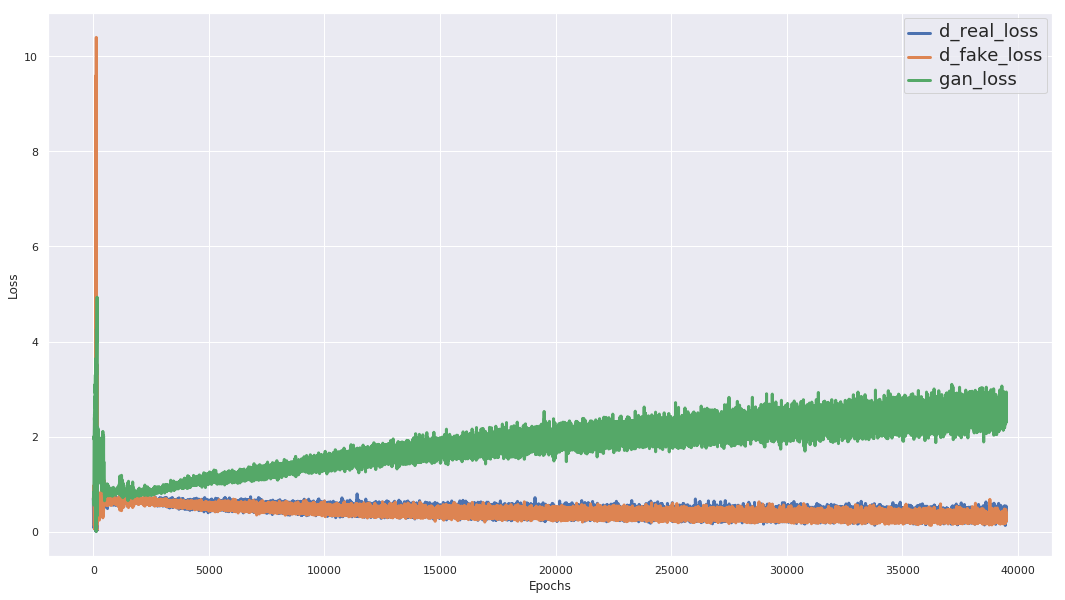

In [211]:
epochs = range(1, len(d_real_losses)+1)
plot_df = pd.DataFrame(data=np.c_[epochs,d_real_losses,d_fake_losses,gan_losses,d_real_accus, d_fake_accus],
                       columns=['epochs','d_real_losses', 'd_fake_losses', 'gan_losses', 'd_real_accus', 'd_fake_accus'])

#%%

sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(18,10))
sns.lineplot(data=plot_df, x='epochs', y='d_real_losses', ax=ax, label='d_real_loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='d_fake_losses', ax=ax, label='d_fake_loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='gan_losses', ax=ax, label='gan_loss', linewidth=3)

ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text


In [212]:
# create and save a plot of generated images 
from tensorflow.keras.models import load_model
def save_plot(examples): 
    # plot images 
    for i in range(examples.shape[0]): 
        # define subplot 
        plt.subplot(10, 10, 1 + i) 
        
        # turn off axis 
        plt.axis('off') 
        
        # plot raw pixel data 
        plt.imshow(examples[i, :, :, 0], cmap='gray_r') 
    plt.show()

    # load model
model = load_model(f"{dbBase}//model_gan_10class_28px1px_threshinv.hdf5")

In [213]:
# generate images
latent_points, labels = generate_latent_points(100, 100) 

# specify labels 
labels = np.asarray([x for _ in range(10) for x in range(10)]) 
print(labels.shape)
print(labels)

(100,)
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


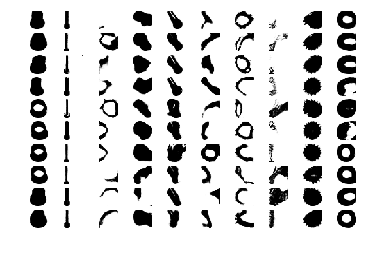

In [215]:
# generate images 
X = model.predict([latent_points, labels]) 

# scale from [-1,1] to [0,1] 
X = (X + 1) / 2.0 

# plot the result
save_plot(X)

In [216]:
classifier_model = load_model(f"{dbBase}//model_10class_28px1px_threshinv.hdf5")

In [217]:
classifier_image = X[5]
classifier_image = np.expand_dims(classifier_image, axis=0)

probs = classifier_model.predict(classifier_image)
label = np.argmax(probs, axis=1)
label[0]

5

In [219]:
part_dict = {
    0: 'Bearings',
    1: 'Bolts',
    2: 'Brackets',
    3: 'Bushing',
    4: 'Collets', 
    5: 'Pipes',
    6: 'PushRings',
    7: 'Springs',
    8: 'Sprockets',
    9: 'Washers'
}
hit_rate_hist = []
runs = 100

for run in range(runs):
    # generate latent points
    latent_points, labels = generate_latent_points(100, 100) 

    # specify conditional labels 
    labels = np.asarray([x for _ in range(10) for x in range(10)]) 
    
    # generate images 
    X = model.predict([latent_points, labels]) 

    # scale from [-1,1] to [0,1] 
    X = (X + 1) / 2.0 

    k = 0
    wrong_items = 0
    for row in range(10):
        for col in range(10):
            classifier_image = X[k]
            classifier_image = np.expand_dims(classifier_image, axis=0)
            probs = classifier_model.predict(classifier_image)
            predicted_label = np.argmax(probs, axis=1)[0]
            predicted_label = part_dict[predicted_label]
            actual_label = part_dict[col]
            print(f"Actual: {actual_label}, Pred: {predicted_label}")
            k+=1

            if actual_label != predicted_label:
                wrong_items += 1
        print("====End of Row====")    
    hit_rate = (k-wrong_items)/k
    hit_rate_hist.append(hit_rate)
    print(f"Wrong Items: {wrong_items}") 
    print(f"Hit Rate: {hit_rate}")

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Springs
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Washers
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====


Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bushing
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
A

Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pus

Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Bearings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bracket

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bu

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Springs
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Bearings
Actual: Springs, Pred: Bolts
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual:

Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Colle

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Washers
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Bolts
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 21
Hit Rate: 0.79
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: 

Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bushing
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Colle

Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 27
Hit Rate: 0.73
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bearings
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing

Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Sprockets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred

Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 26
Hit Rate: 0.74
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Col

Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets
Actua

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearing

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End 

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Ac

Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 19
Hit Rate: 0.81
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Ac

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actu

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Wrong Items: 30
Hit Rate: 0.7
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row==

Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes


Actual: Collets, Pred: Bushing
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 23
Hit Rate: 0.77
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Sprockets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Ac

Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Colle

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Bushing
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Bearings
Actual: Pipes, Pred: Washers
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End o

Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Bushing
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: 

Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Sprockets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Ac

Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 16
Hit Rate: 0.84
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bushing
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
A

Actual: Springs, Pred: Bolts
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Bushing
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Sprockets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushR

Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Sprockets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Brackets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Spr

Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Wrong Items: 30
Hit Rate: 0.7
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bushing
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Springs

Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bushing
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Sprockets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
A

Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 25
Hit Rate: 0.75
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets


Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Act

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bolts
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====


Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actua

Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Brackets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pr

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Bearings
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actua

Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bearings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pre

Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Bushing
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 33
Hit Rate: 0.67
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collet

Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Bolts
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 30
Hit Rate: 0.7


In [220]:
np.mean(hit_rate_hist)

0.7426

In [221]:
np.std(hit_rate_hist)

0.03743314039724694